# Fault development (WT01): Clustering Approach

The notebook contains fault development analysis using vibration data from WT01.

## Table of contents:
1. Loading vibration signal
2. Loading/building feature dataframe
3. Clustering features using K-means clustering

In [1]:
#### Looking at the following intervals in the traditional analysis:
intervals_wt01 = [3, 98, 204, 301, 407]
intervals_wt02 = [7, 101, 213, 293, 413]
intervals_wt03 = [1, 102, 199, 301, 411]
intervals_wt04 = [4, 102, 198, 306, 423]

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os,os.path
from scipy import stats
import glob # To count files in folder
import os.path
import progressbar
from tqdm.notebook import tqdm
from math import pi
from numpy.fft import rfftfreq, rfft
from scipy.fftpack import next_fast_len
from scipy.signal import spectrogram
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from IPython.display import Markdown

ROOT_PATH = os.path.abspath("..").split("data_processing")[0]
module_paths = []
module_paths.append(os.path.abspath(os.path.join(ROOT_PATH+"/data_processing/")))
module_paths.append(os.path.abspath(os.path.join(ROOT_PATH+"/hybrid_analysis_process_functions/")))
module_paths.append(os.path.abspath(os.path.join(ROOT_PATH+"/utils/")))
for module_path in module_paths:
    if module_path not in sys.path:
        print("appended")
        sys.path.append(module_path)

import functions as f
import wt_data, ff_transform, explore_fft_time_data, envelope, build_dataset,\
load_raw_signals, envelope, envelope_emd,plotting_methods,\
resample_signals, filter_signals, plotting_methods,filters,correlation_coeff,\
clustering,feature_extraction,polycoherence,plot_eemd,correlation_plot


appended
appended
appended
ROOT /Users/stianismar/Dropbox/gitProsjekter/master-thesis/src
/Users/stianismar/Dropbox/gitProsjekter/master-thesis/src
ROOT /Users/stianismar/Dropbox/gitProsjekter/master-thesis/src
ROOT /Users/stianismar/Dropbox/gitProsjekter/master-thesis/src
ROOT /Users/stianismar/Dropbox/gitProsjekter/master-thesis/src


In [3]:
c, p = f.color_palette()
sns.set(context='paper', style='whitegrid', palette=np.array(p))
plt.style.use(ROOT_PATH+"/utils/plotparams.rc")

# 1. Loading the vibration data

In [11]:
vib_signal, times, op_data_intervals, _ = load_raw_signals.load_raw('gearbox','wt01')

File exist


In [ ]:
# SLOW: Find out which indexes to remove:
remove_these = build_dataset.find_indexes_to_remove('WTG01')

In [4]:
wt_num=1
df_times_unfiltered = pd.read_csv('/Volumes/OsvikExtra/signal_data/raw_data/gearbox/wt01/interval_dates_wt01.csv')

In [14]:
display(Markdown(f'<span style="color: #2a9d8f; font-size: 20px">Index 350 corresponds to {df_times_unfiltered.iloc[409].Date}:</span>'))

<span style="color: #2a9d8f; font-size: 20px">Index 350 corresponds to 2019-10-27 10:08:34:</span>

In [ ]:
df_times = pd.read_csv('/Volumes/OsvikExtra/signal_data/raw_data/gearbox/wt01/interval_dates_wt01.csv')

In [ ]:
# Removing the indexes that weren't in the other op dataset.
if(op_data_intervals.shape[0] != df_times.shape[0]):
    print('removing')
    remove_these=np.flip(remove_these)
    for index in remove_these:
        df_times = df_times.drop([df_times.index[index]])
df_times.shape
df_times = df_times.reset_index(drop=True)

try: 
    # df_times = df_times.drop(['index','Unnamed: 0'],axis=1)
    df_times = df_times.drop(['level_0'],axis=1)
except: 
    print('Could not remove')

Adding dates to a new df.

In [ ]:
dates=pd.DataFrame(df_times['Date'],columns=['Date'])

formatted_dates = []

for d in dates['Date']:
    formatted_dates.append((d.split(' ')[0][:7]))
new_df=op_data_intervals
new_df['Date'] = formatted_dates

In [ ]:
# The df times which is cleaned.
df_times

In [ ]:
op_data_intervals.shape[0]

In [ ]:
p1=sns.color_palette("RdBu", n_colors=8)[2:-2]
p2=sns.color_palette("RdBu_r", n_colors=7)
p3=sns.color_palette("RdBu", n_colors=5)[1:-3]
new_palette=p1+p2+p3[0:-1]+[p2[5]]+[p1[0]]+[p1[1]]+[p1[2]]
sns.palplot(new_palette)
print("aug       sept     okt     nov    des     jan     feb     mars   april   mai    juni   juli   august  sept    octo")

In [ ]:
number_of_boxplots = len(result.groupby('Date').nunique())
number_of_boxplots

In [ ]:
import datetime
input1 = '23/12/2011'
my_date = datetime.datetime.strptime(input1, "%d/%m/%Y")
print(my_date.strftime("%d %b, %Y")) # 23 Dec, 2011



Function for plotting features to look for seasonal trends.

In [6]:
def plot_season_groups(df,features_to_plot,wtnum):
    
    df['Month'] = df['Date']

    '''p1=sns.color_palette("RdBu", n_colors=6)
    p2=sns.color_palette("RdBu_r", n_colors=7)
    p3=sns.color_palette("RdBu", n_colors=6)[1:-1]
    new_palette=p1[0:-2]+p2+p3'''
    
    # Season colors
    p1=sns.color_palette("RdBu", n_colors=8)[2:-2]
    p2=sns.color_palette("RdBu_r", n_colors=7)
    p3=sns.color_palette("RdBu", n_colors=5)[1:-3]
    new_palette=p1+p2+p3[0:-1]+[p2[5]]+[p1[0]]+[p1[1]]+[p1[2]]
    
    number_of_boxplots = len(result.groupby('Date').nunique())
            
    for i in range(len(features_to_plot)):
        feat = features_to_plot[i]
    
        # formatting title
        if (len(feat.split('_'))>2):
            feat_name=(str(feat.split('_')[0])+ '\_' + str(feat.split('_')[1])+ '\_' + str(feat.split('_')[2]))
        elif (len(feat.split('_'))>1):
            feat_name=(str(feat.split('_')[0])+ '\_' + str(feat.split('_')[1]))
        else:
            feat_name=feat
        fig = plt.figure(figsize=(15, 5))
        plot=sns.violinplot(data=df, x='Month', y=features_to_plot[i], palette=new_palette)
        
        # Calculate number of obs per group & median to position observation number
        medians = df.groupby('Date')[feat].median().values
        nobs = df['Date'].value_counts().values # number of observations for feature
        nobs = [int(x) for x in nobs.tolist()]
        # nobs = ["n: " + i for i in nobs]
        #nobs = ["N = " + i for i in nobs]
        print(nobs)
        # Add it to the plot
        pos = range(len(nobs))
        
        
        labels=plot.get_xticklabels()

        nobs = [f"N = {nobs[i]}\n {labels[i].get_text()}" for i in pos]

        plot.set_xticklabels(nobs)
        
        #for tick,label in zip(pos,plot.get_xticklabels()):
            #print(label)
            #plot.text(pos[tick], medians[tick] + 0.03, nobs[tick], horizontalalignment='center', size='large', color='black', weight='semibold')


        
        # plot = sns.swarmplot(data=df, x='Month', y=features_to_plot[i], color=".25")
        plt.xticks(rotation=45)
        plt.style.use(ROOT_PATH+"/utils/plotparams.rc")
        plt.title(f"WT0{wtnum}: Grouping "+ r"$\bf{"+str(feat_name)+"}$" +" by month")
        # plt.ylabel(ylabels[i])
        plt.xlabel('Month and number of samples (N)')
        
        '''

        if features_to_plot[i]=='WindSpeed':
            plt.ylim(3,30)

        if features_to_plot[i]=='AvgSpeed':
            plt.ylim(600,1650)

        if features_to_plot[i]=='AvgPower':
            plt.ylim(300,4000)
        '''
        plt.tight_layout()

        # Saving
        save_path=f'../../plots/features/'
        plt.savefig(f'{save_path}/grouped_by_month/{wtnum}_{features_to_plot[i]}.png',dpi=300)

        plt.show()

        
# features_to_plot = ['AvgPower', 'WindSpeed', 'AvgSpeed']        
# plot_season_groups(new_df,features_to_plot,4)

### EEMD and Bi-spectrum inspection

In [ ]:
raw_imfs_path='/Volumes/OsvikExtra/signal_data/raw_data/gearbox/wt01/eemds_wt01/'
file_count = len(glob.glob1(raw_imfs_path,"*.zip"))
print(file_count)

## Plotting an EEMD:

In [ ]:
new_row = [{'name':1, 'physics':87, 'chemistry':92, 'algebra':97}]
new_row2 = [{'name':1, 'physics':87, 'chemistry':92, 'algebra':97}]
df1=pd.DataFrame(new_row)
df2=pd.DataFrame(new_row2)

pd.concat([df1,df2])

In [ ]:
a=np.array(vib_signal[1][0:20000])
envelope_emd.eemd('WT01',1,'HSS Gearbox', a,times[1][0:20000])

In [ ]:

intervals = [4, 102, 198, 306, 423]
# fig1, axs = plt.subplots(2,2, figsize=(15, 20), facecolor='w', edgecolor='k')
#axs=axs.flatten()
for i,interval_num in enumerate(intervals):
    # reading form file
    imf_df=pd.read_csv(raw_imfs_path+f'raw_wt01_interval_number_{interval_num}.zip')
    timestamp_of_signal=df_times[df_times.index==interval_num]['Date'][interval_num]

    # plot_eemd.plot_imfs_and_kurtosis(raw_imfs_path,'eemd_wt04_interval_400',times,'zip',plot_num_intervals)
    plot_eemd.plot_n_imfs_and_kurtosis(1,imf_df,interval_num,timestamp_of_signal,f'eemd_wt01_interval_{interval_num}',times,'zip',number_to_print=6)
    #axs[i].


## Bi-spectrum

In [ ]:
print(f'The duration of the signal which bi-spectrum features are extracted \
from is {times[0][3000]}')

### Plotting one bi-spectrum with raw signal
This is plotted for comparison with the other wind turbines. This is based on the unfiltered signal.

In [ ]:


sig=vib_signal[0][0:3000]
fs = 25600

N=10000 # Select the N to split the signal into N parts
kw = dict(nperseg=N // 10, noverlap=N // 20, nfft=next_fast_len(N // 2))
freq1, fre2, bispec = polycoherence.polycoherence(sig, fs, norm=None, **kw)
polycoherence.plot_polycoherence(freq1, fre2, bispec)
plt.show()
print(bispec.shape)

bispec_half = np.triu(bispec) # remove symmetric part
polycoherence.plot_polycoherence(freq1, fre2, bispec_half)

plt.show()


sig=vib_signal[400][0:3000]
fs = 25600

N=10000 # Select the N to split the signal into N parts
kw = dict(nperseg=N // 10, noverlap=N // 20, nfft=next_fast_len(N // 2))
freq1, fre2, bispec = polycoherence.polycoherence(sig, fs, norm=None, **kw)
polycoherence.plot_polycoherence(freq1, fre2, bispec)
plt.show()
print(bispec.shape)

bispec_half = np.triu(bispec) # remove symmetric part
polycoherence.plot_polycoherence(freq1, fre2, bispec_half)

plt.show()


### Loading the HP signals (6000 Hz)
We need this signal for early fault detection, where the literature states that faulty characteristics first show up in the higher frequencies.

In [7]:
def load_6000_filtered(filtered_path):
    num_csvs = len([f for f in os.listdir(filtered_path) 
         if f.endswith('.csv') and os.path.isfile(os.path.join(filtered_path, f)) and f[0]=='f'])

    filtered_signals = []
    filtered_freqs = []
    columns = []
    for i in tqdm(range(num_csvs)):
        acc=pd.read_csv(filtered_path+'filtered_raw_6000_'+str(i)+'.csv')
        columns.append('filtered_' + str(i))
        filtered_signals.append(acc.values.T[0])
        filtered_freqs.append(acc.shape[0] / times[i][-1])
        print(f'Reading {i} / {num_csvs} files', end='\r')

    filtered_signals = np.asarray(filtered_signals)
    filtered_signals
    return filtered_signals

filtered_path = '/Volumes/OsvikExtra/signal_data/raw_filtered_6000Hz/gearbox/wt01/filtered/'
filtered_signals=load_6000_filtered(filtered_path)

Reading 409 / 410 files


### Plotting bi-spectrum for one interval (HP 6000 Hz filtered)
Since we are looking at the higher frequency bands, we want to use bi-spectrum features from these.

In [ ]:

def plot_bispec(wt_num,interval_num):
    fs=25600
    sig=filtered_signals[interval_num][0:3000] # selecting to be stationary

    N=20000 # Select the N to split the signal into N parts
    kw = dict(nperseg=N // 10, noverlap=N // 20, nfft=next_fast_len(N // 2))
    freq1, fre2, bispec = polycoherence.polycoherence(sig, fs, norm=None, **kw)
    # polycoherence.plot_polycoherence(freq1, fre2, bispec)
    # plt.show()
    # print(bispec.shape)

    bispec_half = np.triu(bispec) # remove symmetric part

    polycoherence.plot_polycoherence(freq1, fre2, bispec_half)
    var = df_times.iloc[interval_num]['Date']
    plt.title(f'WT0{wt_num}: Bispectrum plot HP filtered signal (interval {interval_num}).\n Date: {var}')
    SAVE_FILE_NAME = f'WT04_bispectrum_interval_{interval_num}'
    plt.savefig(f'../../plots/bispectrums/{SAVE_FILE_NAME}.png',dpi=200)
    plt.tight_layout()
    plt.show()
    
    
plot_interval1 = intervals_wt04[0]
plot_interval2 = intervals_wt04[-1]
    
plot_bispec(4,plot_interval1)

plot_bispec(4,plot_interval1)
plot_bispec(4,3)
plot_bispec(4,plot_interval2)

# 2. Features

### Creating/Loading feature_df
Time domain: Statistical features
Frequency domain: Bi-spectrum features
Time-frequency domain: 5 first IMF features

In [8]:
wt_num=1
feature_df=feature_extraction.generate_feature_df(wt_num,25600,op_data_intervals,filtered_signals)


All features already exist. They are returned.


In [9]:
feature_df

Unnamed: 0  Index     AvgPower     ActPower  WindSpeed  NacelleDirection  \
0             1      1  2500.973877  3090.899902       13.0        232.899994   
1             2      2  2565.207520  2660.399902        9.9         53.900002   
2             3      3  2861.552002  3301.899902       12.0        262.399994   
3             5      5  2440.011230  3288.500000       12.8        245.600006   
4             6      6  3073.377930  3307.399902       15.1        245.600006   
..          ...    ...          ...          ...        ...               ...   
250         400    400  2597.422852  3498.899902       14.6        223.800003   
251         402    402  2824.226074  2826.199951       11.7        202.300003   
252         404    404  3304.326660  3301.300049       10.2        262.100006   
253         407    407  2905.633057  3127.100098       11.0        336.299988   
254         409    409  2647.015137  3138.699951        8.6        328.899994   

        AvgSpeed     Date       rms      kurt  ...  imf_entropy_1  \
0    1511.167622  2018-08  0.022827  0.118346  ...       0.261817   
1    1472.724506  2018-08  0.022547  0.159049  ...       0.208713   
2    1499.039959  2018-08  0.021062  0.158075  ...       0.252312   
3    1512.132321  2018-08  0.021090  0.115723  ...       0.305672   
4    1492.741102  2018-08  0.020555  0.102484  ...       0.285000   
..           ...      ...       ...       ...  ...            ...   
250  1474.354390  2019-10  0.018189  0.242767  ...       0.295730   
251  1476.917656  2019-10  0.019954  0.136787  ...       0.266167   
252  1474.474730  2019-10  0.018675  0.269040  ...       0.285148   
253  1489.729665  2019-10  0.020354  0.077019  ...       0.280085   
254  1518.438571  2019-10  0.022035  0.134339  ...       0.265508   

     imf_entropy_2  imf_entropy_3  imf_entropy_4  imf_entropy_5  \
0         0.229037       0.254877       0.215578       0.048328   
1         0.209510       0.212823       0.166838       0.042485   
2         0.224996       0.256886       0.195344       0.046823   
3         0.231322       0.287955       0.265308       0.058437   
4         0.237098       0.262881       0.246280       0.055923   
..             ...            ...            ...            ...   
250       0.251685       0.273611       0.239555       0.064704   
251       0.240777       0.245299       0.219030       0.060897   
252       0.248862       0.250876       0.236328       0.085137   
253       0.225205       0.274934       0.230134       0.061012   
254       0.225997       0.266451       0.211637       0.049410   

     imf_kurtosis_1  imf_kurtosis_2  imf_kurtosis_3  imf_kurtosis_4  \
0         -0.373203       -0.039153       -0.168118       -0.331564   
1         -0.336418       -0.036626       -0.050029       -0.231564   
2         -0.067350       -0.081832       -0.067692       -0.341971   
3         -0.486230       -0.127752       -0.006750       -0.385077   
4         -0.379676        0.043587       -0.048423       -0.362534   
..              ...             ...             ...             ...   
250       -0.492728       -0.151191       -0.193023       -0.237618   
251       -0.302052        0.006817        0.071262       -0.249884   
252       -0.304486        0.081910       -0.136937       -0.155645   
253       -0.386153       -0.142239       -0.185053       -0.417121   
254       -0.449217       -0.089005       -0.219020       -0.411818   

     imf_kurtosis_5  
0          0.004238  
1         -0.084752  
2         -0.211080  
3          0.023120  
4         -0.152190  
..              ...  
250        0.029624  
251       -0.286283  
252       -0.233984  
253       -0.131161  
254       -0.203042  

[255 rows x 41 columns]

In [12]:
feature_df[feature_df['WindSpeed']<0]

Unnamed: 0  Index     AvgPower  ActPower  WindSpeed  NacelleDirection  \
150         243    243  1936.440796   -1000.0      -10.0            -500.0   
224         365    365  2641.118652   -1000.0      -10.0            -500.0   

        AvgSpeed     Date       rms      kurt  ...  imf_entropy_1  \
150  1462.286369  2019-04  0.018132  0.265793  ...       0.160212   
224  1464.997651  2019-09  0.021316  0.110920  ...       0.227054   

     imf_entropy_2  imf_entropy_3  imf_entropy_4  imf_entropy_5  \
150       0.299047       0.234912       0.367879       0.362455   
224       0.225184       0.223508       0.176409       0.048700   

     imf_kurtosis_1  imf_kurtosis_2  imf_kurtosis_3  imf_kurtosis_4  \
150      259.275924      122.197400       48.406529       13.478027   
224       -0.442438       -0.038669        0.113467       -0.361384   

     imf_kurtosis_5  
150       12.758588  
224       -0.202755  

[2 rows x 41 columns]

Removing fetures `['Unnamed: 0','NacelleDirection','entropy']` from `features_cleaned`

In [10]:
try:
    features_cleaned = feature_df.drop(['Unnamed: 0','NacelleDirection','entropy'],axis=1)
except:
    features_cleaned = feature_df.drop(['NacelleDirection','entropy'],axis=1)
features_cleaned.Date

0      2018-08
1      2018-08
2      2018-08
3      2018-08
4      2018-08
        ...   
250    2019-10
251    2019-10
252    2019-10
253    2019-10
254    2019-10
Name: Date, Length: 255, dtype: object

Boxplot of `features_cleaned`, just filtered on RPM 1450.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as plticker


#first_half_features = features_cleaned.columns[:len(features_cleaned.columns)//2]
#second_half_features = features_cleaned.columns[len(features_cleaned.columns)//2:]

#subsets=[first_half_features,second_half_features]

import time
start_time = time.time()

fig,axs = plt.subplots(9,4,figsize=(15,23))

fig.suptitle(f"WT0{str(wt_num)}: Box plot of the 36 extracted features",fontsize=30)

fig.tight_layout()
# plt.subplots_adjust(top=0.96)

i=1
for column in features_cleaned:
    if (column == 'Index' or column== 'Date'):
        continue

    ax = fig.add_subplot(13,3,i)
    ax.set_title(column,fontsize=18)
    sns.boxplot(features_cleaned[column],palette="Set2")
    ax.set_xlabel('')
    ax.grid(False)

    if (column == 'shape_factor' or column=='signal_mean'):
        #loc = plticker.MultipleLocator(base=5) # this locator puts ticks at regular intervals
        #ax.xaxis.set_major_locator(loc)
        ax.set_xticks(ax.get_xticks()[::2])


    # Removing y ticks and y labels
    frame1 = plt.gca()
    frame1.axes.yaxis.set_ticklabels([])
    frame1.axes.get_yaxis().set_ticks([])

    for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(14) 

    i+=1

# Remove the empty plots
flat = axs.flatten()
for a in flat:
    fig.delaxes(a)



# fig.subplots_adjust(hspace=0.9)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
print("--- %s seconds ---" % (time.time() - start_time))

fig.savefig(f"../../plots/box_plots/boxplot_WT0{str(wt_num)}.png",format='png',bbox_inches='tight')

plt.show()


Creating some latex tables of `features_cleaned`

In [11]:
def df_to_latex(dataframe,index=True):
    text =  dataframe.to_latex(index=index)
    return text

def head_row_col(dataframe):
    print_df = dataframe.head().iloc[:,[1,2,3,4,5]].copy()
    print_df["..."]="..."
    return print_df

In [ ]:
text1 = df_to_latex(feature_df[['AvgPower', 'ActPower', 'WindSpeed', 'AvgSpeed']].head().round(2))
print(text1)
print('##########')

dftime=head_row_col(feature_df[['rms', 'kurt',
       'skewness', 'peak_to_peak', 'crest_factor', 'shape_factor',
       'impulse_factor', 'margin_factor', 'signal_mean', 'std',
       'signal_energy']].head().round(4))

text2 = df_to_latex(dftime)
print(text2)

In [ ]:
i = 11
j = 1
a = np.zeros(shape=(i,j))
print(a.shape)
a=a.T
df = pd.DataFrame(data=a,columns=['rms', 'kurt',
       'skewness', 'peak_to_peak', 'crest_factor', 'shape_factor',
       'impulse_factor', 'margin_factor', 'signal_mean', 'std',
       'signal_energy'])
print(df_to_latex(df))


### Removing some noisy points in the ```imf_kurtosis_X``` and ```WindSpeed``` features
But first, removing some noisy data.

In [12]:
# Need to clean away these crazy points
print(np.asarray(features_cleaned[features_cleaned['imf_kurtosis_2']>5]['Index']))
print(np.asarray(features_cleaned[features_cleaned['imf_kurtosis_3']>5]['Index']))
print(np.asarray(features_cleaned[features_cleaned['imf_kurtosis_4']>5]['Index']))
print(np.asarray(features_cleaned[features_cleaned['imf_kurtosis_5']>5]['Index']))

# filtering away some noisy points:
features_cleaned = features_cleaned[features_cleaned['imf_kurtosis_1']<5]
features_cleaned = features_cleaned[features_cleaned['imf_kurtosis_2']<5]
features_cleaned = features_cleaned[features_cleaned['imf_kurtosis_3']<5]
features_cleaned = features_cleaned[features_cleaned['imf_kurtosis_4']<5]
features_cleaned = features_cleaned[features_cleaned['imf_kurtosis_5']<5]


try:
    features_cleaned=features_cleaned.drop(['cluster_assigned'],axis=1)
except:
    print("Could not remove cluster_assigned")

print(feature_df.shape)
print(features_cleaned.shape)


# Remove netgative wind speed

features_cleaned = features_cleaned[features_cleaned['WindSpeed'] > 0]
print(features_cleaned.shape)


features_cleaned=features_cleaned.reset_index(drop=True)

[158 243 336]
[127 158 243 336]
[127 158 243 336]
[127 158 243 336]
Could not remove cluster_assigned
(255, 41)
(251, 38)
(250, 38)


### Plotting features one by one

In [ ]:
# PLOT EACH COLUMN HERE:
def save_feature_figs(feature):
    for feat in features_cleaned.columns:
        
        if (len(feat.split('_'))>2):
            feat_name=(str(feat.split('_')[0])+ '\_' + str(feat.split('_')[1])+ '\_' + str(feat.split('_')[2]))
        elif (len(feat.split('_'))>1):
            feat_name=(str(feat.split('_')[0])+ '\_' + str(feat.split('_')[1]))
        else:
            feat_name=feat
        ax = features_cleaned[feat].plot(style='.-',title="WT04:\n Feature: " + r"$\bf{"+str(feat_name)+"}$",figsize=(15,3))
        ax.set_xlabel('Interval index (Time)')
        ax.set_ylabel('Feature value')
        
        plt.xlim(0,features_cleaned.shape[0])
        save_path=f'../../plots/features/{feature}'
        if (not os.path.exists(save_path)):
            try:
                os.mkdir(save_path)
            
            except OSError:
                print("Not able to create folder")

        # path exists now
        plt.tight_layout()
        plt.savefig(f'{save_path}/{feat}_and_{feature}.png',dpi=300)
        plt.show()

save_feature_figs('wt04_features_plotted_time')

Grouping `features_removed` by month and plotting  each feature to look for patterns

In [ ]:
features_cleaned.to_csv('dataset_wt_1.csv')

In [ ]:
try:
    dt_times=df_times.drop(['Unnamed: 0'],axis=1)
except:
    print('Not removed')
    dt_times = df_times

In [ ]:
formatted_dates = []

for d in dt_times['Date']:
    # df_times.append((d.split(' ')[0][:7]))
    formatted_dates.append((d.split(' ')[0][:7]))
    
new_times_df= pd.DataFrame(formatted_dates,columns=['Date'])
new_times_df['Index'] = new_times_df.index
# new_times_df=new_times_df.drop([0],axis=1) # removing a weird column

new_times_df['Index'] = new_times_df.index

Adding the month column to the features cleaned df and plotting the boxplots.

Note here that the features are cleaned!!

In [25]:
features_cleaned.drop(['Date'],axis=1,inplace=True)

In [ ]:
result = pd.merge(features_cleaned,
                  new_times_df,
                  left_on='Index',
                  right_on='Index',
                  how='left')


date_old_format=(result['Date']).values



# print(date_old_format)

import datetime
def reformat_date(date):    
    my_date = datetime.datetime.strptime(date, "%Y-%m")
    return (my_date.strftime("%m-%Y"))

result['Date']=[reformat_date(d) for d in date_old_format]

# Now, plot it: 

wtnum = 1
features_to_plot = ['Index', 'AvgPower', 'ActPower', 'WindSpeed', 'AvgSpeed', 'rms', 'kurt',
       'skewness', 'peak_to_peak', 'crest_factor', 'shape_factor',
       'impulse_factor', 'margin_factor', 'signal_mean', 'std',
       'signal_energy', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'imf_rate_1',
       'imf_rate_2', 'imf_rate_3', 'imf_rate_4', 'imf_rate_5', 'imf_entropy_1',
       'imf_entropy_2', 'imf_entropy_3', 'imf_entropy_4', 'imf_entropy_5',
       'imf_kurtosis_1', 'imf_kurtosis_2', 'imf_kurtosis_3', 'imf_kurtosis_4',
       'imf_kurtosis_5']

plot_season_groups(result,features_to_plot,wtnum)

## Correlation plot

In [ ]:
features_cleaned.columns

Is this created on the raw features_cleaned?

Is this created on the raw features_cleaned

In [ ]:
features_cleaned_corr = features_cleaned.drop(['Index'],axis=1)
correlation_plot.create_save_correlation_plot(f'wt0{wtnum}_features',f'WT0{wtnum}: Feature correlation',features_cleaned_corr)

# 3. Clustering

The function below, ```calculate_cluster_stats```, is used to calculate statistics from each cluster. In particular, we are here looking for clusters that consist of higher indexes, i.e. vibration intervals taken at a later point in time. These later intervals are more likely to have fault characteristics visible.

In [13]:
def calculate_cluster_stats(clusterDict):
    '''
        Args:
            clusterDict (Dictionary):
                keys (Integer): cluster index
                values (List): List containing index of intevals
        Returns:
            df_stats (pd.DataFrame): DataFrame containing stats about the cluster input.
    '''
    df=[]
    means=[]
    num_intervals=[]
    num_intervals_greater_than_350=[]
    percentage_greater_than_350=[]
    for i in range(len(clusterDict)):
        mean=np.mean(clusterDict[i])
        num_interval=len(clusterDict[i])
        num_interval_greater_than_350=len(list(filter(lambda index: index > 350, clusterDict[i])))
        percentage=round((num_interval_greater_than_350/num_interval)*100)

        means.append(mean)
        num_intervals.append(num_interval)
        num_intervals_greater_than_350.append(num_interval_greater_than_350)
        percentage_greater_than_350.append(percentage)


    df.append(num_intervals)
    df.append(means)
    df.append(num_intervals_greater_than_350)
    df.append(percentage_greater_than_350)
    df=np.asarray(df)


    df_stats = pd.DataFrame(data=df.T,columns=['number_of_intervals_in_cluster','avg_index','number_of_indexes_greater_than_350','percentage_intervals_greater_than_350'])
    return df_stats

**Anomaly** detecion is performed using three approaches:
 - **[1]** Some stats on the df
 - **[2]** DB-scan clustering
 - **[3]** KMeans clustering

In [1]:
wt_num = 1
wtnum = 1

In [ ]:
axx=(features_cleaned['Index']).hist(color='grey')

In [ ]:
df_times_unfiltered

## K-means raw (features_cleaned)
```K-means```for grouping signal features.

In [15]:
def kmeans(dataset_name,wt_num,SELECTED_FEATURES,max_cluster_num,print_latex=False,plottitle=''):

    '''INITIAL ELBOW METHOD:'''
    # plotting an additional plot which is not needed here
    cluster_labels = clustering.k_means_clustering(plottitle,wt_num,SELECTED_FEATURES,'kmeans', knn_clusters=max_cluster_num,plot=False,dataset_name=dataset_name)
    
    # finding the max clusters based on values
    # Use calculate_cluster_stats to optimize.
    final_array=[]
    final_df = []
    max_cluster_number=[]
    intervals_in_max_cluster=[]
    max_percentages=[]
    intervals_greater_than_350=[]
    number_of_clusters=[]
    for i in tqdm(range(2,max_cluster_num+1)):
        cluster_labels = clustering.k_means_clustering(plottitle,wt_num,SELECTED_FEATURES,'kmeans',knn_clusters=i,plot=False) # Cluster the points
        clusterDict=clustering.plot_clusters(plottitle,wt_num,i,cluster_labels,SELECTED_FEATURES,plot=False) # plot the clusters
        cluster_df=calculate_cluster_stats(clusterDict)
        display(cluster_df)

        # Do some more work here... Add them to an array and build a dataframe
        max_percentage=(cluster_df['percentage_intervals_greater_than_350'].max())
        temp=cluster_df[cluster_df['percentage_intervals_greater_than_350']==max_percentage]
        interval_in_cluster = (temp['number_of_intervals_in_cluster'].max())
        
        get_cluster = temp[temp['number_of_intervals_in_cluster']==interval_in_cluster]
        intervals_in_cluster_above_350 = get_cluster['number_of_indexes_greater_than_350']
                
        max_cluster_number.append(i)
        intervals_in_max_cluster.append(interval_in_cluster) # number of intervals in the max cluster (the cluster with most of the interesting points)
        intervals_greater_than_350.append(intervals_in_cluster_above_350.values[0]) # number of intervals greater tha 350
        max_percentages.append(max_percentage)

    # Appending to array        
    final_df.append(max_cluster_number)
    final_df.append(intervals_in_max_cluster)
    final_df.append(intervals_greater_than_350)
    final_df.append(max_percentages)

    final_df=np.asarray(final_df)

    final_df=pd.DataFrame(final_df.T,columns=['max_cluster_number','intervals_in_max_cluster','intervals_greater_than_350','max_percentages'])
    
    # Converting final_df columns to ints, except from the percentage column.
    for feat in final_df.columns:
        if feat != 'max_percentages':
            final_df[feat]=final_df[feat].apply(lambda x: int(x))
        else:
            continue
    
    #final_df.style.set_precision(0)
    text=(df_to_latex(final_df,False))
    if print_latex == True:
        print(text)
    #display(final_df)

    return final_df

 `run_kmeans` and select K based on the results of the next cell

In [16]:
# Run K-means with the selected K and df.
def run_kmeans(plottitle,wt_num, dataset_name, data_set,k,selected_cluster=None,**features_to_pairplot):
    '''
    INPUTS:
        - data_set (Pandas Dataframe): The feature dataset.
    OUTPUTS:
        - cluster_df (Pandas DataFrame): Df containing clusters and samples.
    '''
    SELECTED_FEATURES=data_set
    max_cluster_num = k
    
    '''
    df = kmeans(wt_num_string,SELECTED_FEATURES,max_cluster_num,dataset_name)

    #plt.scatter(df.max_cluster_number,df.max_percentages)
    #plt.show()

    display(df)
    '''
    SELECTED_CLUSTER_NUMBER = k # need to optimize this value

    # now plot this:
    
    # plotting elbow. 
    cluster_labels = clustering.k_means_clustering(plottitle,wt_num,SELECTED_FEATURES,'kmeans',knn_clusters=SELECTED_CLUSTER_NUMBER,plot=True,dataset_name=dataset_name,selected_cluster=selected_cluster)

    # plotting cluster development and index distribution
    clusterDict=clustering.plot_clusters(plottitle,wt_num,k,cluster_labels,SELECTED_FEATURES,plot=True,dataset_name=dataset_name) # plot the clusters

    # display(calculate_cluster_stats(clusterDict))
    
    j=0
    if features_to_pairplot:
        for key, value in features_to_pairplot.items():
            dataset_name_= dataset_name + f'_{j}_'    
            clustering.plot_clusters_pair_plot(selected_cluster,plottitle,wt_num,k,'kmeans',SELECTED_FEATURES, value,cluster_labels,dataset_name=dataset_name_) # pair plot 1
            '''
            else:
                print('len is less or equal to 2')
                clustering.scatter_plot(selected_cluster,plottitle,wt_num,k,'kmeans',SELECTED_FEATURES, value,cluster_labels,dataset_name=dataset_name_) # pair plot 1
            ''' 
            j+=1
    else:
        dataset_name1=dataset_name+'_1_'
        clustering.plot_clusters_pair_plot(selected_cluster,plottitle,wt_num,k,'kmeans',SELECTED_FEATURES, ['AvgSpeed','rms','B4'],cluster_labels,dataset_name=dataset_name1) # pair plot 1
        dataset_name2=dataset_name+'_2_'
        clustering.plot_clusters_pair_plot(selected_cluster,plottitle,wt_num,k,'kmeans',SELECTED_FEATURES, ['AvgPower','AvgSpeed','imf_entropy_4', 'imf_entropy_5','B4'],cluster_labels, dataset_name=dataset_name2) # pair plot 2
        cluster_df=calculate_cluster_stats(clusterDict)
        cluster_df
        
    return cluster_labels


# Some other feature sets

In [17]:
# Different subsets:
operating_features=features_cleaned[['Index', 'AvgPower', 'ActPower', 'WindSpeed', 'AvgSpeed']]

# Frequency-domain
bispectrum_features=features_cleaned[['B1', 'B2', 'B3', 'B4', 'B5', 'B6']]
#bispectrum_features['Index'] = features_cleaned['Index']

# Frequency-domain
time_features=features_cleaned[['rms', 'kurt',
       'skewness', 'peak_to_peak', 'crest_factor', 'shape_factor',
       'impulse_factor', 'margin_factor', 'signal_mean', 'std',
       'signal_energy']]

# Time-frequency features (EEMD; IMFs)
imf_features=features_cleaned[['imf_rate_1',
       'imf_rate_2', 'imf_rate_3', 'imf_rate_4', 'imf_rate_5', 'imf_entropy_1',
       'imf_entropy_2', 'imf_entropy_3', 'imf_entropy_4', 'imf_entropy_5']]

# IMF kurtosis features
imf_kurt_features=features_cleaned[['imf_kurtosis_1','imf_kurtosis_2','imf_kurtosis_3','imf_kurtosis_4','imf_kurtosis_5']]

In [18]:
features_cleaned.columns

Index(['Index', 'AvgPower', 'ActPower', 'WindSpeed', 'AvgSpeed', 'Date', 'rms',
       'kurt', 'skewness', 'peak_to_peak', 'crest_factor', 'shape_factor',
       'impulse_factor', 'margin_factor', 'signal_mean', 'std',
       'signal_energy', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'imf_rate_1',
       'imf_rate_2', 'imf_rate_3', 'imf_rate_4', 'imf_rate_5', 'imf_entropy_1',
       'imf_entropy_2', 'imf_entropy_3', 'imf_entropy_4', 'imf_entropy_5',
       'imf_kurtosis_1', 'imf_kurtosis_2', 'imf_kurtosis_3', 'imf_kurtosis_4',
       'imf_kurtosis_5'],
      dtype='object')

In [19]:
op_and_bispec_features = pd.concat([operating_features,bispectrum_features],axis=1)
op_and_time_features = pd.concat([operating_features,time_features],axis=1)
op_and_imf_kurtosis_features = pd.concat([operating_features,imf_kurt_features],axis=1)
op_and_imf_features = pd.concat([operating_features,imf_features],axis=1)

feature_mix=features_cleaned[['Index', 'AvgPower','WindSpeed', 'AvgSpeed','imf_rate_5','imf_kurtosis_5','B1','B5']]

features_sets= [
                op_and_bispec_features,
                op_and_time_features,
                op_and_imf_kurtosis_features,
                op_and_imf_features,
                feature_mix    
               ]

features_sets_names= [
                'op_and_bispec_features',
                'op_and_time_features',
                'op_and_imf_kurtosis_features',
                'op_and_imf_features',
                'feature_mix'
               ]

### Running through the different subsets of dataframes with kmeans

In [ ]:
import matplotlib
# this method is just for plotting the different final_dfs (the dfs comaring the K values.)

def plot_k_means_tuning(wt_num,df,feature_set_name):
    colormap = plt.cm.Blues
    normalize = matplotlib.colors.Normalize(vmin=-20, vmax=30)
    
    fig,ax=plt.subplots(figsize=(15,5))
    # df.plot.scatter(x='intervals_in_max_cluster',y='max_percentages',c='max_cluster_number',cmap='Blues',s=50,ax=ax)
    
    df.plot.scatter(x='intervals_in_max_cluster',y='max_cluster_number',c='max_percentages',cmap='Blues',s=50,ax=ax)

    # plt.scatter(df.intervals_in_max_cluster,df.max_cluster_number,s=100,c=df.max_percentages,cmap='Blues',norm=normalize)
    # plt.colorbar()
    # plt.clim(0,29)
    ax.set_ylabel('K')
    ax.set_xlabel('Total number of intervals in cluster')
    # ax.legend(title='Percentage of intervals in cluster with Index > 350')
    ax.set_title(f'{wt_num}: Parameter tuning for K-means to tune number of later intervals isolated\n Feature set: {feature_set_name}')
    plt.show()

#### The whole DF first:

In [20]:
features_cleaned.columns

Index(['Index', 'AvgPower', 'ActPower', 'WindSpeed', 'AvgSpeed', 'Date', 'rms',
       'kurt', 'skewness', 'peak_to_peak', 'crest_factor', 'shape_factor',
       'impulse_factor', 'margin_factor', 'signal_mean', 'std',
       'signal_energy', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'imf_rate_1',
       'imf_rate_2', 'imf_rate_3', 'imf_rate_4', 'imf_rate_5', 'imf_entropy_1',
       'imf_entropy_2', 'imf_entropy_3', 'imf_entropy_4', 'imf_entropy_5',
       'imf_kurtosis_1', 'imf_kurtosis_2', 'imf_kurtosis_3', 'imf_kurtosis_4',
       'imf_kurtosis_5'],
      dtype='object')

In [21]:
try:
    features_cleaned = features_cleaned.drop(labels=['cluster_assigned'],axis=1)
except:
    pass
try:
    features_cleaned = features_cleaned.drop(labels=['cluster_assigned'],axis=1)
except:
    pass

len(features_cleaned.columns)
features_cleaned.columns

Index(['Index', 'AvgPower', 'ActPower', 'WindSpeed', 'AvgSpeed', 'Date', 'rms',
       'kurt', 'skewness', 'peak_to_peak', 'crest_factor', 'shape_factor',
       'impulse_factor', 'margin_factor', 'signal_mean', 'std',
       'signal_energy', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'imf_rate_1',
       'imf_rate_2', 'imf_rate_3', 'imf_rate_4', 'imf_rate_5', 'imf_entropy_1',
       'imf_entropy_2', 'imf_entropy_3', 'imf_entropy_4', 'imf_entropy_5',
       'imf_kurtosis_1', 'imf_kurtosis_2', 'imf_kurtosis_3', 'imf_kurtosis_4',
       'imf_kurtosis_5'],
      dtype='object')

Index(['Index', 'AvgPower', 'ActPower', 'WindSpeed', 'AvgSpeed', 'Date', 'rms',
       'kurt', 'skewness', 'peak_to_peak', 'crest_factor', 'shape_factor',
       'impulse_factor', 'margin_factor', 'signal_mean', 'std',
       'signal_energy', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'imf_rate_1',
       'imf_rate_2', 'imf_rate_3', 'imf_rate_4', 'imf_rate_5', 'imf_entropy_1',
       'imf_entropy_2', 'imf_entropy_3', 'imf_entropy_4', 'imf_entropy_5',
       'imf_kurtosis_1', 'imf_kurtosis_2', 'imf_kurtosis_3', 'imf_kurtosis_4',
       'imf_kurtosis_5'],
      dtype='object')

In [26]:
# The whole DF
display(Markdown(f'<span style="color: #2a9d8f; font-size: 20px">Features cleaned:</span>'))
print(wt_num)
df=kmeans('all_36_features_initial',wt_num, features_cleaned,20,print_latex=True,plottitle='All 36 features initially')
display(df)

# plot_k_means_tuning(wt_num, df,'All 36 features')

<span style="color: #2a9d8f; font-size: 20px">Features cleaned:</span>

1
Marker-styles not there.


Marker-styles not there.


number_of_intervals_in_cluster  avg_index  \
0                           150.0     209.20   
1                           100.0     202.29   

   number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                23.0                                   15.0  
1                                18.0                                   18.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                            72.0  207.666667   
1                            81.0  192.604938   
2                            97.0  217.072165   

   number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                12.0                                   17.0  
1                                13.0                                   16.0  
2                                16.0                                   16.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                            67.0  190.029851   
1                            62.0  203.822581   
2                            96.0  218.687500   
3                            25.0  209.840000   

   number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                10.0                                   15.0  
1                                11.0                                   18.0  
2                                16.0                                   17.0  
3                                 4.0                                   16.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                            51.0  205.529412   
1                            68.0  194.588235   
2                            72.0  216.138889   
3                            25.0  209.840000   
4                            34.0  208.441176   

   number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                 9.0                                   18.0  
1                                11.0                                   16.0  
2                                15.0                                   21.0  
3                                 4.0                                   16.0  
4                                 2.0                                    6.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                             8.0  218.125000   
1                            67.0  188.850746   
2                            43.0  215.976744   
3                            75.0  219.800000   
4                            33.0  195.969697   
5                            24.0  207.166667   

   number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                 2.0                                   25.0  
1                                10.0                                   15.0  
2                                 7.0                                   16.0  
3                                16.0                                   21.0  
4                                 2.0                                    6.0  
5                                 4.0                                   17.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                            10.0  228.300000   
1                            61.0  189.344262   
2                            67.0  220.940299   
3                            22.0  193.000000   
4                            34.0  195.823529   
5                            36.0  216.611111   
6                            20.0  213.550000   

   number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                 2.0                                   20.0  
1                                10.0                                   16.0  
2                                14.0                                   21.0  
3                                 2.0                                    9.0  
4                                 2.0                                    6.0  
5                                 7.0                                   19.0  
6                                 4.0                                   20.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                             6.0  165.833333   
1                            36.0  166.305556   
2                            27.0  198.703704   
3                            34.0  212.058824   
4                            35.0  222.800000   
5                            20.0  213.550000   
6                            66.0  218.606061   
7                            26.0  213.653846   

   number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                 0.0                                    0.0  
1                                 5.0                                   14.0  
2                                 2.0                                    7.0  
3                                 5.0                                   15.0  
4                                 8.0                                   23.0  
5                                 4.0                                   20.0  
6                                12.0                                   18.0  
7                                 5.0                                   19.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                             4.0  194.000000   
1                            38.0  171.236842   
2                            23.0  206.956522   
3                            36.0  211.138889   
4                            14.0  234.500000   
5                            21.0  209.619048   
6                            60.0  210.816667   
7                            26.0  213.653846   
8                            28.0  217.000000   

   number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                 0.0                                    0.0  
1                                 5.0                                   13.0  
2                                 2.0                                    9.0  
3                                 5.0                                   14.0  
4                                 3.0                                   21.0  
5                                 4.0                                   19.0  
6                                11.0                                   18.0  
7                                 5.0                                   19.0  
8                                 6.0                                   21.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                            30.0  182.400000   
1                            53.0  185.056604   
2                            29.0  213.448276   
3                            16.0  179.250000   
4                            28.0  209.607143   
5                            20.0  223.300000   
6                            40.0  229.425000   
7                            19.0  216.578947   
8                             3.0  229.666667   
9                            12.0  246.250000   

   number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                 2.0                                    7.0  
1                                 8.0                                   15.0  
2                                 5.0                                   17.0  
3                                 0.0                                    0.0  
4                                 6.0                                   21.0  
5                                 4.0                                   20.0  
6                                 9.0                                   22.0  
7                                 4.0                                   21.0  
8                                 0.0                                    0.0  
9                                 3.0                                   25.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                             12.0  216.666667   
1                             19.0  216.578947   
2                             16.0  192.250000   
3                             21.0  192.380952   
4                             24.0  198.291667   
5                             42.0  183.666667   
6                             23.0  194.043478   
7                             15.0  197.733333   
8                             26.0  213.653846   
9                             48.0  240.520833   
10                             4.0  194.000000   

    number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                  2.0                                   17.0  
1                                  4.0                                   21.0  
2                                  0.0                                    0.0  
3                                  3.0                                   14.0  
4                                  3.0                                   12.0  
5                                  7.0                                   17.0  
6                                  3.0                                   13.0  
7                                  3.0                                   20.0  
8                                  5.0                                   19.0  
9                                 11.0                                   23.0  
10                                 0.0                                    0.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                              4.0  194.000000   
1                             38.0  167.789474   
2                             16.0  210.062500   
3                             23.0  199.608696   
4                             13.0  241.769231   
5                              9.0  152.000000   
6                             33.0  228.454545   
7                             23.0  235.347826   
8                             27.0  217.185185   
9                             23.0  183.695652   
10                            15.0  218.533333   
11                            26.0  218.269231   

    number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                  0.0                                    0.0  
1                                  5.0                                   13.0  
2                                  2.0                                   12.0  
3                                  5.0                                   22.0  
4                                  3.0                                   23.0  
5                                  0.0                                    0.0  
6                                  6.0                                   18.0  
7                                  5.0                                   22.0  
8                                  6.0                                   22.0  
9                                  1.0                                    4.0  
10                                 4.0                                   27.0  
11                                 4.0                                   15.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                              4.0  194.000000   
1                             32.0  158.875000   
2                              9.0  233.777778   
3                             22.0  213.409091   
4                             13.0  241.769231   
5                              8.0  140.500000   
6                             38.0  214.421053   
7                             23.0  235.434783   
8                             22.0  204.681818   
9                             23.0  183.695652   
10                            14.0  223.000000   
11                            25.0  212.800000   
12                            17.0  232.352941   

    number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                  0.0                                    0.0  
1                                  4.0                                   12.0  
2                                  1.0                                   11.0  
3                                  6.0                                   27.0  
4                                  3.0                                   23.0  
5                                  0.0                                    0.0  
6                                  6.0                                   16.0  
7                                  5.0                                   22.0  
8                                  3.0                                   14.0  
9                                  1.0                                    4.0  
10                                 4.0                                   29.0  
11                                 3.0                                   12.0  
12                                 5.0                                   29.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                              4.0  194.000000   
1                             29.0  151.103448   
2                              9.0  233.777778   
3                             25.0  205.880000   
4                             12.0  239.166667   
5                              8.0  140.500000   
6                             30.0  213.866667   
7                             21.0  248.476190   
8                             26.0  221.461538   
9                             23.0  183.695652   
10                            14.0  223.000000   
11                            26.0  218.269231   
12                            16.0  231.687500   
13                             7.0  155.000000   

    number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                  0.0                                    0.0  
1                                  3.0                                   10.0  
2                                  1.0                                   11.0  
3                                  5.0                                   20.0  
4                                  3.0                                   25.0  
5                                  0.0                                    0.0  
6                                  6.0                                   20.0  
7                                  5.0                                   24.0  
8                                  5.0                                   19.0  
9                                  1.0                                    4.0  
10                                 4.0                                   29.0  
11                                 4.0                                   15.0  
12                                 3.0                                   19.0  
13                                 1.0                                   14.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                             23.0  176.782609   
1                             14.0  158.000000   
2                             17.0  188.352941   
3                             33.0  237.909091   
4                              6.0  255.500000   
5                             12.0  201.083333   
6                             23.0  168.173913   
7                             13.0  198.615385   
8                             35.0  217.800000   
9                             12.0  217.916667   
10                            17.0  176.647059   
11                            13.0  233.153846   
12                             3.0  229.666667   
13                             8.0  234.375000   
14                            21.0  240.285714   

    number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                  1.0                                    4.0  
1                                  2.0                                   14.0  
2                                  2.0                                   12.0  
3                                  9.0                                   27.0  
4                                  2.0                                   33.0  
5                                  3.0                                   25.0  
6                                  3.0                                   13.0  
7                                  2.0                                   15.0  
8                                  6.0                                   17.0  
9                                  2.0                                   17.0  
10                                 0.0                                    0.0  
11                                 2.0                                   15.0  
12                                 0.0                                    0.0  
13                                 2.0                                   25.0  
14                                 5.0                                   24.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                              4.0  194.000000   
1                             28.0  153.714286   
2                             10.0  240.500000   
3                             20.0  226.550000   
4                             11.0  243.818182   
5                              8.0  140.500000   
6                             26.0  197.538462   
7                             20.0  248.700000   
8                             14.0  209.928571   
9                             16.0  214.062500   
10                            14.0  231.071429   
11                            27.0  218.814815   
12                            16.0  245.625000   
13                             5.0  120.000000   
14                            16.0  192.250000   
15                            15.0  170.933333   

    number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                  0.0                                    0.0  
1                                  3.0                                   11.0  
2                                  1.0                                   10.0  
3                                  6.0                                   30.0  
4                                  3.0                                   27.0  
5                                  0.0                                    0.0  
6                                  6.0                                   23.0  
7                                  5.0                                   25.0  
8                                  1.0                                    7.0  
9                                  1.0                                    6.0  
10                                 4.0                                   29.0  
11                                 3.0                                   11.0  
12                                 4.0                                   25.0  
13                                 0.0                                    0.0  
14                                 0.0                                    0.0  
15                                 4.0                                   27.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                             17.0  192.000000   
1                             15.0  164.866667   
2                             16.0  190.937500   
3                             27.0  248.407407   
4                              6.0  255.500000   
5                             12.0  201.083333   
6                             22.0  160.454545   
7                             13.0  198.615385   
8                             34.0  220.235294   
9                             11.0  227.545455   
10                            15.0  182.066667   
11                            13.0  233.153846   
12                             3.0  229.666667   
13                             3.0  268.333333   
14                            19.0  238.578947   
15                            14.0  135.857143   
16                            10.0  237.000000   

    number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                  0.0                                    0.0  
1                                  2.0                                   13.0  
2                                  2.0                                   12.0  
3                                 10.0                                   37.0  
4                                  2.0                                   33.0  
5                                  3.0                                   25.0  
6                                  3.0                                   14.0  
7                                  2.0                                   15.0  
8                                  4.0                                   12.0  
9                                  2.0                                   18.0  
10                                 0.0                                    0.0  
11                                 2.0                                   15.0  
12                                 0.0                                    0.0  
13                                 1.0                                   33.0  
14                                 5.0                                   26.0  
15                                 1.0                                    7.0  
16                                 2.0                                   20.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                             11.0  193.454545   
1                             15.0  164.866667   
2                             16.0  190.937500   
3                             31.0  230.064516   
4                              6.0  255.500000   
5                             12.0  201.083333   
6                             22.0  160.454545   
7                             13.0  198.615385   
8                             33.0  224.696970   
9                             11.0  227.545455   
10                            15.0  182.066667   
11                            13.0  233.153846   
12                             3.0  229.666667   
13                             3.0  268.333333   
14                            16.0  238.937500   
15                             2.0  113.500000   
16                            10.0  237.000000   
17                            18.0  176.055556   

    number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                  0.0                                    0.0  
1                                  2.0                                   13.0  
2                                  2.0                                   12.0  
3                                 10.0                                   32.0  
4                                  2.0                                   33.0  
5                                  3.0                                   25.0  
6                                  3.0                                   14.0  
7                                  2.0                                   15.0  
8                                  4.0                                   12.0  
9                                  2.0                                   18.0  
10                                 0.0                                    0.0  
11                                 2.0                                   15.0  
12                                 0.0                                    0.0  
13                                 1.0                                   33.0  
14                                 4.0                                   25.0  
15                                 0.0                                    0.0  
16                                 2.0                                   20.0  
17                                 2.0                                   11.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                             11.0  193.454545   
1                             15.0  164.866667   
2                             16.0  190.937500   
3                             31.0  230.064516   
4                              6.0  255.500000   
5                             12.0  201.083333   
6                             22.0  160.454545   
7                             13.0  198.615385   
8                             33.0  224.696970   
9                             11.0  227.545455   
10                            15.0  182.066667   
11                            13.0  233.153846   
12                             1.0  183.000000   
13                             3.0  268.333333   
14                            16.0  238.937500   
15                             3.0  148.333333   
16                            10.0  237.000000   
17                            18.0  176.055556   
18                             1.0  288.000000   

    number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                  0.0                                    0.0  
1                                  2.0                                   13.0  
2                                  2.0                                   12.0  
3                                 10.0                                   32.0  
4                                  2.0                                   33.0  
5                                  3.0                                   25.0  
6                                  3.0                                   14.0  
7                                  2.0                                   15.0  
8                                  4.0                                   12.0  
9                                  2.0                                   18.0  
10                                 0.0                                    0.0  
11                                 2.0                                   15.0  
12                                 0.0                                    0.0  
13                                 1.0                                   33.0  
14                                 4.0                                   25.0  
15                                 0.0                                    0.0  
16                                 2.0                                   20.0  
17                                 2.0                                   11.0  
18                                 0.0                                    0.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                             11.0  193.454545   
1                             14.0  169.285714   
2                             16.0  190.937500   
3                             31.0  230.064516   
4                              6.0  255.500000   
5                             12.0  201.083333   
6                             21.0  152.142857   
7                             13.0  198.615385   
8                             33.0  224.696970   
9                             11.0  227.545455   
10                            15.0  182.066667   
11                            13.0  233.153846   
12                             1.0  183.000000   
13                             2.0  342.000000   
14                            16.0  238.937500   
15                             3.0  148.333333   
16                            10.0  219.000000   
17                            18.0  176.055556   
18                             1.0  288.000000   
19                             3.0  246.333333   

    number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                  0.0                                    0.0  
1                                  2.0                                   14.0  
2                                  2.0                                   12.0  
3                                 10.0                                   32.0  
4                                  2.0                                   33.0  
5                                  3.0                                   25.0  
6                                  2.0                                   10.0  
7                                  2.0                                   15.0  
8                                  4.0                                   12.0  
9                                  2.0                                   18.0  
10                                 0.0                                    0.0  
11                                 2.0                                   15.0  
12                                 0.0                                    0.0  
13                                 1.0                                   50.0  
14                                 4.0                                   25.0  
15                                 0.0                                    0.0  
16                                 2.0                                   20.0  
17                                 2.0                                   11.0  
18                                 0.0                                    0.0  
19                                 1.0                                   33.0


\begin{tabular}{rrrr}
\toprule
 max\_cluster\_number &  intervals\_in\_max\_cluster &  intervals\_greater\_than\_350 &  max\_percentages \\
\midrule
                  2 &                       100 &                          18 &             18.0 \\
                  3 &                        72 &                          12 &             17.0 \\
                  4 &                        62 &                          11 &             18.0 \\
                  5 &                        72 &                          15 &             21.0 \\
                  6 &                         8 &                           2 &             25.0 \\
                  7 &                        67 &                          14 &             21.0 \\
                  8 &                        35 &                           8 &             23.0 \\
                  9 &                        28 &                           6 &             21.0 \\
                 10 &                        12 & 

max_cluster_number  intervals_in_max_cluster  intervals_greater_than_350  \
0                    2                       100                          18   
1                    3                        72                          12   
2                    4                        62                          11   
3                    5                        72                          15   
4                    6                         8                           2   
5                    7                        67                          14   
6                    8                        35                           8   
7                    9                        28                           6   
8                   10                        12                           3   
9                   11                        48                          11   
10                  12                        15                           4   
11                  13                        17                           5   
12                  14                        14                           4   
13                  15                         6                           2   
14                  16                        20                           6   
15                  17                        27                          10   
16                  18                         6                           2   
17                  19                         6                           2   
18                  20                         2                           1   

    max_percentages  
0              18.0  
1              17.0  
2              18.0  
3              21.0  
4              25.0  
5              21.0  
6              23.0  
7              21.0  
8              25.0  
9              23.0  
10             27.0  
11             29.0  
12             29.0  
13             33.0  
14             30.0  
15             37.0  
16             33.0  
17             33.0  
18             50.0

### Selecting K=17 and producing plots

In [ ]:
features_cleaned.columns

In [ ]:
#ddef run_kmeans(plottitle,wt_num, dataset_name, data_set,k,selected_cluster=None,**features_to_pairplot):
wt_num_string='1'
assigned = run_kmeans('Complete data set',wt_num_string,'all_36_features', features_cleaned,17,
                      selected_cluster=3,
                      fset1=['AvgPower','B1'],
                      fset2=['AvgPower','B5'],
                      fset3=['AvgPower','imf_kurtosis_5'],
                      fset4=['AvgSpeed','rms','B4'],
                      fset5=['AvgPower','AvgSpeed','imf_entropy_4', 'imf_entropy_5','B4'],
                      fset6=['AvgPower','AvgSpeed','B1', 'B2','B3'],
                      fset7=['AvgPower','AvgSpeed','B1'],
                      fset8=['AvgPower','B1','B3','imf_kurtosis_5'])

# Study the printed table as well.

#### Now, running the other subsets

In [27]:
wt_num = '1'
for i,features in enumerate(features_sets):
    try:
        features=features.drop(['cluster_assigned'],axis=1)
    except:
        print("Could not remove cluster_assigned")
    print(features.columns)
    display(Markdown(f'<span style="color: #2a9d8f; font-size: 20px">{features_sets_names[i]}:</span>'))    
    df=kmeans(features_sets_names[i],wt_num, features,20,print_latex=False,plottitle=f'{features_sets_names[i]} Initially')
    display(df)
    plt.show()

Could not remove cluster_assigned
Index(['Index', 'AvgPower', 'ActPower', 'WindSpeed', 'AvgSpeed', 'B1', 'B2',
       'B3', 'B4', 'B5', 'B6'],
      dtype='object')


<span style="color: #2a9d8f; font-size: 20px">op_and_bispec_features:</span>

Marker-styles not there.


Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                           107.0  199.317757   
1                           143.0  211.762238   

   number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                19.0                                   18.0  
1                                22.0                                   15.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                           115.0  216.808696   
1                            69.0  186.956522   
2                            66.0  208.727273   

   number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                19.0                                   17.0  
1                                 9.0                                   13.0  
2                                13.0                                   20.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                            87.0  206.218391   
1                            60.0  199.083333   
2                            14.0  213.000000   
3                            89.0  210.573034   

   number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                17.0                                   20.0  
1                                 8.0                                   13.0  
2                                 3.0                                   21.0  
3                                13.0                                   15.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                            56.0  195.982143   
1                            49.0  193.448980   
2                            60.0  203.216667   
3                            77.0  223.597403   
4                             8.0  218.125000   

   number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                 8.0                                   14.0  
1                                 6.0                                   12.0  
2                                11.0                                   18.0  
3                                14.0                                   18.0  
4                                 2.0                                   25.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                            54.0  192.111111   
1                            31.0  203.258065   
2                            58.0  202.396552   
3                            61.0  225.950820   
4                             8.0  218.125000   
5                            38.0  201.763158   

   number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                 8.0                                   15.0  
1                                 3.0                                   10.0  
2                                10.0                                   17.0  
3                                11.0                                   18.0  
4                                 2.0                                   25.0  
5                                 7.0                                   18.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                            35.0  191.657143   
1                            34.0  205.735294   
2                            45.0  213.800000   
3                            19.0  191.947368   
4                            64.0  230.062500   
5                            46.0  186.217391   
6                             7.0  192.571429   

   number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                 6.0                                   17.0  
1                                 4.0                                   12.0  
2                                 9.0                                   20.0  
3                                 3.0                                   16.0  
4                                13.0                                   20.0  
5                                 5.0                                   11.0  
6                                 1.0                                   14.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                             8.0  179.250000   
1                            52.0  230.192308   
2                            55.0  205.763636   
3                            52.0  207.403846   
4                             8.0  218.125000   
5                            29.0  150.862069   
6                            17.0  216.823529   
7                            29.0  217.137931   

   number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                 1.0                                   12.0  
1                                 9.0                                   17.0  
2                                 8.0                                   15.0  
3                                10.0                                   19.0  
4                                 2.0                                   25.0  
5                                 4.0                                   14.0  
6                                 4.0                                   24.0  
7                                 3.0                                   10.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                             6.0  202.000000   
1                            37.0  223.270270   
2                            35.0  203.885714   
3                            50.0  202.240000   
4                             8.0  218.125000   
5                            28.0  154.428571   
6                            17.0  216.823529   
7                            23.0  212.260870   
8                            46.0  222.847826   

   number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                 1.0                                   17.0  
1                                 4.0                                   11.0  
2                                 5.0                                   14.0  
3                                 9.0                                   18.0  
4                                 2.0                                   25.0  
5                                 4.0                                   14.0  
6                                 4.0                                   24.0  
7                                 3.0                                   13.0  
8                                 9.0                                   20.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                            26.0  207.538462   
1                             6.0  202.000000   
2                            27.0  197.703704   
3                            42.0  222.333333   
4                             4.0  196.750000   
5                            37.0  187.486486   
6                            30.0  200.966667   
7                            22.0  175.090909   
8                            14.0  203.071429   
9                            42.0  235.166667   

   number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                 3.0                                   12.0  
1                                 1.0                                   17.0  
2                                 4.0                                   15.0  
3                                 9.0                                   21.0  
4                                 0.0                                    0.0  
5                                 6.0                                   16.0  
6                                 4.0                                   13.0  
7                                 3.0                                   14.0  
8                                 2.0                                   14.0  
9                                 9.0                                   21.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                             25.0  209.080000   
1                             33.0  223.424242   
2                             30.0  197.833333   
3                             15.0  194.200000   
4                              4.0  196.750000   
5                             30.0  182.833333   
6                             31.0  197.580645   
7                             21.0  179.714286   
8                             13.0  217.538462   
9                             41.0  238.560976   
10                             7.0  197.285714   

    number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                  3.0                                   12.0  
1                                  6.0                                   18.0  
2                                  4.0                                   13.0  
3                                  4.0                                   27.0  
4                                  0.0                                    0.0  
5                                  4.0                                   13.0  
6                                  4.0                                   13.0  
7                                  3.0                                   14.0  
8                                  3.0                                   23.0  
9                                  9.0                                   22.0  
10                                 1.0                                   14.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                             21.0  198.095238   
1                             10.0  224.100000   
2                             30.0  204.866667   
3                             26.0  150.653846   
4                              7.0  192.571429   
5                              6.0  202.000000   
6                             24.0  217.250000   
7                             16.0  207.750000   
8                             35.0  217.942857   
9                             33.0  245.363636   
10                            23.0  202.565217   
11                            19.0  192.789474   

    number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                  3.0                                   14.0  
1                                  1.0                                   10.0  
2                                  5.0                                   17.0  
3                                  4.0                                   15.0  
4                                  1.0                                   14.0  
5                                  1.0                                   17.0  
6                                  3.0                                   12.0  
7                                  3.0                                   19.0  
8                                  8.0                                   23.0  
9                                  8.0                                   24.0  
10                                 1.0                                    4.0  
11                                 3.0                                   16.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                             27.0  208.407407   
1                             11.0  195.181818   
2                             15.0  211.800000   
3                             19.0  164.105263   
4                             22.0  204.909091   
5                              4.0  196.750000   
6                             22.0  246.136364   
7                             19.0  184.578947   
8                             39.0  215.128205   
9                             34.0  220.117647   
10                            23.0  199.000000   
11                             9.0  236.333333   
12                             6.0  124.166667   

    number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                  5.0                                   19.0  
1                                  1.0                                    9.0  
2                                  4.0                                   27.0  
3                                  3.0                                   16.0  
4                                  2.0                                    9.0  
5                                  0.0                                    0.0  
6                                  5.0                                   23.0  
7                                  3.0                                   16.0  
8                                  6.0                                   15.0  
9                                  8.0                                   24.0  
10                                 2.0                                    9.0  
11                                 2.0                                   22.0  
12                                 0.0                                    0.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                             34.0  208.529412   
1                             24.0  201.875000   
2                             32.0  186.843750   
3                              4.0  196.750000   
4                             29.0  209.620690   
5                              5.0  232.800000   
6                             14.0  191.857143   
7                             14.0  227.714286   
8                             21.0  169.952381   
9                             31.0  244.709677   
10                             2.0  196.500000   
11                            25.0  205.800000   
12                             5.0  208.000000   
13                            10.0  205.800000   

    number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                  6.0                                   18.0  
1                                  2.0                                    8.0  
2                                  4.0                                   12.0  
3                                  0.0                                    0.0  
4                                  4.0                                   14.0  
5                                  2.0                                   40.0  
6                                  2.0                                   14.0  
7                                  4.0                                   29.0  
8                                  3.0                                   14.0  
9                                  6.0                                   19.0  
10                                 0.0                                    0.0  
11                                 6.0                                   24.0  
12                                 1.0                                   20.0  
13                                 1.0                                   10.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                             35.0  209.657143   
1                             23.0  191.826087   
2                             26.0  186.038462   
3                              4.0  196.750000   
4                             32.0  210.281250   
5                              5.0  232.800000   
6                             14.0  155.285714   
7                             14.0  227.714286   
8                             15.0  184.333333   
9                             28.0  238.000000   
10                             2.0  196.500000   
11                            14.0  224.428571   
12                             5.0  208.000000   
13                            11.0  195.272727   
14                            22.0  219.454545   

    number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                  6.0                                   17.0  
1                                  3.0                                   13.0  
2                                  3.0                                   12.0  
3                                  0.0                                    0.0  
4                                  4.0                                   12.0  
5                                  2.0                                   40.0  
6                                  1.0                                    7.0  
7                                  4.0                                   29.0  
8                                  3.0                                   20.0  
9                                  7.0                                   25.0  
10                                 0.0                                    0.0  
11                                 3.0                                   21.0  
12                                 1.0                                   20.0  
13                                 1.0                                    9.0  
14                                 3.0                                   14.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                             34.0  216.088235   
1                             26.0  194.384615   
2                             22.0  212.181818   
3                              4.0  196.750000   
4                             29.0  201.965517   
5                              4.0  239.500000   
6                             12.0  132.916667   
7                             11.0  204.272727   
8                             16.0  188.625000   
9                             24.0  263.166667   
10                             2.0  196.500000   
11                            12.0  226.666667   
12                             5.0  208.000000   
13                            11.0  195.272727   
14                            21.0  214.095238   
15                            17.0  174.411765   

    number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                  7.0                                   21.0  
1                                  3.0                                   12.0  
2                                  2.0                                    9.0  
3                                  0.0                                    0.0  
4                                  3.0                                   10.0  
5                                  2.0                                   50.0  
6                                  1.0                                    8.0  
7                                  2.0                                   18.0  
8                                  3.0                                   19.0  
9                                  8.0                                   33.0  
10                                 0.0                                    0.0  
11                                 3.0                                   25.0  
12                                 1.0                                   20.0  
13                                 1.0                                    9.0  
14                                 3.0                                   14.0  
15                                 2.0                                   12.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                             22.0  220.181818   
1                             17.0  189.705882   
2                              3.0  201.333333   
3                             16.0  193.937500   
4                             34.0  190.029412   
5                             22.0  204.590909   
6                             18.0  197.722222   
7                             19.0  234.473684   
8                             16.0  179.875000   
9                             23.0  251.782609   
10                            26.0  219.769231   
11                             5.0  144.400000   
12                             9.0  159.444444   
13                             5.0  208.000000   
14                            12.0  225.083333   
15                             1.0  183.000000   
16                             2.0  196.500000   

    number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                  3.0                                   14.0  
1                                  4.0                                   24.0  
2                                  0.0                                    0.0  
3                                  3.0                                   19.0  
4                                  6.0                                   18.0  
5                                  2.0                                    9.0  
6                                  3.0                                   17.0  
7                                  3.0                                   16.0  
8                                  4.0                                   25.0  
9                                  6.0                                   26.0  
10                                 3.0                                   12.0  
11                                 0.0                                    0.0  
12                                 1.0                                   11.0  
13                                 1.0                                   20.0  
14                                 2.0                                   17.0  
15                                 0.0                                    0.0  
16                                 0.0                                    0.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                             15.0  213.533333   
1                             24.0  196.958333   
2                             22.0  212.181818   
3                              4.0  196.750000   
4                             19.0  222.000000   
5                              4.0  239.500000   
6                             11.0  132.818182   
7                             11.0  204.272727   
8                             12.0  184.250000   
9                             23.0  255.869565   
10                             2.0  196.500000   
11                            13.0  212.076923   
12                             5.0  208.000000   
13                             3.0  258.000000   
14                            21.0  214.095238   
15                            15.0  176.133333   
16                            25.0  214.840000   
17                            21.0  179.571429   

    number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                  2.0                                   13.0  
1                                  3.0                                   12.0  
2                                  2.0                                    9.0  
3                                  0.0                                    0.0  
4                                  3.0                                   16.0  
5                                  2.0                                   50.0  
6                                  1.0                                    9.0  
7                                  2.0                                   18.0  
8                                  3.0                                   25.0  
9                                  7.0                                   30.0  
10                                 0.0                                    0.0  
11                                 3.0                                   23.0  
12                                 1.0                                   20.0  
13                                 0.0                                    0.0  
14                                 3.0                                   14.0  
15                                 2.0                                   13.0  
16                                 5.0                                   20.0  
17                                 2.0                                   10.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                             15.0  213.533333   
1                             24.0  196.958333   
2                             22.0  212.181818   
3                              2.0  235.500000   
4                             19.0  222.000000   
5                              4.0  239.500000   
6                             12.0  152.083333   
7                             11.0  204.272727   
8                             12.0  184.250000   
9                             23.0  255.869565   
10                             2.0  196.500000   
11                            12.0  199.416667   
12                             5.0  208.000000   
13                             3.0  258.000000   
14                            21.0  214.095238   
15                            15.0  176.133333   
16                            25.0  214.840000   
17                            21.0  179.571429   
18                             2.0  158.000000   

    number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                  2.0                                   13.0  
1                                  3.0                                   12.0  
2                                  2.0                                    9.0  
3                                  0.0                                    0.0  
4                                  3.0                                   16.0  
5                                  2.0                                   50.0  
6                                  2.0                                   17.0  
7                                  2.0                                   18.0  
8                                  3.0                                   25.0  
9                                  7.0                                   30.0  
10                                 0.0                                    0.0  
11                                 2.0                                   17.0  
12                                 1.0                                   20.0  
13                                 0.0                                    0.0  
14                                 3.0                                   14.0  
15                                 2.0                                   13.0  
16                                 5.0                                   20.0  
17                                 2.0                                   10.0  
18                                 0.0                                    0.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                             14.0  208.785714   
1                             24.0  196.958333   
2                             20.0  203.100000   
3                              2.0  235.500000   
4                             22.0  211.045455   
5                              4.0  239.500000   
6                             11.0  146.181818   
7                             11.0  204.272727   
8                             12.0  184.250000   
9                             24.0  249.208333   
10                             2.0  196.500000   
11                            11.0  200.363636   
12                             5.0  208.000000   
13                             3.0  258.000000   
14                            17.0  217.764706   
15                            15.0  176.133333   
16                            25.0  214.840000   
17                            20.0  190.400000   
18                             2.0  158.000000   
19                             6.0  254.666667   

    number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                  2.0                                   14.0  
1                                  3.0                                   12.0  
2                                  2.0                                   10.0  
3                                  0.0                                    0.0  
4                                  3.0                                   14.0  
5                                  2.0                                   50.0  
6                                  2.0                                   18.0  
7                                  2.0                                   18.0  
8                                  3.0                                   25.0  
9                                  7.0                                   29.0  
10                                 0.0                                    0.0  
11                                 1.0                                    9.0  
12                                 1.0                                   20.0  
13                                 0.0                                    0.0  
14                                 2.0                                   12.0  
15                                 2.0                                   13.0  
16                                 5.0                                   20.0  
17                                 3.0                                   15.0  
18                                 0.0                                    0.0  
19                                 1.0                                   17.0

max_cluster_number  intervals_in_max_cluster  intervals_greater_than_350  \
0                    2                       107                          19   
1                    3                        66                          13   
2                    4                        14                           3   
3                    5                         8                           2   
4                    6                         8                           2   
5                    7                        64                          13   
6                    8                         8                           2   
7                    9                         8                           2   
8                   10                        42                           9   
9                   11                        15                           4   
10                  12                        33                           8   
11                  13                        15                           4   
12                  14                         5                           2   
13                  15                         5                           2   
14                  16                         4                           2   
15                  17                        23                           6   
16                  18                         4                           2   
17                  19                         4                           2   
18                  20                         4                           2   

    max_percentages  
0              18.0  
1              20.0  
2              21.0  
3              25.0  
4              25.0  
5              20.0  
6              25.0  
7              25.0  
8              21.0  
9              27.0  
10             24.0  
11             27.0  
12             40.0  
13             40.0  
14             50.0  
15             26.0  
16             50.0  
17             50.0  
18             50.0

Could not remove cluster_assigned
Index(['Index', 'AvgPower', 'ActPower', 'WindSpeed', 'AvgSpeed', 'rms', 'kurt',
       'skewness', 'peak_to_peak', 'crest_factor', 'shape_factor',
       'impulse_factor', 'margin_factor', 'signal_mean', 'std',
       'signal_energy'],
      dtype='object')


<span style="color: #2a9d8f; font-size: 20px">op_and_time_features:</span>

Marker-styles not there.


Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                           108.0  205.370370   
1                           142.0  207.246479   

   number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                20.0                                   19.0  
1                                21.0                                   15.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                            88.0  215.000000   
1                            71.0  196.338028   
2                            91.0  206.032967   

   number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                18.0                                   20.0  
1                                 7.0                                   10.0  
2                                16.0                                   18.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                            89.0  213.089888   
1                            66.0  196.363636   
2                            91.0  207.659341   
3                             4.0  196.750000   

   number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                18.0                                   20.0  
1                                 7.0                                   11.0  
2                                16.0                                   18.0  
3                                 0.0                                    0.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                            41.0  224.756098   
1                             5.0  229.400000   
2                            64.0  200.312500   
3                            62.0  188.758065   
4                            78.0  214.410256   

   number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                 9.0                                   22.0  
1                                 1.0                                   20.0  
2                                11.0                                   17.0  
3                                 5.0                                    8.0  
4                                15.0                                   19.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                            41.0  223.853659   
1                            60.0  199.966667   
2                            72.0  213.347222   
3                            21.0  182.761905   
4                             5.0  229.400000   
5                            51.0  197.784314   

   number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                 9.0                                   22.0  
1                                10.0                                   17.0  
2                                15.0                                   21.0  
3                                 0.0                                    0.0  
4                                 1.0                                   20.0  
5                                 6.0                                   12.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                            37.0  227.324324   
1                             5.0  229.400000   
2                            57.0  200.087719   
3                            21.0  182.761905   
4                            38.0  183.315789   
5                            46.0  202.413043   
6                            46.0  228.934783   

   number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                 9.0                                   24.0  
1                                 1.0                                   20.0  
2                                 9.0                                   16.0  
3                                 0.0                                    0.0  
4                                 8.0                                   21.0  
5                                 6.0                                   13.0  
6                                 8.0                                   17.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                            31.0  186.483871   
1                            34.0  222.882353   
2                            43.0  209.534884   
3                            45.0  224.733333   
4                            39.0  205.717949   
5                             5.0  229.400000   
6                            31.0  195.677419   
7                            22.0  176.863636   

   number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                 6.0                                   19.0  
1                                 9.0                                   26.0  
2                                 6.0                                   14.0  
3                                 8.0                                   18.0  
4                                 7.0                                   18.0  
5                                 1.0                                   20.0  
6                                 4.0                                   13.0  
7                                 0.0                                    0.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                            22.0  185.227273   
1                            30.0  206.466667   
2                            36.0  204.611111   
3                            37.0  178.324324   
4                            25.0  193.800000   
5                            44.0  225.704545   
6                            37.0  210.594595   
7                            15.0  268.066667   
8                             4.0  196.750000   

   number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                 1.0                                    5.0  
1                                 4.0                                   13.0  
2                                 5.0                                   14.0  
3                                 7.0                                   19.0  
4                                 3.0                                   12.0  
5                                 8.0                                   18.0  
6                                 8.0                                   22.0  
7                                 5.0                                   33.0  
8                                 0.0                                    0.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                            40.0  223.825000   
1                            18.0  152.111111   
2                            23.0  238.478261   
3                            36.0  237.666667   
4                            33.0  174.969697   
5                            27.0  185.851852   
6                            13.0  185.000000   
7                             3.0  229.666667   
8                            39.0  220.102564   
9                            18.0  189.277778   

   number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                 7.0                                   18.0  
1                                 4.0                                   22.0  
2                                 7.0                                   30.0  
3                                 5.0                                   14.0  
4                                 6.0                                   18.0  
5                                 1.0                                    4.0  
6                                 2.0                                   15.0  
7                                 0.0                                    0.0  
8                                 9.0                                   23.0  
9                                 0.0                                    0.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                             15.0  173.400000   
1                             17.0  200.588235   
2                             39.0  223.794872   
3                             29.0  217.275862   
4                             20.0  217.400000   
5                             14.0  168.571429   
6                             15.0  200.200000   
7                              5.0  229.400000   
8                             31.0  183.580645   
9                             44.0  194.863636   
10                            21.0  259.333333   

    number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                  3.0                                   20.0  
1                                  3.0                                   18.0  
2                                  7.0                                   18.0  
3                                  4.0                                   14.0  
4                                  2.0                                   10.0  
5                                  0.0                                    0.0  
6                                  2.0                                   13.0  
7                                  1.0                                   20.0  
8                                  6.0                                   19.0  
9                                  7.0                                   16.0  
10                                 6.0                                   29.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                             11.0  288.636364   
1                             17.0  239.470588   
2                             19.0  183.473684   
3                             36.0  215.166667   
4                             36.0  256.611111   
5                             18.0  163.777778   
6                             21.0  133.904762   
7                             38.0  211.421053   
8                              4.0  241.000000   
9                             30.0  179.800000   
10                             1.0  183.000000   
11                            19.0  187.263158   

    number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                  4.0                                   36.0  
1                                  4.0                                   24.0  
2                                  0.0                                    0.0  
3                                  7.0                                   19.0  
4                                  6.0                                   17.0  
5                                  2.0                                   11.0  
6                                  2.0                                   10.0  
7                                  9.0                                   24.0  
8                                  1.0                                   25.0  
9                                  5.0                                   17.0  
10                                 0.0                                    0.0  
11                                 1.0                                    5.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                             15.0  146.133333   
1                             22.0  207.818182   
2                             23.0  224.782609   
3                             20.0  245.650000   
4                              1.0  183.000000   
5                             33.0  202.454545   
6                             29.0  195.655172   
7                             22.0  210.590909   
8                             28.0  234.000000   
9                             14.0  168.571429   
10                            15.0  189.600000   
11                            24.0  202.958333   
12                             4.0  241.000000   

    number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                  1.0                                    7.0  
1                                  3.0                                   14.0  
2                                  6.0                                   26.0  
3                                  6.0                                   30.0  
4                                  0.0                                    0.0  
5                                  6.0                                   18.0  
6                                  4.0                                   14.0  
7                                  3.0                                   14.0  
8                                  4.0                                   14.0  
9                                  0.0                                    0.0  
10                                 3.0                                   20.0  
11                                 4.0                                   17.0  
12                                 1.0                                   25.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                             20.0  176.500000   
1                              6.0  239.833333   
2                             25.0  226.320000   
3                             20.0  135.800000   
4                             22.0  205.136364   
5                             20.0  263.650000   
6                             19.0  184.368421   
7                             12.0  278.916667   
8                              3.0  201.333333   
9                             18.0  181.722222   
10                            39.0  221.512821   
11                             1.0  183.000000   
12                            14.0  168.571429   
13                            31.0  212.032258   

    number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                  3.0                                   15.0  
1                                  2.0                                   33.0  
2                                  3.0                                   12.0  
3                                  3.0                                   15.0  
4                                  4.0                                   18.0  
5                                  5.0                                   25.0  
6                                  2.0                                   11.0  
7                                  4.0                                   33.0  
8                                  0.0                                    0.0  
9                                  2.0                                   11.0  
10                                 7.0                                   18.0  
11                                 0.0                                    0.0  
12                                 0.0                                    0.0  
13                                 6.0                                   19.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                             11.0  288.636364   
1                             16.0  242.187500   
2                             29.0  221.586207   
3                             18.0  177.500000   
4                             15.0  191.466667   
5                             18.0  163.777778   
6                             13.0  138.461538   
7                             33.0  217.666667   
8                              4.0  241.000000   
9                             16.0  197.937500   
10                             1.0  183.000000   
11                            17.0  202.882353   
12                            13.0  174.384615   
13                            23.0  220.869565   
14                            23.0  218.478261   

    number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                  4.0                                   36.0  
1                                  4.0                                   25.0  
2                                  4.0                                   14.0  
3                                  3.0                                   17.0  
4                                  1.0                                    7.0  
5                                  2.0                                   11.0  
6                                  1.0                                    8.0  
7                                  8.0                                   24.0  
8                                  1.0                                   25.0  
9                                  3.0                                   19.0  
10                                 0.0                                    0.0  
11                                 1.0                                    6.0  
12                                 0.0                                    0.0  
13                                 5.0                                   22.0  
14                                 4.0                                   17.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                             13.0  259.384615   
1                             16.0  242.187500   
2                             23.0  221.173913   
3                             19.0  197.315789   
4                             15.0  189.066667   
5                             16.0  140.687500   
6                             13.0  177.769231   
7                             33.0  217.666667   
8                              4.0  241.000000   
9                             15.0  168.600000   
10                             1.0  183.000000   
11                            17.0  211.000000   
12                            15.0  191.133333   
13                            23.0  211.782609   
14                            21.0  234.523810   
15                             6.0  169.833333   

    number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                  4.0                                   31.0  
1                                  4.0                                   25.0  
2                                  3.0                                   13.0  
3                                  4.0                                   21.0  
4                                  1.0                                    7.0  
5                                  1.0                                    6.0  
6                                  2.0                                   15.0  
7                                  8.0                                   24.0  
8                                  1.0                                   25.0  
9                                  2.0                                   13.0  
10                                 0.0                                    0.0  
11                                 2.0                                   12.0  
12                                 0.0                                    0.0  
13                                 5.0                                   22.0  
14                                 4.0                                   19.0  
15                                 0.0                                    0.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                              8.0  213.750000   
1                              7.0  197.714286   
2                             26.0  213.076923   
3                             14.0  254.357143   
4                             15.0  199.733333   
5                             23.0  228.173913   
6                             15.0  179.400000   
7                              9.0  123.333333   
8                             25.0  199.160000   
9                              1.0  183.000000   
10                            26.0  208.538462   
11                            19.0  186.000000   
12                             7.0  204.857143   
13                            15.0  186.200000   
14                             3.0  213.000000   
15                            33.0  224.878788   
16                             4.0  241.000000   

    number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                  2.0                                   25.0  
1                                  0.0                                    0.0  
2                                  6.0                                   23.0  
3                                  4.0                                   29.0  
4                                  1.0                                    7.0  
5                                  4.0                                   17.0  
6                                  0.0                                    0.0  
7                                  1.0                                   11.0  
8                                  1.0                                    4.0  
9                                  0.0                                    0.0  
10                                 7.0                                   27.0  
11                                 3.0                                   16.0  
12                                 0.0                                    0.0  
13                                 3.0                                   20.0  
14                                 1.0                                   33.0  
15                                 7.0                                   21.0  
16                                 1.0                                   25.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                             17.0  160.588235   
1                              7.0  204.857143   
2                              3.0  306.000000   
3                             17.0  233.588235   
4                             11.0  146.272727   
5                             16.0  239.500000   
6                             15.0  179.400000   
7                             11.0  171.909091   
8                             20.0  214.200000   
9                              1.0  183.000000   
10                            29.0  210.689655   
11                            20.0  232.100000   
12                            16.0  158.125000   
13                             7.0  291.428571   
14                             3.0  201.333333   
15                            23.0  221.652174   
16                            13.0  144.769231   
17                            21.0  245.714286   

    number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                  2.0                                   12.0  
1                                  0.0                                    0.0  
2                                  2.0                                   67.0  
3                                  3.0                                   18.0  
4                                  1.0                                    9.0  
5                                  1.0                                    6.0  
6                                  0.0                                    0.0  
7                                  1.0                                    9.0  
8                                  4.0                                   20.0  
9                                  0.0                                    0.0  
10                                 7.0                                   24.0  
11                                 4.0                                   20.0  
12                                 4.0                                   25.0  
13                                 2.0                                   29.0  
14                                 0.0                                    0.0  
15                                 4.0                                   17.0  
16                                 1.0                                    8.0  
17                                 5.0                                   24.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                             18.0  166.444444   
1                              7.0  204.857143   
2                              2.0  259.000000   
3                             16.0  196.312500   
4                             10.0  144.900000   
5                             17.0  205.823529   
6                             15.0  179.400000   
7                             11.0  171.909091   
8                             20.0  212.700000   
9                              1.0  183.000000   
10                            28.0  213.607143   
11                            23.0  217.260870   
12                            14.0  161.142857   
13                             1.0  377.000000   
14                             3.0  201.333333   
15                            19.0  246.578947   
16                            12.0  159.000000   
17                            21.0  259.952381   
18                            12.0  273.833333   

    number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                  2.0                                   11.0  
1                                  0.0                                    0.0  
2                                  1.0                                   50.0  
3                                  0.0                                    0.0  
4                                  1.0                                   10.0  
5                                  2.0                                   12.0  
6                                  0.0                                    0.0  
7                                  1.0                                    9.0  
8                                  3.0                                   15.0  
9                                  0.0                                    0.0  
10                                 7.0                                   25.0  
11                                 3.0                                   13.0  
12                                 4.0                                   29.0  
13                                 1.0                                  100.0  
14                                 0.0                                    0.0  
15                                 4.0                                   21.0  
16                                 2.0                                   17.0  
17                                 6.0                                   29.0  
18                                 4.0                                   33.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                              8.0  213.750000   
1                              7.0  197.714286   
2                             17.0  267.764706   
3                             14.0  254.357143   
4                             14.0  173.857143   
5                             24.0  231.708333   
6                             13.0  178.230769   
7                              8.0   98.000000   
8                             20.0  207.250000   
9                              1.0  183.000000   
10                            22.0  225.318182   
11                            16.0  207.187500   
12                             5.0  207.400000   
13                            16.0  176.875000   
14                             3.0  213.000000   
15                            21.0  209.523810   
16                             4.0  241.000000   
17                             5.0  218.600000   
18                            22.0  176.181818   
19                            10.0  186.700000   

    number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                  2.0                                   25.0  
1                                  0.0                                    0.0  
2                                  5.0                                   29.0  
3                                  4.0                                   29.0  
4                                  2.0                                   14.0  
5                                  3.0                                   12.0  
6                                  0.0                                    0.0  
7                                  1.0                                   12.0  
8                                  2.0                                   10.0  
9                                  0.0                                    0.0  
10                                 7.0                                   32.0  
11                                 2.0                                   12.0  
12                                 0.0                                    0.0  
13                                 3.0                                   19.0  
14                                 1.0                                   33.0  
15                                 4.0                                   19.0  
16                                 1.0                                   25.0  
17                                 0.0                                    0.0  
18                                 3.0                                   14.0  
19                                 1.0                                   10.0

max_cluster_number  intervals_in_max_cluster  intervals_greater_than_350  \
0                    2                       108                          20   
1                    3                        88                          18   
2                    4                        89                          18   
3                    5                        41                           9   
4                    6                        41                           9   
5                    7                        37                           9   
6                    8                        34                           9   
7                    9                        15                           5   
8                   10                        23                           7   
9                   11                        21                           6   
10                  12                        11                           4   
11                  13                        20                           6   
12                  14                        12                           4   
13                  15                        11                           4   
14                  16                        13                           4   
15                  17                         3                           1   
16                  18                         3                           2   
17                  19                         1                           1   
18                  20                         3                           1   

    max_percentages  
0              19.0  
1              20.0  
2              20.0  
3              22.0  
4              22.0  
5              24.0  
6              26.0  
7              33.0  
8              30.0  
9              29.0  
10             36.0  
11             30.0  
12             33.0  
13             36.0  
14             31.0  
15             33.0  
16             67.0  
17            100.0  
18             33.0

Could not remove cluster_assigned
Index(['Index', 'AvgPower', 'ActPower', 'WindSpeed', 'AvgSpeed',
       'imf_kurtosis_1', 'imf_kurtosis_2', 'imf_kurtosis_3', 'imf_kurtosis_4',
       'imf_kurtosis_5'],
      dtype='object')


<span style="color: #2a9d8f; font-size: 20px">op_and_imf_kurtosis_features:</span>

Marker-styles not there.


Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                           132.0  212.287879   
1                           118.0  199.889831   

   number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                20.0                                   15.0  
1                                21.0                                   18.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                            66.0  200.484848   
1                           119.0  213.957983   
2                            65.0  198.707692   

   number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                13.0                                   20.0  
1                                19.0                                   16.0  
2                                 9.0                                   14.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                            62.0  197.741935   
1                            76.0  199.868421   
2                            57.0  198.859649   
3                            55.0  233.163636   

   number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                13.0                                   21.0  
1                                 9.0                                   12.0  
2                                 8.0                                   14.0  
3                                11.0                                   20.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                            69.0  228.521739   
1                            65.0  197.030769   
2                             6.0  179.500000   
3                            51.0  203.941176   
4                            59.0  195.864407   

   number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                13.0                                   19.0  
1                                 7.0                                   11.0  
2                                 0.0                                    0.0  
3                                12.0                                   24.0  
4                                 9.0                                   15.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                            31.0  212.193548   
1                            52.0  231.211538   
2                            35.0  208.914286   
3                            67.0  198.597015   
4                             4.0  196.750000   
5                            61.0  190.213115   

   number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                 6.0                                   19.0  
1                                10.0                                   19.0  
2                                 7.0                                   20.0  
3                                 8.0                                   12.0  
4                                 0.0                                    0.0  
5                                10.0                                   16.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                            53.0  200.811321   
1                            44.0  202.431818   
2                            24.0  220.958333   
3                            48.0  195.916667   
4                            30.0  213.200000   
5                             5.0  174.800000   
6                            46.0  219.173913   

   number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                 6.0                                   11.0  
1                                 4.0                                    9.0  
2                                 4.0                                   17.0  
3                                11.0                                   23.0  
4                                 7.0                                   23.0  
5                                 0.0                                    0.0  
6                                 9.0                                   20.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                            46.0  201.717391   
1                            41.0  199.390244   
2                            12.0  186.916667   
3                            39.0  198.153846   
4                            31.0  196.516129   
5                            27.0  204.407407   
6                            50.0  235.720000   
7                             4.0  196.750000   

   number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                 3.0                                    7.0  
1                                 5.0                                   12.0  
2                                 2.0                                   17.0  
3                                 7.0                                   18.0  
4                                 8.0                                   26.0  
5                                 5.0                                   19.0  
6                                11.0                                   22.0  
7                                 0.0                                    0.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                            17.0  200.941176   
1                            30.0  196.733333   
2                            41.0  218.000000   
3                            39.0  184.384615   
4                            27.0  230.000000   
5                            31.0  222.000000   
6                            29.0  217.000000   
7                             4.0  196.750000   
8                            32.0  187.187500   

   number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                 3.0                                   18.0  
1                                 5.0                                   17.0  
2                                 6.0                                   15.0  
3                                 8.0                                   21.0  
4                                 4.0                                   15.0  
5                                 7.0                                   23.0  
6                                 5.0                                   17.0  
7                                 0.0                                    0.0  
8                                 3.0                                    9.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                             7.0  196.857143   
1                            33.0  189.454545   
2                            15.0  204.466667   
3                            33.0  190.272727   
4                            38.0  226.368421   
5                            21.0  222.190476   
6                            37.0  210.108108   
7                            37.0  196.621622   
8                            25.0  221.160000   
9                             4.0  196.750000   

   number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                 1.0                                   14.0  
1                                 2.0                                    6.0  
2                                 3.0                                   20.0  
3                                 7.0                                   21.0  
4                                 9.0                                   24.0  
5                                 5.0                                   24.0  
6                                 7.0                                   19.0  
7                                 4.0                                   11.0  
8                                 3.0                                   12.0  
9                                 0.0                                    0.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                              8.0  193.750000   
1                             29.0  201.965517   
2                             10.0  197.400000   
3                             31.0  189.709677   
4                             33.0  216.303030   
5                             18.0  219.222222   
6                             32.0  210.125000   
7                             33.0  189.939394   
8                             23.0  229.000000   
9                              4.0  196.750000   
10                            29.0  214.379310   

    number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                  1.0                                   12.0  
1                                  2.0                                    7.0  
2                                  3.0                                   30.0  
3                                  7.0                                   23.0  
4                                  8.0                                   24.0  
5                                  4.0                                   22.0  
6                                  6.0                                   19.0  
7                                  4.0                                   12.0  
8                                  4.0                                   17.0  
9                                  0.0                                    0.0  
10                                 2.0                                    7.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                             10.0  186.700000   
1                             25.0  199.560000   
2                             10.0  189.600000   
3                             20.0  185.900000   
4                             30.0  226.966667   
5                             19.0  228.736842   
6                             30.0  210.266667   
7                             37.0  188.081081   
8                             23.0  218.565217   
9                              4.0  196.750000   
10                            27.0  223.555556   
11                            15.0  191.133333   

    number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                  1.0                                   10.0  
1                                  2.0                                    8.0  
2                                  2.0                                   20.0  
3                                  4.0                                   20.0  
4                                  8.0                                   27.0  
5                                  5.0                                   26.0  
6                                  5.0                                   17.0  
7                                  5.0                                   14.0  
8                                  3.0                                   13.0  
9                                  0.0                                    0.0  
10                                 2.0                                    7.0  
11                                 4.0                                   27.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                             29.0  200.896552   
1                             16.0  224.937500   
2                             14.0  213.857143   
3                             20.0  206.000000   
4                             14.0  225.857143   
5                             24.0  200.416667   
6                             30.0  187.200000   
7                             14.0  206.857143   
8                             16.0  184.687500   
9                              4.0  196.750000   
10                            26.0  209.730769   
11                            21.0  173.904762   
12                            22.0  260.863636   

    number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                  4.0                                   14.0  
1                                  3.0                                   19.0  
2                                  4.0                                   29.0  
3                                  4.0                                   20.0  
4                                  1.0                                    7.0  
5                                  5.0                                   21.0  
6                                  2.0                                    7.0  
7                                  2.0                                   14.0  
8                                  1.0                                    6.0  
9                                  0.0                                    0.0  
10                                 7.0                                   27.0  
11                                 1.0                                    5.0  
12                                 7.0                                   32.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                             25.0  210.480000   
1                             14.0  241.714286   
2                             29.0  214.965517   
3                             23.0  234.217391   
4                             13.0  198.846154   
5                             30.0  195.833333   
6                             12.0  227.750000   
7                             17.0  164.411765   
8                             27.0  172.148148   
9                             12.0  216.166667   
10                             6.0  188.666667   
11                            18.0  207.555556   
12                            21.0  216.904762   
13                             3.0  229.666667   

    number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                  4.0                                   16.0  
1                                  5.0                                   36.0  
2                                  6.0                                   21.0  
3                                  4.0                                   17.0  
4                                  3.0                                   23.0  
5                                  6.0                                   20.0  
6                                  2.0                                   17.0  
7                                  3.0                                   18.0  
8                                  0.0                                    0.0  
9                                  2.0                                   17.0  
10                                 1.0                                   17.0  
11                                 3.0                                   17.0  
12                                 2.0                                   10.0  
13                                 0.0                                    0.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                             25.0  210.480000   
1                             15.0  237.066667   
2                             29.0  214.965517   
3                             23.0  234.217391   
4                             13.0  198.846154   
5                             30.0  195.900000   
6                             12.0  227.750000   
7                             16.0  161.812500   
8                             27.0  172.148148   
9                             12.0  216.166667   
10                             6.0  194.000000   
11                            17.0  214.000000   
12                            21.0  216.904762   
13                             1.0  183.000000   
14                             3.0  201.333333   

    number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                  4.0                                   16.0  
1                                  5.0                                   33.0  
2                                  6.0                                   21.0  
3                                  4.0                                   17.0  
4                                  3.0                                   23.0  
5                                  6.0                                   20.0  
6                                  2.0                                   17.0  
7                                  3.0                                   19.0  
8                                  0.0                                    0.0  
9                                  2.0                                   17.0  
10                                 1.0                                   17.0  
11                                 3.0                                   18.0  
12                                 2.0                                   10.0  
13                                 0.0                                    0.0  
14                                 0.0                                    0.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                             21.0  190.238095   
1                             15.0  237.066667   
2                             31.0  222.967742   
3                             23.0  234.217391   
4                             13.0  198.846154   
5                             27.0  210.962963   
6                             10.0  215.400000   
7                              8.0  154.625000   
8                             25.0  174.200000   
9                             12.0  216.166667   
10                             6.0  194.000000   
11                            18.0  204.611111   
12                            21.0  216.904762   
13                             1.0  183.000000   
14                             3.0  201.333333   
15                            16.0  184.312500   

    number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                  4.0                                   19.0  
1                                  5.0                                   33.0  
2                                  6.0                                   19.0  
3                                  4.0                                   17.0  
4                                  3.0                                   23.0  
5                                  7.0                                   26.0  
6                                  1.0                                   10.0  
7                                  1.0                                   12.0  
8                                  0.0                                    0.0  
9                                  2.0                                   17.0  
10                                 1.0                                   17.0  
11                                 3.0                                   17.0  
12                                 2.0                                   10.0  
13                                 0.0                                    0.0  
14                                 0.0                                    0.0  
15                                 2.0                                   12.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                             30.0  170.400000   
1                             24.0  192.541667   
2                             16.0  248.125000   
3                             26.0  207.461538   
4                             13.0  179.230769   
5                              2.0  158.000000   
6                              3.0  213.000000   
7                             18.0  183.500000   
8                             17.0  204.470588   
9                              2.0  235.500000   
10                            19.0  257.526316   
11                            10.0  161.600000   
12                            11.0  228.272727   
13                            10.0  192.500000   
14                            16.0  253.437500   
15                            12.0  218.166667   
16                            21.0  207.571429   

    number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                  2.0                                    7.0  
1                                  3.0                                   12.0  
2                                  1.0                                    6.0  
3                                  2.0                                    8.0  
4                                  2.0                                   15.0  
5                                  0.0                                    0.0  
6                                  1.0                                   33.0  
7                                  4.0                                   22.0  
8                                  2.0                                   12.0  
9                                  0.0                                    0.0  
10                                 6.0                                   32.0  
11                                 0.0                                    0.0  
12                                 2.0                                   18.0  
13                                 2.0                                   20.0  
14                                 6.0                                   38.0  
15                                 3.0                                   25.0  
16                                 5.0                                   24.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                             26.0  190.076923   
1                             21.0  209.285714   
2                             20.0  234.950000   
3                             12.0  196.916667   
4                             13.0  208.461538   
5                              2.0  158.000000   
6                              3.0  213.000000   
7                             20.0  171.250000   
8                             19.0  199.210526   
9                              2.0  235.500000   
10                            15.0  267.533333   
11                            10.0  154.100000   
12                            11.0  228.272727   
13                            10.0  192.500000   
14                            15.0  243.066667   
15                            12.0  218.166667   
16                            20.0  194.700000   
17                            19.0  195.578947   

    number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                  2.0                                    8.0  
1                                  3.0                                   14.0  
2                                  1.0                                    5.0  
3                                  2.0                                   17.0  
4                                  3.0                                   23.0  
5                                  0.0                                    0.0  
6                                  1.0                                   33.0  
7                                  4.0                                   20.0  
8                                  2.0                                   11.0  
9                                  0.0                                    0.0  
10                                 6.0                                   40.0  
11                                 0.0                                    0.0  
12                                 2.0                                   18.0  
13                                 2.0                                   20.0  
14                                 5.0                                   33.0  
15                                 3.0                                   25.0  
16                                 4.0                                   20.0  
17                                 1.0                                    5.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                             20.0  219.500000   
1                             16.0  213.375000   
2                             16.0  194.187500   
3                             21.0  191.333333   
4                              1.0  183.000000   
5                              9.0  195.666667   
6                             20.0  189.600000   
7                              2.0   92.500000   
8                             13.0  163.615385   
9                             18.0  212.444444   
10                            10.0  218.100000   
11                             7.0  162.571429   
12                            12.0  248.416667   
13                            24.0  223.208333   
14                            23.0  208.608696   
15                            17.0  207.882353   
16                             2.0  253.000000   
17                             9.0  240.111111   
18                            10.0  215.200000   

    number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                  2.0                                   10.0  
1                                  2.0                                   12.0  
2                                  1.0                                    6.0  
3                                  4.0                                   19.0  
4                                  0.0                                    0.0  
5                                  2.0                                   22.0  
6                                  0.0                                    0.0  
7                                  0.0                                    0.0  
8                                  2.0                                   15.0  
9                                  4.0                                   22.0  
10                                 1.0                                   10.0  
11                                 1.0                                   14.0  
12                                 4.0                                   33.0  
13                                 3.0                                   12.0  
14                                 5.0                                   22.0  
15                                 5.0                                   29.0  
16                                 0.0                                    0.0  
17                                 3.0                                   33.0  
18                                 2.0                                   20.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                             26.0  181.230769   
1                             20.0  195.450000   
2                             18.0  236.611111   
3                             11.0  257.909091   
4                             11.0  207.545455   
5                              9.0  220.333333   
6                              3.0  213.000000   
7                             12.0  152.750000   
8                             17.0  204.470588   
9                              2.0  235.500000   
10                            11.0  278.454545   
11                             9.0  144.444444   
12                            11.0  228.272727   
13                            11.0  200.545455   
14                            12.0  233.750000   
15                            13.0  218.769231   
16                            19.0  220.210526   
17                            17.0  176.176471   
18                            15.0  193.066667   
19                             3.0  134.333333   

    number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                  2.0                                    8.0  
1                                  2.0                                   10.0  
2                                  1.0                                    6.0  
3                                  3.0                                   27.0  
4                                  2.0                                   18.0  
5                                  3.0                                   33.0  
6                                  1.0                                   33.0  
7                                  2.0                                   17.0  
8                                  2.0                                   12.0  
9                                  0.0                                    0.0  
10                                 4.0                                   36.0  
11                                 0.0                                    0.0  
12                                 2.0                                   18.0  
13                                 2.0                                   18.0  
14                                 4.0                                   33.0  
15                                 3.0                                   23.0  
16                                 5.0                                   26.0  
17                                 0.0                                    0.0  
18                                 3.0                                   20.0  
19                                 0.0                                    0.0

max_cluster_number  intervals_in_max_cluster  intervals_greater_than_350  \
0                    2                       118                          21   
1                    3                        66                          13   
2                    4                        62                          13   
3                    5                        51                          12   
4                    6                        35                           7   
5                    7                        48                          11   
6                    8                        31                           8   
7                    9                        31                           7   
8                   10                        38                           9   
9                   11                        10                           3   
10                  12                        30                           8   
11                  13                        22                           7   
12                  14                        14                           5   
13                  15                        15                           5   
14                  16                        15                           5   
15                  17                        16                           6   
16                  18                        15                           6   
17                  19                        12                           4   
18                  20                        11                           4   

    max_percentages  
0              18.0  
1              20.0  
2              21.0  
3              24.0  
4              20.0  
5              23.0  
6              26.0  
7              23.0  
8              24.0  
9              30.0  
10             27.0  
11             32.0  
12             36.0  
13             33.0  
14             33.0  
15             38.0  
16             40.0  
17             33.0  
18             36.0

Could not remove cluster_assigned
Index(['Index', 'AvgPower', 'ActPower', 'WindSpeed', 'AvgSpeed', 'imf_rate_1',
       'imf_rate_2', 'imf_rate_3', 'imf_rate_4', 'imf_rate_5', 'imf_entropy_1',
       'imf_entropy_2', 'imf_entropy_3', 'imf_entropy_4', 'imf_entropy_5'],
      dtype='object')


<span style="color: #2a9d8f; font-size: 20px">op_and_imf_features:</span>

Marker-styles not there.


Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                           117.0  192.213675   
1                           133.0  218.947368   

   number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                18.0                                   15.0  
1                                23.0                                   17.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                           104.0  210.942308   
1                            77.0  194.571429   
2                            69.0  212.884058   

   number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                16.0                                   15.0  
1                                14.0                                   18.0  
2                                11.0                                   16.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                            65.0  189.876923   
1                            98.0  212.989796   
2                            22.0  208.136364   
3                            65.0  212.538462   

   number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                10.0                                   15.0  
1                                16.0                                   16.0  
2                                 4.0                                   18.0  
3                                11.0                                   17.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                            13.0  204.076923   
1                            22.0  217.500000   
2                            61.0  207.016393   
3                            93.0  213.935484   
4                            61.0  190.934426   

   number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                 2.0                                   15.0  
1                                 5.0                                   23.0  
2                                10.0                                   16.0  
3                                15.0                                   16.0  
4                                 9.0                                   15.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                            12.0  209.416667   
1                            60.0  184.933333   
2                            41.0  202.829268   
3                            98.0  211.642857   
4                            18.0  223.666667   
5                            21.0  234.142857   

   number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                 2.0                                   17.0  
1                                 9.0                                   15.0  
2                                 6.0                                   15.0  
3                                15.0                                   15.0  
4                                 4.0                                   22.0  
5                                 5.0                                   24.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                            43.0  195.255814   
1                            31.0  196.967742   
2                            17.0  239.000000   
3                            14.0  214.500000   
4                            71.0  224.154930   
5                            18.0  230.666667   
6                            56.0  178.107143   

   number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                 5.0                                   12.0  
1                                 4.0                                   13.0  
2                                 4.0                                   24.0  
3                                 1.0                                    7.0  
4                                14.0                                   20.0  
5                                 5.0                                   28.0  
6                                 8.0                                   14.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                            71.0  227.183099   
1                            31.0  199.193548   
2                            18.0  230.666667   
3                            13.0  224.615385   
4                            42.0  190.071429   
5                            56.0  178.107143   
6                            15.0  233.266667   
7                             4.0  194.000000   

   number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                14.0                                   20.0  
1                                 4.0                                   13.0  
2                                 5.0                                   28.0  
3                                 3.0                                   23.0  
4                                 4.0                                   10.0  
5                                 8.0                                   14.0  
6                                 3.0                                   20.0  
7                                 0.0                                    0.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                            72.0  225.402778   
1                            30.0  198.066667   
2                            10.0  249.200000   
3                            13.0  223.076923   
4                            39.0  188.948718   
5                            55.0  179.109091   
6                            16.0  239.312500   
7                             4.0  194.000000   
8                            11.0  201.909091   

   number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                14.0                                   19.0  
1                                 4.0                                   13.0  
2                                 3.0                                   30.0  
3                                 2.0                                   15.0  
4                                 4.0                                   10.0  
5                                 8.0                                   15.0  
6                                 4.0                                   25.0  
7                                 0.0                                    0.0  
8                                 2.0                                   18.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                            23.0  167.086957   
1                            40.0  199.075000   
2                            16.0  232.937500   
3                            39.0  221.846154   
4                            23.0  204.782609   
5                            27.0  197.444444   
6                            14.0  152.714286   
7                            49.0  224.632653   
8                            15.0  230.066667   
9                             4.0  196.750000   

   number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                 1.0                                    4.0  
1                                 7.0                                   18.0  
2                                 3.0                                   19.0  
3                                 8.0                                   21.0  
4                                 5.0                                   22.0  
5                                 4.0                                   15.0  
6                                 1.0                                    7.0  
7                                 8.0                                   16.0  
8                                 4.0                                   27.0  
9                                 0.0                                    0.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                             14.0  254.142857   
1                             51.0  219.313725   
2                             41.0  165.829268   
3                             11.0  219.363636   
4                             21.0  172.476190   
5                             17.0  217.470588   
6                             13.0  238.076923   
7                             11.0  210.363636   
8                             30.0  196.733333   
9                             36.0  218.083333   
10                             5.0  234.600000   

    number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                  5.0                                   36.0  
1                                  8.0                                   16.0  
2                                  3.0                                    7.0  
3                                  2.0                                   18.0  
4                                  1.0                                    5.0  
5                                  6.0                                   35.0  
6                                  3.0                                   23.0  
7                                  1.0                                    9.0  
8                                  4.0                                   13.0  
9                                  7.0                                   19.0  
10                                 1.0                                   20.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                             20.0  237.700000   
1                             38.0  191.078947   
2                             38.0  219.342105   
3                             13.0  263.923077   
4                             31.0  188.903226   
5                             10.0  182.600000   
6                             20.0  146.400000   
7                             12.0  225.000000   
8                             15.0  180.333333   
9                              3.0  229.666667   
10                            13.0  221.846154   
11                            37.0  222.702703   

    number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                  5.0                                   25.0  
1                                  3.0                                    8.0  
2                                  8.0                                   21.0  
3                                  3.0                                   23.0  
4                                  5.0                                   16.0  
5                                  1.0                                   10.0  
6                                  1.0                                    5.0  
7                                  3.0                                   25.0  
8                                  2.0                                   13.0  
9                                  0.0                                    0.0  
10                                 4.0                                   31.0  
11                                 6.0                                   16.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                             51.0  226.156863   
1                             16.0  215.562500   
2                              9.0  225.333333   
3                             10.0  201.200000   
4                             32.0  189.000000   
5                             24.0  170.583333   
6                             15.0  230.200000   
7                              3.0  229.666667   
8                              9.0  222.000000   
9                             22.0  214.636364   
10                            18.0  165.944444   
11                            12.0  214.083333   
12                            29.0  207.793103   

    number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                  8.0                                   16.0  
1                                  2.0                                   12.0  
2                                  2.0                                   22.0  
3                                  1.0                                   10.0  
4                                  3.0                                    9.0  
5                                  2.0                                    8.0  
6                                  3.0                                   20.0  
7                                  0.0                                    0.0  
8                                  2.0                                   22.0  
9                                  6.0                                   27.0  
10                                 2.0                                   11.0  
11                                 4.0                                   33.0  
12                                 6.0                                   21.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                             49.0  226.489796   
1                             14.0  210.785714   
2                              9.0  225.333333   
3                             10.0  201.200000   
4                             34.0  179.823529   
5                             23.0  161.391304   
6                             15.0  230.200000   
7                              3.0  229.666667   
8                              9.0  222.000000   
9                             16.0  211.625000   
10                            18.0  165.944444   
11                            15.0  235.600000   
12                            19.0  227.526316   
13                            16.0  207.750000   

    number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                  8.0                                   16.0  
1                                  1.0                                    7.0  
2                                  2.0                                   22.0  
3                                  1.0                                   10.0  
4                                  3.0                                    9.0  
5                                  1.0                                    4.0  
6                                  3.0                                   20.0  
7                                  0.0                                    0.0  
8                                  2.0                                   22.0  
9                                  6.0                                   38.0  
10                                 2.0                                   11.0  
11                                 6.0                                   40.0  
12                                 5.0                                   26.0  
13                                 1.0                                    6.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                             10.0  221.100000   
1                             47.0  221.957447   
2                             10.0  212.900000   
3                             21.0  195.142857   
4                             32.0  193.093750   
5                              6.0  236.833333   
6                             14.0  197.785714   
7                              9.0  202.666667   
8                             11.0  194.000000   
9                             11.0  214.090909   
10                             3.0  229.666667   
11                            31.0  213.354839   
12                             9.0  225.333333   
13                            12.0  266.083333   
14                            24.0  147.208333   

    number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                  2.0                                   20.0  
1                                  7.0                                   15.0  
2                                  2.0                                   20.0  
3                                  3.0                                   14.0  
4                                  3.0                                    9.0  
5                                  0.0                                    0.0  
6                                  2.0                                   14.0  
7                                  1.0                                   11.0  
8                                  2.0                                   18.0  
9                                  4.0                                   36.0  
10                                 0.0                                    0.0  
11                                 7.0                                   23.0  
12                                 2.0                                   22.0  
13                                 5.0                                   42.0  
14                                 1.0                                    4.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                             11.0  255.545455   
1                             25.0  241.800000   
2                             23.0  131.913043   
3                             11.0  219.363636   
4                             21.0  204.142857   
5                             10.0  231.100000   
6                             13.0  238.076923   
7                              7.0  191.714286   
8                             25.0  199.400000   
9                             30.0  201.533333   
10                             4.0  194.000000   
11                             4.0  243.000000   
12                            18.0  209.666667   
13                            13.0  229.461538   
14                            22.0  200.136364   
15                            13.0  179.384615   

    number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                  4.0                                   36.0  
1                                  5.0                                   20.0  
2                                  1.0                                    4.0  
3                                  2.0                                   18.0  
4                                  2.0                                   10.0  
5                                  4.0                                   40.0  
6                                  3.0                                   23.0  
7                                  0.0                                    0.0  
8                                  4.0                                   16.0  
9                                  5.0                                   17.0  
10                                 0.0                                    0.0  
11                                 1.0                                   25.0  
12                                 2.0                                   11.0  
13                                 2.0                                   15.0  
14                                 4.0                                   18.0  
15                                 2.0                                   15.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                             14.0  259.571429   
1                             25.0  241.800000   
2                             25.0  143.080000   
3                             10.0  229.600000   
4                             16.0  198.125000   
5                             10.0  231.100000   
6                             14.0  225.714286   
7                              7.0  191.714286   
8                             16.0  188.750000   
9                             30.0  201.533333   
10                             4.0  194.000000   
11                             4.0  243.000000   
12                            18.0  209.666667   
13                            10.0  230.800000   
14                            22.0  200.136364   
15                            12.0  179.916667   
16                            13.0  201.230769   

    number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                  6.0                                   43.0  
1                                  5.0                                   20.0  
2                                  1.0                                    4.0  
3                                  1.0                                   10.0  
4                                  1.0                                    6.0  
5                                  4.0                                   40.0  
6                                  3.0                                   21.0  
7                                  0.0                                    0.0  
8                                  3.0                                   19.0  
9                                  5.0                                   17.0  
10                                 0.0                                    0.0  
11                                 1.0                                   25.0  
12                                 2.0                                   11.0  
13                                 2.0                                   20.0  
14                                 4.0                                   18.0  
15                                 2.0                                   17.0  
16                                 1.0                                    8.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                             12.0  250.916667   
1                             25.0  241.800000   
2                             25.0  143.080000   
3                             11.0  219.000000   
4                             16.0  198.125000   
5                             10.0  231.100000   
6                             11.0  238.454545   
7                              6.0  212.500000   
8                             16.0  188.750000   
9                             30.0  201.533333   
10                             4.0  194.000000   
11                             4.0  243.000000   
12                            18.0  209.666667   
13                            10.0  230.800000   
14                            22.0  200.136364   
15                            12.0  179.916667   
16                            16.0  206.625000   
17                             2.0  212.000000   

    number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                  5.0                                   42.0  
1                                  5.0                                   20.0  
2                                  1.0                                    4.0  
3                                  1.0                                    9.0  
4                                  1.0                                    6.0  
5                                  4.0                                   40.0  
6                                  2.0                                   18.0  
7                                  0.0                                    0.0  
8                                  3.0                                   19.0  
9                                  5.0                                   17.0  
10                                 0.0                                    0.0  
11                                 1.0                                   25.0  
12                                 2.0                                   11.0  
13                                 2.0                                   20.0  
14                                 4.0                                   18.0  
15                                 2.0                                   17.0  
16                                 2.0                                   12.0  
17                                 1.0                                   50.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                             12.0  250.916667   
1                             25.0  241.800000   
2                             25.0  143.080000   
3                             11.0  219.000000   
4                             16.0  198.125000   
5                             10.0  231.100000   
6                             11.0  238.454545   
7                              6.0  212.500000   
8                             16.0  188.750000   
9                             30.0  201.533333   
10                             2.0  135.000000   
11                             4.0  243.000000   
12                            18.0  209.666667   
13                            10.0  230.800000   
14                            22.0  200.136364   
15                            12.0  179.916667   
16                            16.0  206.625000   
17                             2.0  212.000000   
18                             2.0  253.000000   

    number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                  5.0                                   42.0  
1                                  5.0                                   20.0  
2                                  1.0                                    4.0  
3                                  1.0                                    9.0  
4                                  1.0                                    6.0  
5                                  4.0                                   40.0  
6                                  2.0                                   18.0  
7                                  0.0                                    0.0  
8                                  3.0                                   19.0  
9                                  5.0                                   17.0  
10                                 0.0                                    0.0  
11                                 1.0                                   25.0  
12                                 2.0                                   11.0  
13                                 2.0                                   20.0  
14                                 4.0                                   18.0  
15                                 2.0                                   17.0  
16                                 2.0                                   12.0  
17                                 1.0                                   50.0  
18                                 0.0                                    0.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                             12.0  250.916667   
1                             32.0  237.000000   
2                             25.0  143.080000   
3                             11.0  219.000000   
4                             16.0  198.125000   
5                             10.0  231.100000   
6                             11.0  238.454545   
7                              6.0  212.500000   
8                             16.0  188.750000   
9                             12.0  175.916667   
10                             2.0  135.000000   
11                             4.0  243.000000   
12                            18.0  206.444444   
13                            10.0  230.800000   
14                            19.0  184.157895   
15                            12.0  179.916667   
16                            16.0  206.625000   
17                             2.0  212.000000   
18                             2.0  253.000000   
19                            14.0  239.857143   

    number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                  5.0                                   42.0  
1                                  7.0                                   22.0  
2                                  1.0                                    4.0  
3                                  1.0                                    9.0  
4                                  1.0                                    6.0  
5                                  4.0                                   40.0  
6                                  2.0                                   18.0  
7                                  0.0                                    0.0  
8                                  3.0                                   19.0  
9                                  1.0                                    8.0  
10                                 0.0                                    0.0  
11                                 1.0                                   25.0  
12                                 2.0                                   11.0  
13                                 2.0                                   20.0  
14                                 2.0                                   11.0  
15                                 2.0                                   17.0  
16                                 2.0                                   12.0  
17                                 1.0                                   50.0  
18                                 0.0                                    0.0  
19                                 4.0                                   29.0

max_cluster_number  intervals_in_max_cluster  intervals_greater_than_350  \
0                    2                       133                          23   
1                    3                        77                          14   
2                    4                        22                           4   
3                    5                        22                           5   
4                    6                        21                           5   
5                    7                        18                           5   
6                    8                        18                           5   
7                    9                        10                           3   
8                   10                        15                           4   
9                   11                        14                           5   
10                  12                        13                           4   
11                  13                        12                           4   
12                  14                        15                           6   
13                  15                        12                           5   
14                  16                        10                           4   
15                  17                        14                           6   
16                  18                         2                           1   
17                  19                         2                           1   
18                  20                         2                           1   

    max_percentages  
0              17.0  
1              18.0  
2              18.0  
3              23.0  
4              24.0  
5              28.0  
6              28.0  
7              30.0  
8              27.0  
9              36.0  
10             31.0  
11             33.0  
12             40.0  
13             42.0  
14             40.0  
15             43.0  
16             50.0  
17             50.0  
18             50.0

Could not remove cluster_assigned
Index(['Index', 'AvgPower', 'WindSpeed', 'AvgSpeed', 'imf_rate_5',
       'imf_kurtosis_5', 'B1', 'B5'],
      dtype='object')


<span style="color: #2a9d8f; font-size: 20px">feature_mix:</span>

Marker-styles not there.


Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                            92.0  208.021739   
1                           158.0  205.512658   

   number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                17.0                                   18.0  
1                                24.0                                   15.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                            36.0  210.472222   
1                            78.0  195.910256   
2                           136.0  211.404412   

   number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                 4.0                                   11.0  
1                                15.0                                   19.0  
2                                22.0                                   16.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                           139.0  210.302158   
1                            74.0  200.364865   
2                            31.0  211.451613   
3                             6.0  165.833333   

   number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                23.0                                   17.0  
1                                14.0                                   19.0  
2                                 4.0                                   13.0  
3                                 0.0                                    0.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                            63.0  204.111111   
1                            64.0  204.812500   
2                            92.0  207.217391   
3                             6.0  165.833333   
4                            25.0  223.320000   

   number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                 6.0                                   10.0  
1                                13.0                                   20.0  
2                                18.0                                   20.0  
3                                 0.0                                    0.0  
4                                 4.0                                   16.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                            56.0  207.303571   
1                            55.0  207.963636   
2                            27.0  185.814815   
3                            84.0  209.761905   
4                             6.0  165.833333   
5                            22.0  224.090909   

   number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                 6.0                                   11.0  
1                                11.0                                   20.0  
2                                 5.0                                   19.0  
3                                15.0                                   18.0  
4                                 0.0                                    0.0  
5                                 4.0                                   18.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                             6.0  165.833333   
1                            27.0  185.037037   
2                            12.0  219.833333   
3                            53.0  204.867925   
4                            48.0  201.750000   
5                            22.0  227.681818   
6                            82.0  212.548780   

   number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                 0.0                                    0.0  
1                                 5.0                                   19.0  
2                                 2.0                                   17.0  
3                                 6.0                                   11.0  
4                                 9.0                                   19.0  
5                                 4.0                                   18.0  
6                                15.0                                   18.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                            52.0  201.942308   
1                            36.0  237.750000   
2                            13.0  218.769231   
3                             6.0  165.833333   
4                            46.0  199.717391   
5                            18.0  220.111111   
6                            54.0  203.148148   
7                            25.0  183.640000   

   number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                 9.0                                   17.0  
1                                10.0                                   28.0  
2                                 1.0                                    8.0  
3                                 0.0                                    0.0  
4                                 9.0                                   20.0  
5                                 3.0                                   17.0  
6                                 5.0                                    9.0  
7                                 4.0                                   16.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                            30.0  194.966667   
1                            23.0  188.869565   
2                            18.0  218.611111   
3                            43.0  233.325581   
4                            55.0  209.381818   
5                             5.0  174.800000   
6                            24.0  198.500000   
7                            50.0  197.400000   
8                             2.0  212.000000   

   number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                 6.0                                   20.0  
1                                 4.0                                   17.0  
2                                 3.0                                   17.0  
3                                 5.0                                   12.0  
4                                11.0                                   20.0  
5                                 0.0                                    0.0  
6                                 2.0                                    8.0  
7                                 9.0                                   18.0  
8                                 1.0                                   50.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                            62.0  203.516129   
1                            12.0  213.000000   
2                            46.0  238.304348   
3                             6.0  120.500000   
4                            31.0  185.032258   
5                            23.0  202.173913   
6                             9.0  181.111111   
7                             5.0  174.800000   
8                            18.0  218.611111   
9                            38.0  208.552632   

   number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                 8.0                                   13.0  
1                                 1.0                                    8.0  
2                                11.0                                   24.0  
3                                 0.0                                    0.0  
4                                 6.0                                   19.0  
5                                 3.0                                   13.0  
6                                 1.0                                   11.0  
7                                 0.0                                    0.0  
8                                 3.0                                   17.0  
9                                 8.0                                   21.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                             37.0  192.540541   
1                             50.0  219.640000   
2                              7.0  235.571429   
3                             26.0  207.115385   
4                              4.0  196.750000   
5                             36.0  199.694444   
6                             14.0  173.214286   
7                             37.0  199.162162   
8                             14.0  219.500000   
9                             20.0  231.600000   
10                             5.0  198.800000   

    number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                  6.0                                   16.0  
1                                 11.0                                   22.0  
2                                  1.0                                   14.0  
3                                  5.0                                   19.0  
4                                  0.0                                    0.0  
5                                  5.0                                   14.0  
6                                  2.0                                   14.0  
7                                  3.0                                    8.0  
8                                  4.0                                   29.0  
9                                  3.0                                   15.0  
10                                 1.0                                   20.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                             34.0  203.676471   
1                             10.0  233.500000   
2                             39.0  231.743590   
3                              6.0  120.500000   
4                             10.0  173.500000   
5                             26.0  206.423077   
6                              6.0  187.166667   
7                              5.0  174.800000   
8                             18.0  218.611111   
9                             28.0  202.000000   
10                            20.0  199.800000   
11                            48.0  206.291667   

    number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                  3.0                                    9.0  
1                                  3.0                                   30.0  
2                                  9.0                                   23.0  
3                                  0.0                                    0.0  
4                                  2.0                                   20.0  
5                                  4.0                                   15.0  
6                                  1.0                                   17.0  
7                                  0.0                                    0.0  
8                                  3.0                                   17.0  
9                                  5.0                                   18.0  
10                                 3.0                                   15.0  
11                                 8.0                                   17.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                             28.0  208.035714   
1                             22.0  222.454545   
2                              6.0  265.333333   
3                              5.0  179.400000   
4                             11.0  199.181818   
5                             18.0  218.611111   
6                             22.0  200.681818   
7                             22.0  175.227273   
8                             18.0  175.722222   
9                             38.0  201.184211   
10                            24.0  200.125000   
11                             6.0  120.500000   
12                            30.0  255.700000   

    number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                  6.0                                   21.0  
1                                  5.0                                   23.0  
2                                  1.0                                   17.0  
3                                  0.0                                    0.0  
4                                  2.0                                   18.0  
5                                  3.0                                   17.0  
6                                  2.0                                    9.0  
7                                  3.0                                   14.0  
8                                  3.0                                   17.0  
9                                  5.0                                   13.0  
10                                 4.0                                   17.0  
11                                 0.0                                    0.0  
12                                 7.0                                   23.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                             15.0  204.466667   
1                              9.0  270.444444   
2                              7.0  143.000000   
3                             13.0  204.307692   
4                             27.0  216.925926   
5                             14.0  191.428571   
6                             29.0  255.310345   
7                             19.0  210.157895   
8                             10.0  156.000000   
9                             41.0  206.219512   
10                            15.0  188.666667   
11                            40.0  195.075000   
12                             4.0  196.750000   
13                             7.0  154.571429   

    number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                  3.0                                   20.0  
1                                  2.0                                   22.0  
2                                  1.0                                   14.0  
3                                  3.0                                   23.0  
4                                  5.0                                   19.0  
5                                  2.0                                   14.0  
6                                  7.0                                   24.0  
7                                  2.0                                   11.0  
8                                  0.0                                    0.0  
9                                  5.0                                   12.0  
10                                 3.0                                   20.0  
11                                 7.0                                   18.0  
12                                 0.0                                    0.0  
13                                 1.0                                   14.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                             44.0  219.840909   
1                             24.0  192.958333   
2                             11.0  234.727273   
3                              7.0  235.571429   
4                             16.0  249.437500   
5                              1.0  183.000000   
6                             26.0  204.884615   
7                              8.0  140.125000   
8                              5.0  192.600000   
9                             17.0  167.529412   
10                            30.0  206.400000   
11                             2.0  212.000000   
12                            12.0  188.000000   
13                            38.0  211.684211   
14                             9.0  191.666667   

    number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                  8.0                                   18.0  
1                                  4.0                                   17.0  
2                                  3.0                                   27.0  
3                                  1.0                                   14.0  
4                                  3.0                                   19.0  
5                                  0.0                                    0.0  
6                                  5.0                                   19.0  
7                                  0.0                                    0.0  
8                                  1.0                                   20.0  
9                                  4.0                                   24.0  
10                                 3.0                                   10.0  
11                                 1.0                                   50.0  
12                                 2.0                                   17.0  
13                                 6.0                                   16.0  
14                                 0.0                                    0.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                             44.0  219.840909   
1                             24.0  192.958333   
2                             10.0  229.400000   
3                              7.0  235.571429   
4                             16.0  249.437500   
5                              1.0  183.000000   
6                             26.0  204.884615   
7                              8.0  140.125000   
8                              5.0  192.600000   
9                             17.0  167.529412   
10                            30.0  206.400000   
11                             2.0  212.000000   
12                            12.0  188.000000   
13                            38.0  211.684211   
14                             9.0  191.666667   
15                             1.0  288.000000   

    number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                  8.0                                   18.0  
1                                  4.0                                   17.0  
2                                  3.0                                   30.0  
3                                  1.0                                   14.0  
4                                  3.0                                   19.0  
5                                  0.0                                    0.0  
6                                  5.0                                   19.0  
7                                  0.0                                    0.0  
8                                  1.0                                   20.0  
9                                  4.0                                   24.0  
10                                 3.0                                   10.0  
11                                 1.0                                   50.0  
12                                 2.0                                   17.0  
13                                 6.0                                   16.0  
14                                 0.0                                    0.0  
15                                 0.0                                    0.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                             22.0  204.954545   
1                             21.0  186.666667   
2                              7.0  235.571429   
3                              1.0  183.000000   
4                             17.0  256.647059   
5                              6.0  120.500000   
6                              4.0  172.750000   
7                             25.0  245.240000   
8                             13.0  199.769231   
9                             36.0  197.055556   
10                            21.0  229.904762   
11                            10.0  193.000000   
12                            17.0  167.411765   
13                            24.0  205.958333   
14                             6.0  187.166667   
15                             7.0  169.285714   
16                            13.0  222.615385   

    number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                  2.0                                    9.0  
1                                  3.0                                   14.0  
2                                  1.0                                   14.0  
3                                  0.0                                    0.0  
4                                  3.0                                   18.0  
5                                  0.0                                    0.0  
6                                  0.0                                    0.0  
7                                  3.0                                   12.0  
8                                  3.0                                   23.0  
9                                  8.0                                   22.0  
10                                 5.0                                   24.0  
11                                 2.0                                   20.0  
12                                 4.0                                   24.0  
13                                 2.0                                    8.0  
14                                 1.0                                   17.0  
15                                 0.0                                    0.0  
16                                 4.0                                   31.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                             16.0  198.875000   
1                              5.0  210.600000   
2                              7.0  152.000000   
3                             13.0  204.307692   
4                             23.0  202.739130   
5                             14.0  207.000000   
6                             35.0  239.285714   
7                              8.0  234.250000   
8                             10.0  156.000000   
9                             33.0  208.969697   
10                             9.0  209.000000   
11                            42.0  212.357143   
12                             2.0  200.500000   
13                             6.0  120.500000   
14                             2.0  193.000000   
15                            14.0  142.214286   
16                            10.0  272.800000   
17                             1.0  359.000000   

    number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                  3.0                                   19.0  
1                                  0.0                                    0.0  
2                                  1.0                                   14.0  
3                                  3.0                                   23.0  
4                                  4.0                                   17.0  
5                                  2.0                                   14.0  
6                                  6.0                                   17.0  
7                                  1.0                                   12.0  
8                                  0.0                                    0.0  
9                                  3.0                                    9.0  
10                                 2.0                                   22.0  
11                                 9.0                                   21.0  
12                                 0.0                                    0.0  
13                                 0.0                                    0.0  
14                                 0.0                                    0.0  
15                                 2.0                                   14.0  
16                                 4.0                                   40.0  
17                                 1.0                                  100.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                             13.0  163.923077   
1                             21.0  175.904762   
2                              8.0  184.875000   
3                             29.0  254.413793   
4                             16.0  175.437500   
5                              3.0  201.333333   
6                             15.0  239.466667   
7                             28.0  197.000000   
8                              1.0   65.000000   
9                              1.0  183.000000   
10                            10.0  230.800000   
11                             7.0  188.857143   
12                            19.0  233.842105   
13                            13.0  185.000000   
14                             6.0  120.500000   
15                             1.0  359.000000   
16                            18.0  203.111111   
17                            31.0  205.870968   
18                            10.0  256.200000   

    number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                  3.0                                   23.0  
1                                  3.0                                   14.0  
2                                  2.0                                   25.0  
3                                  5.0                                   17.0  
4                                  1.0                                    6.0  
5                                  0.0                                    0.0  
6                                  2.0                                   13.0  
7                                  3.0                                   11.0  
8                                  0.0                                    0.0  
9                                  0.0                                    0.0  
10                                 3.0                                   30.0  
11                                 0.0                                    0.0  
12                                 5.0                                   26.0  
13                                 1.0                                    8.0  
14                                 0.0                                    0.0  
15                                 1.0                                  100.0  
16                                 2.0                                   11.0  
17                                 6.0                                   19.0  
18                                 4.0                                   40.0

Marker-styles not there.


number_of_intervals_in_cluster   avg_index  \
0                             14.0  205.642857   
1                              7.0  218.142857   
2                             10.0  134.800000   
3                             16.0  233.437500   
4                             19.0  189.421053   
5                             14.0  207.000000   
6                             22.0  271.954545   
7                              8.0  234.250000   
8                              9.0  154.555556   
9                             28.0  196.178571   
10                            10.0  209.100000   
11                            26.0  231.461538   
12                             2.0  152.500000   
13                             6.0  120.500000   
14                             2.0  193.000000   
15                            11.0  123.636364   
16                            10.0  244.800000   
17                             1.0  359.000000   
18                            34.0  206.147059   
19                             1.0  183.000000   

    number_of_indexes_greater_than_350  percentage_intervals_greater_than_350  
0                                  3.0                                   21.0  
1                                  0.0                                    0.0  
2                                  1.0                                   10.0  
3                                  5.0                                   31.0  
4                                  2.0                                   11.0  
5                                  2.0                                   14.0  
6                                  5.0                                   23.0  
7                                  1.0                                   12.0  
8                                  0.0                                    0.0  
9                                  2.0                                    7.0  
10                                 2.0                                   20.0  
11                                 5.0                                   19.0  
12                                 0.0                                    0.0  
13                                 0.0                                    0.0  
14                                 0.0                                    0.0  
15                                 1.0                                    9.0  
16                                 4.0                                   40.0  
17                                 1.0                                  100.0  
18                                 7.0                                   21.0  
19                                 0.0                                    0.0

max_cluster_number  intervals_in_max_cluster  intervals_greater_than_350  \
0                    2                        92                          17   
1                    3                        78                          15   
2                    4                        74                          14   
3                    5                        92                          18   
4                    6                        55                          11   
5                    7                        48                           9   
6                    8                        36                          10   
7                    9                         2                           1   
8                   10                        46                          11   
9                   11                        14                           4   
10                  12                        10                           3   
11                  13                        30                           7   
12                  14                        29                           7   
13                  15                         2                           1   
14                  16                         2                           1   
15                  17                        13                           4   
16                  18                         1                           1   
17                  19                         1                           1   
18                  20                         1                           1   

    max_percentages  
0              18.0  
1              19.0  
2              19.0  
3              20.0  
4              20.0  
5              19.0  
6              28.0  
7              50.0  
8              24.0  
9              29.0  
10             30.0  
11             23.0  
12             24.0  
13             50.0  
14             50.0  
15             31.0  
16            100.0  
17            100.0  
18            100.0

#### Selecting K-values for the other subsets and running them

In [ ]:
fff=[]
for feat in feature_mix.columns[1:-1]:
    
    if feat != 'WindSpeed':
        fff.append(feat)  
        
print(fff)

wt_num_string: 1


<span style="color: #2a9d8f; font-size: 20px">op_and_bispec_features:</span>

THIS IS THE SELECTED CLUSTER: 9
Marker-styles not there.


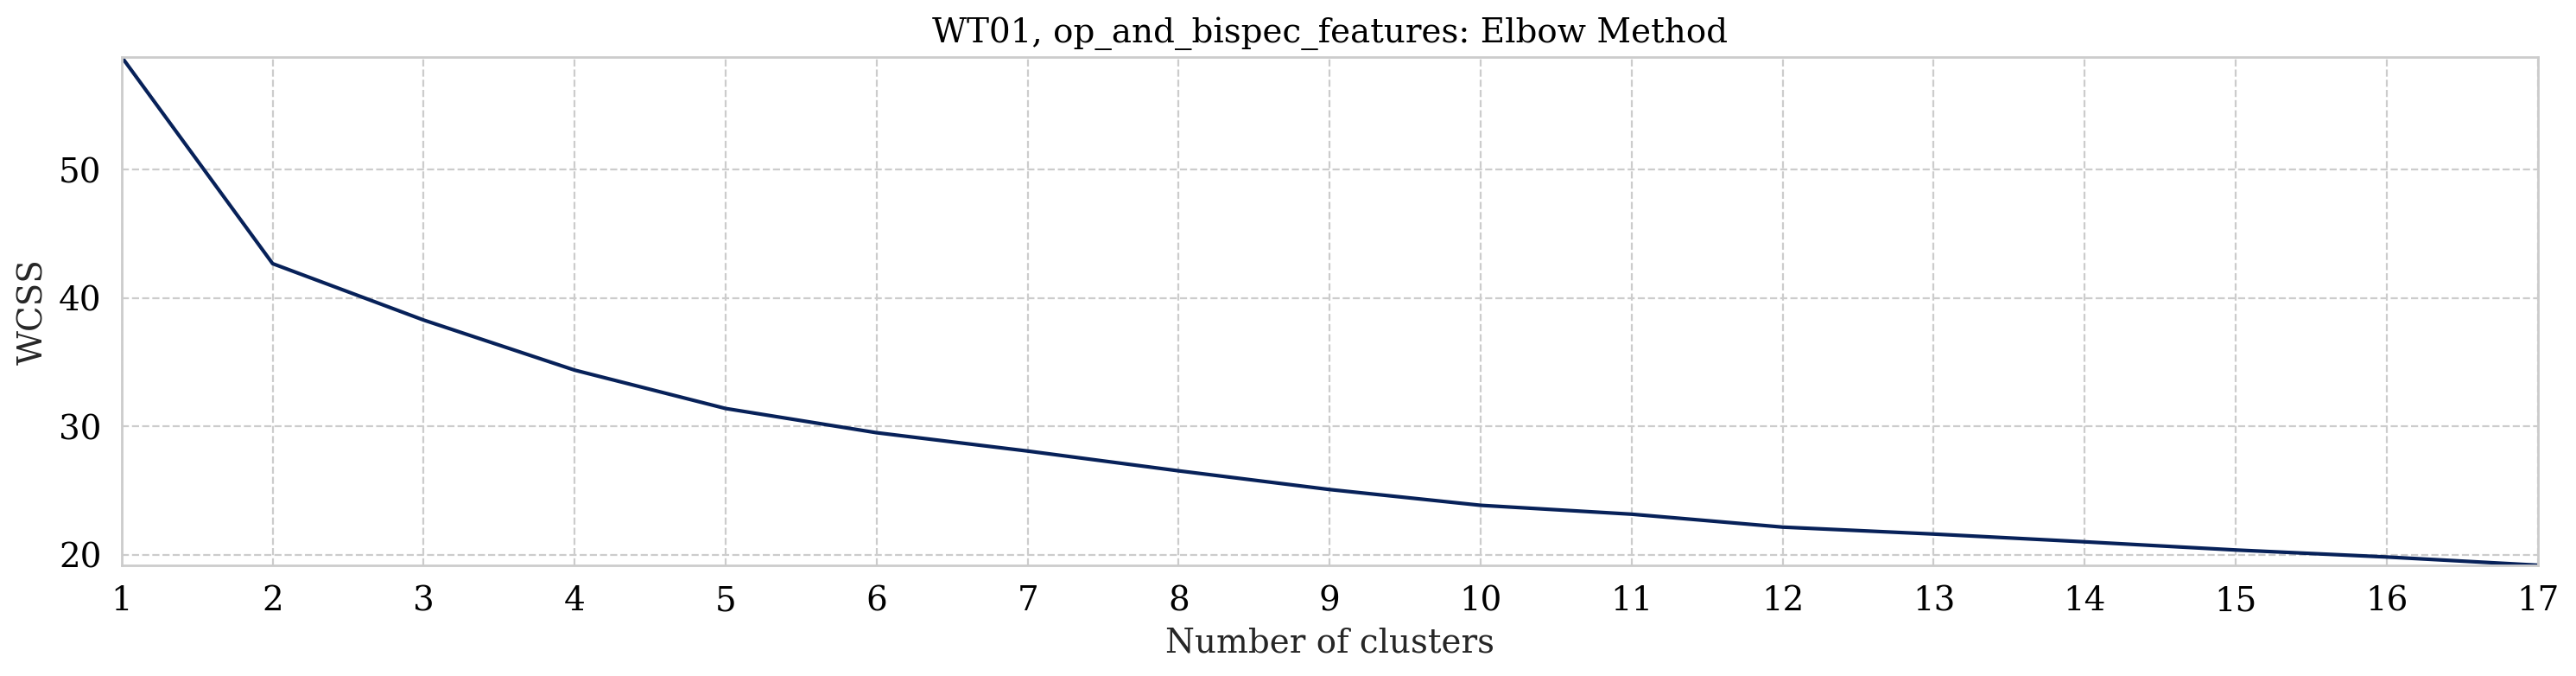

Did not replace


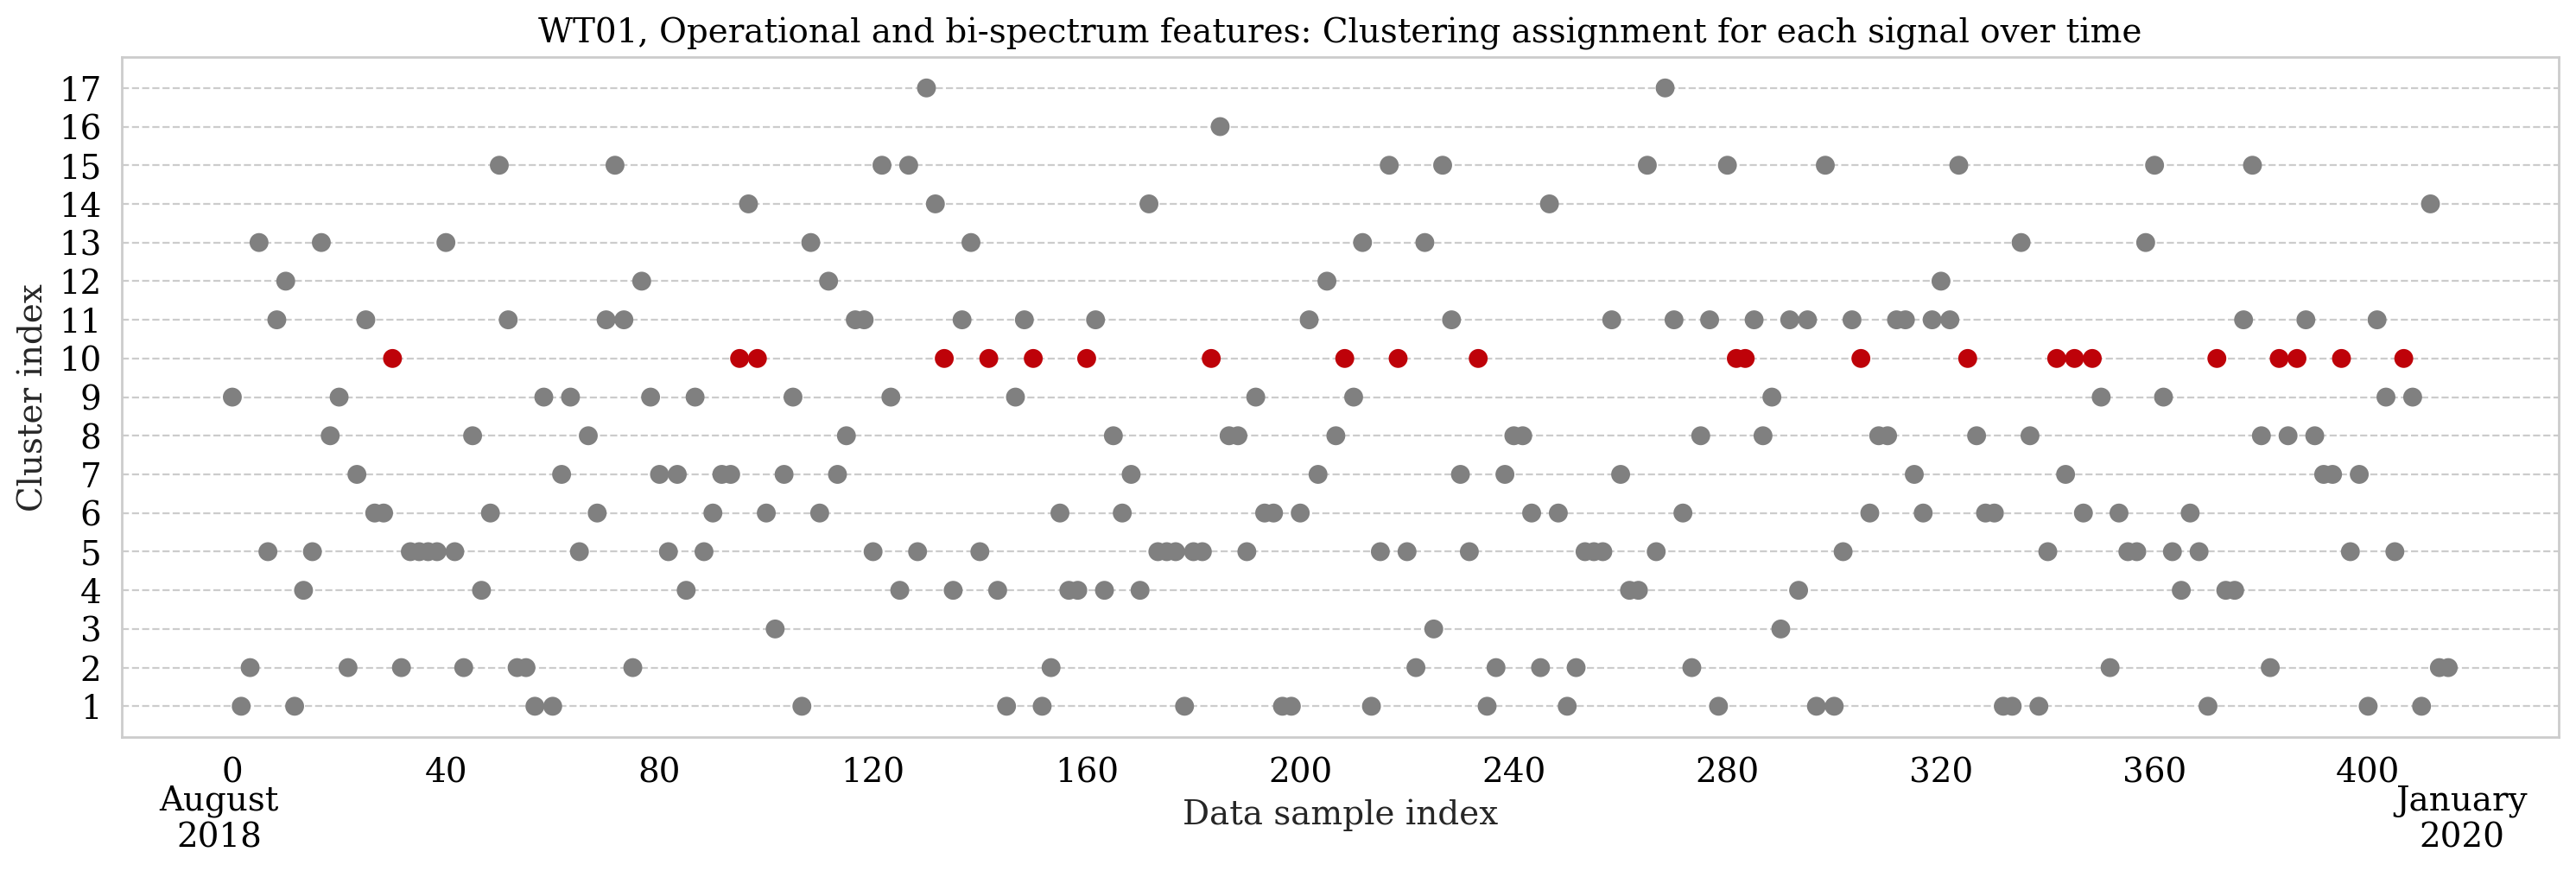

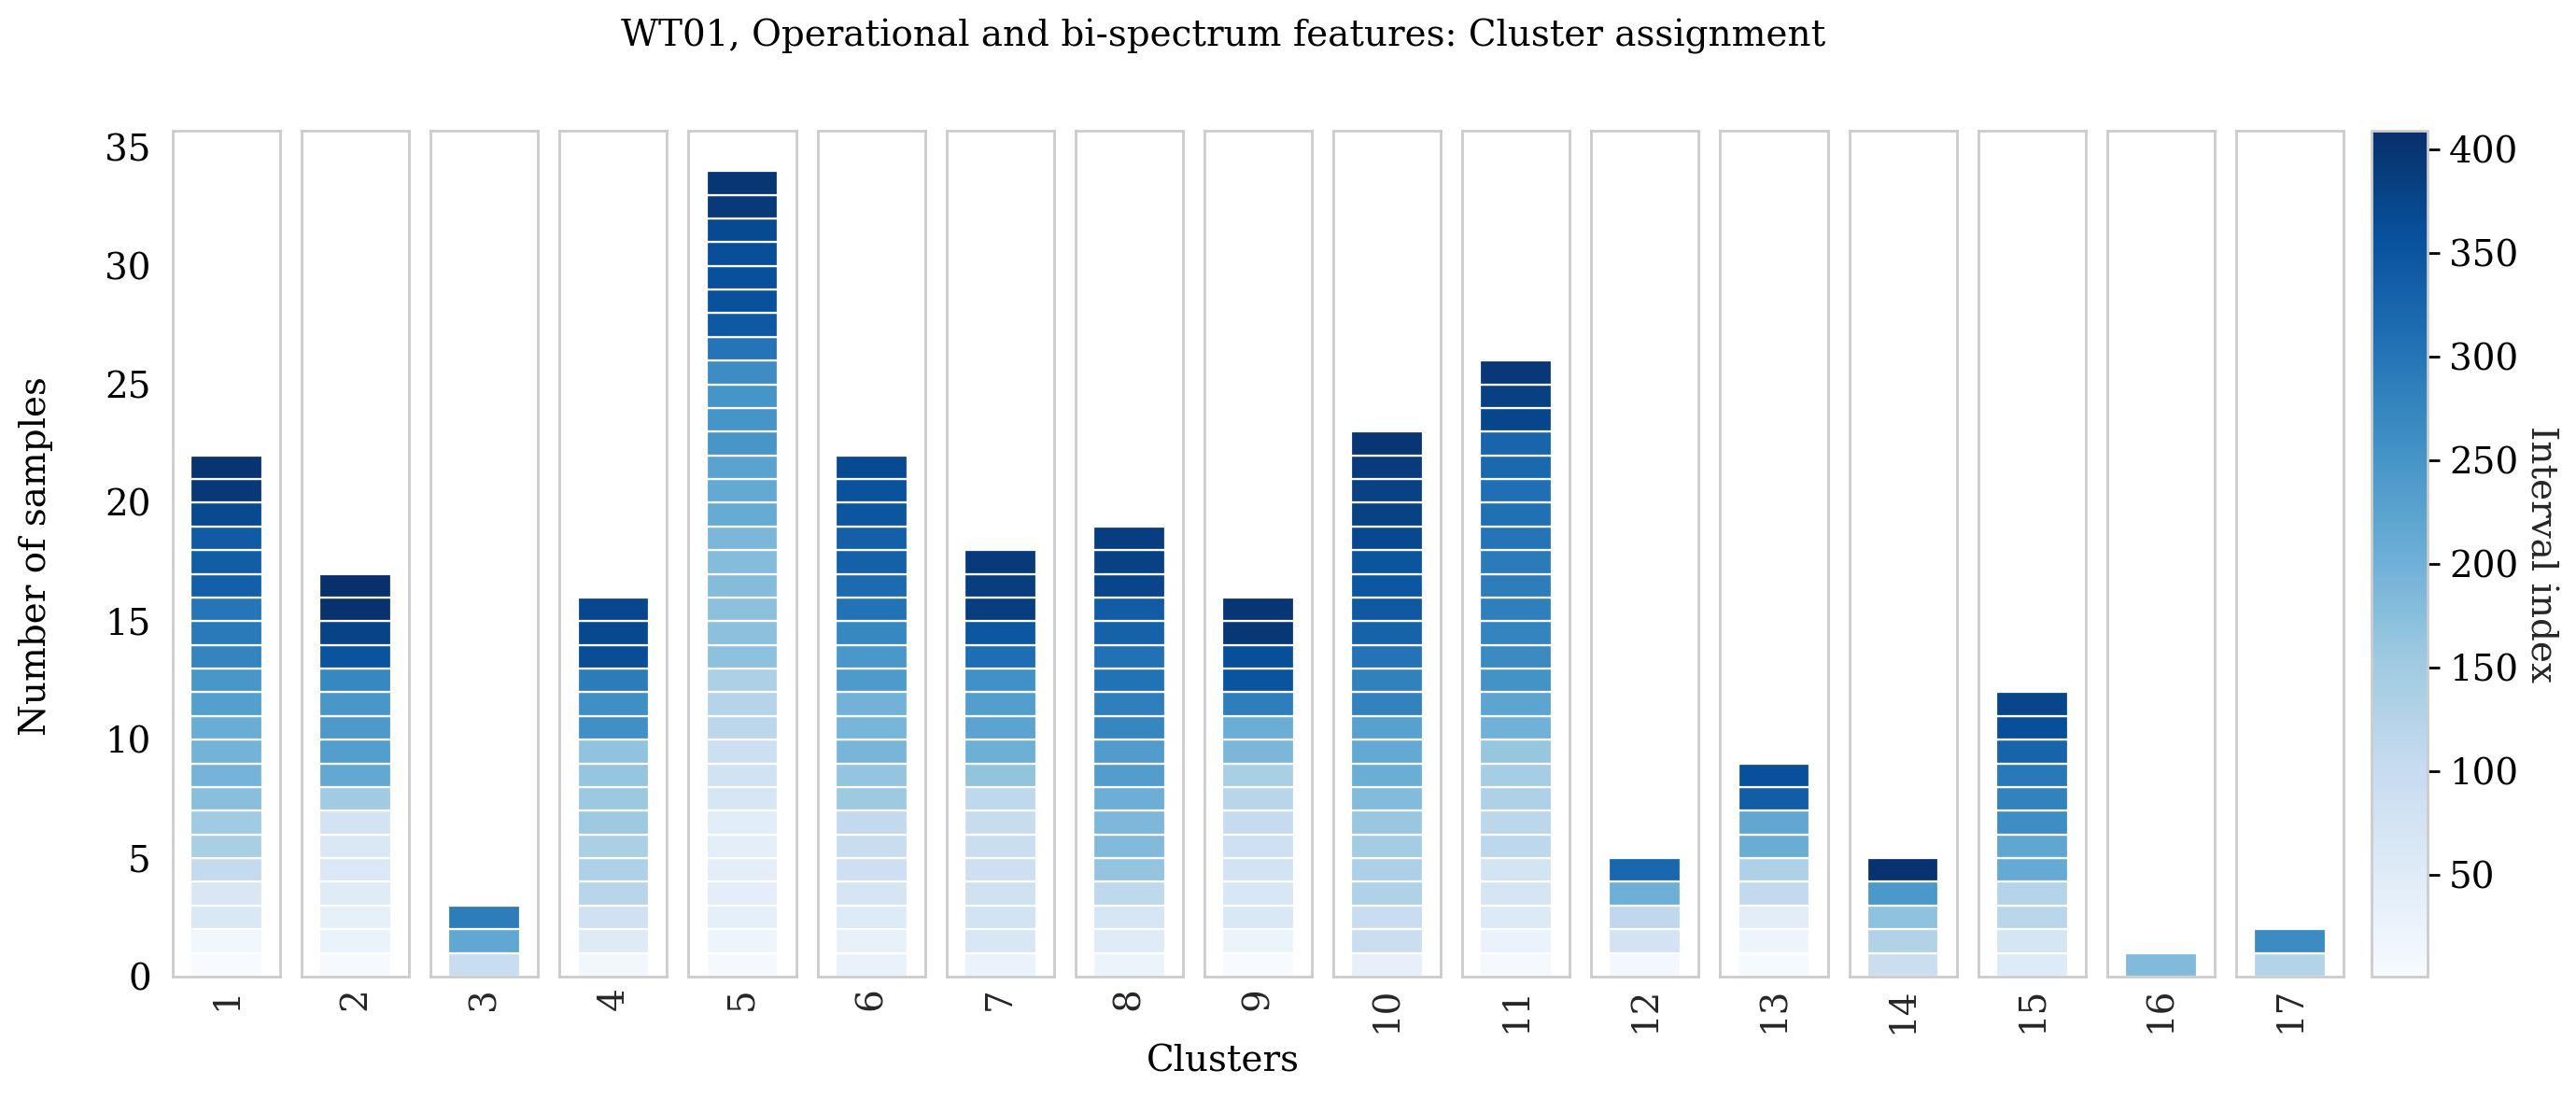

DIFFERENT HUES [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


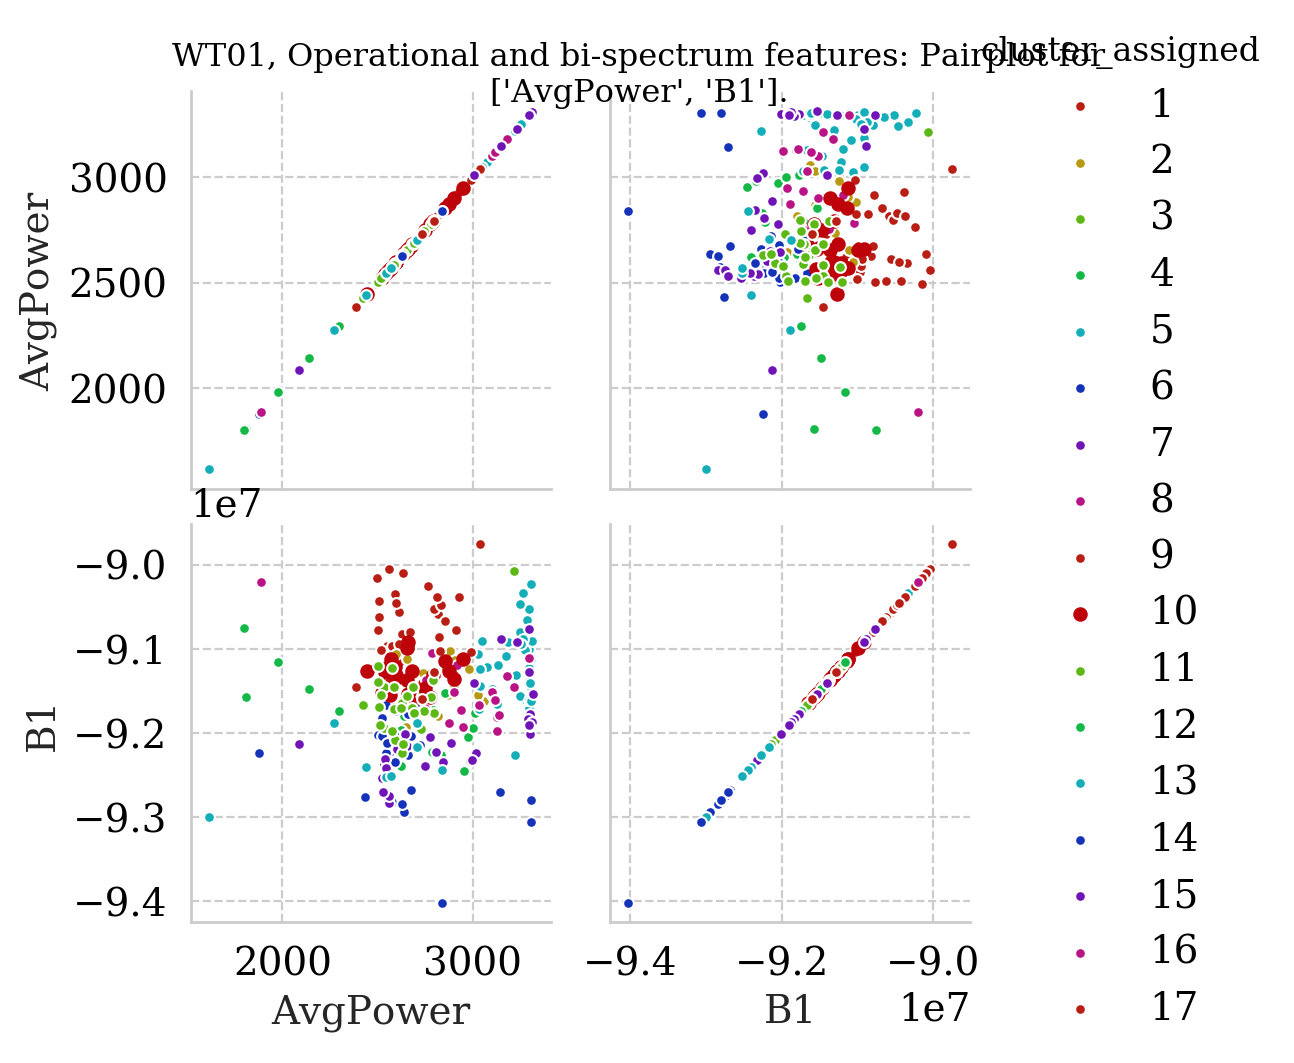

<span style="color: #2a9d8f; font-size: 20px">op_and_time_features:</span>

THIS IS THE SELECTED CLUSTER: 0
Marker-styles not there.


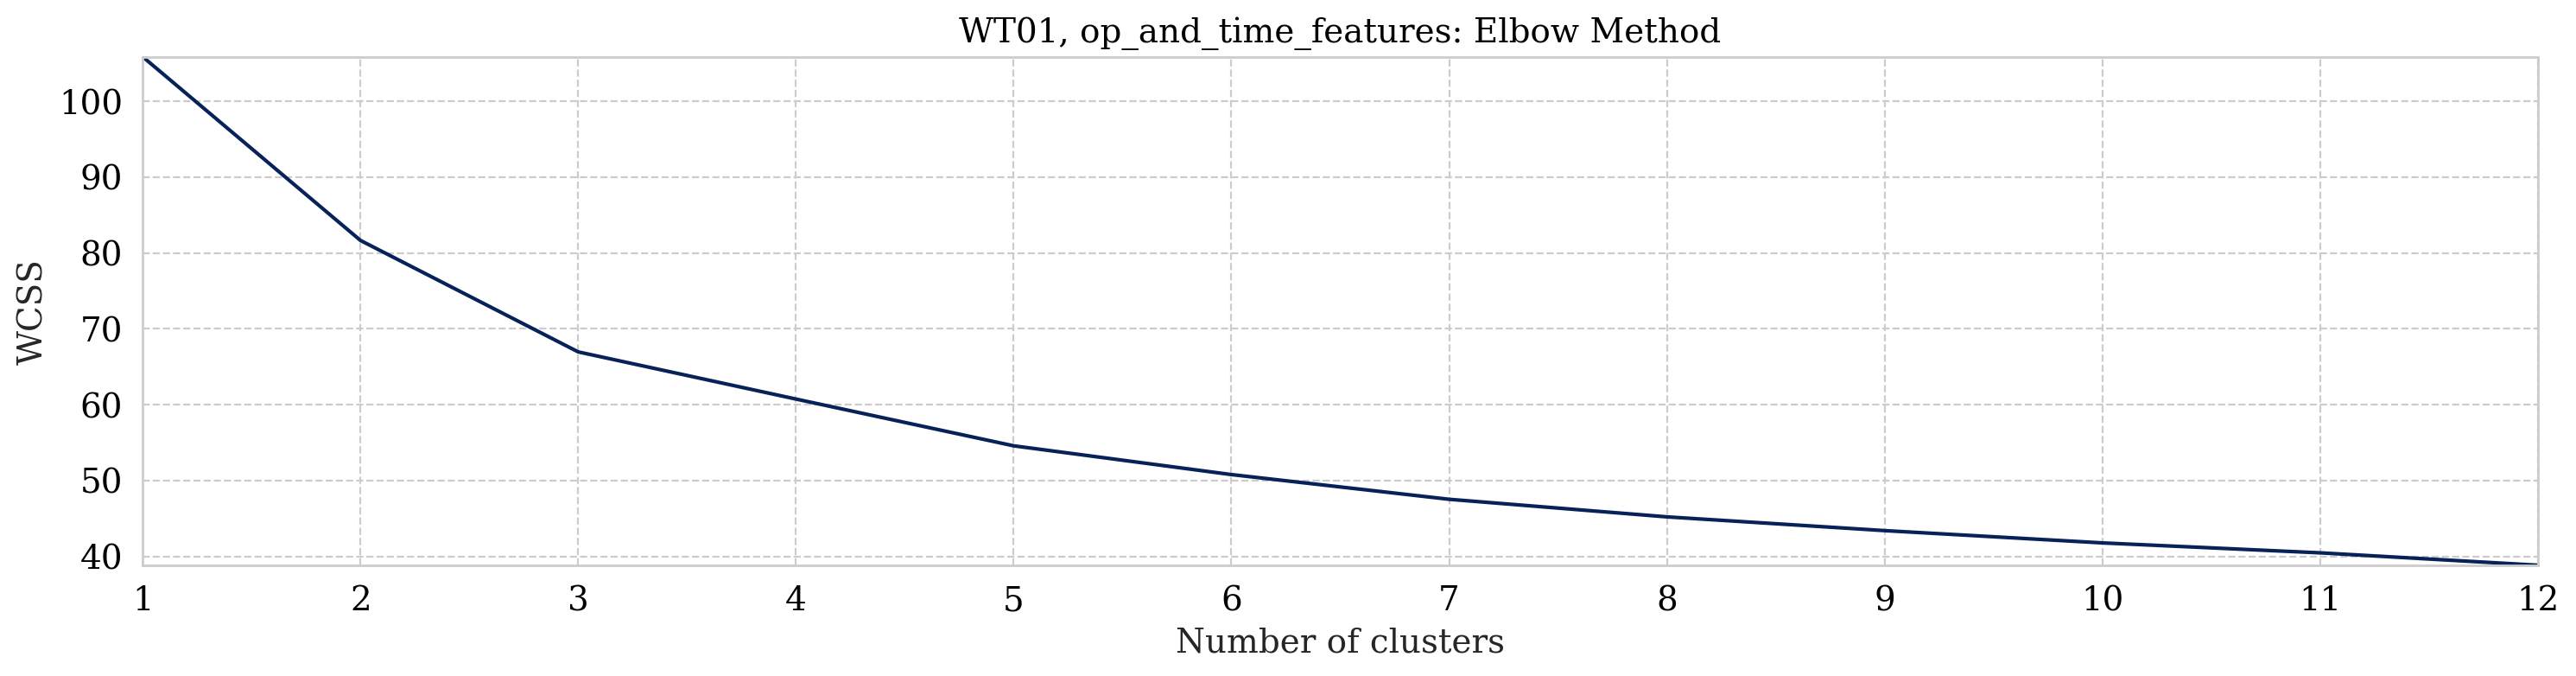

Did not replace


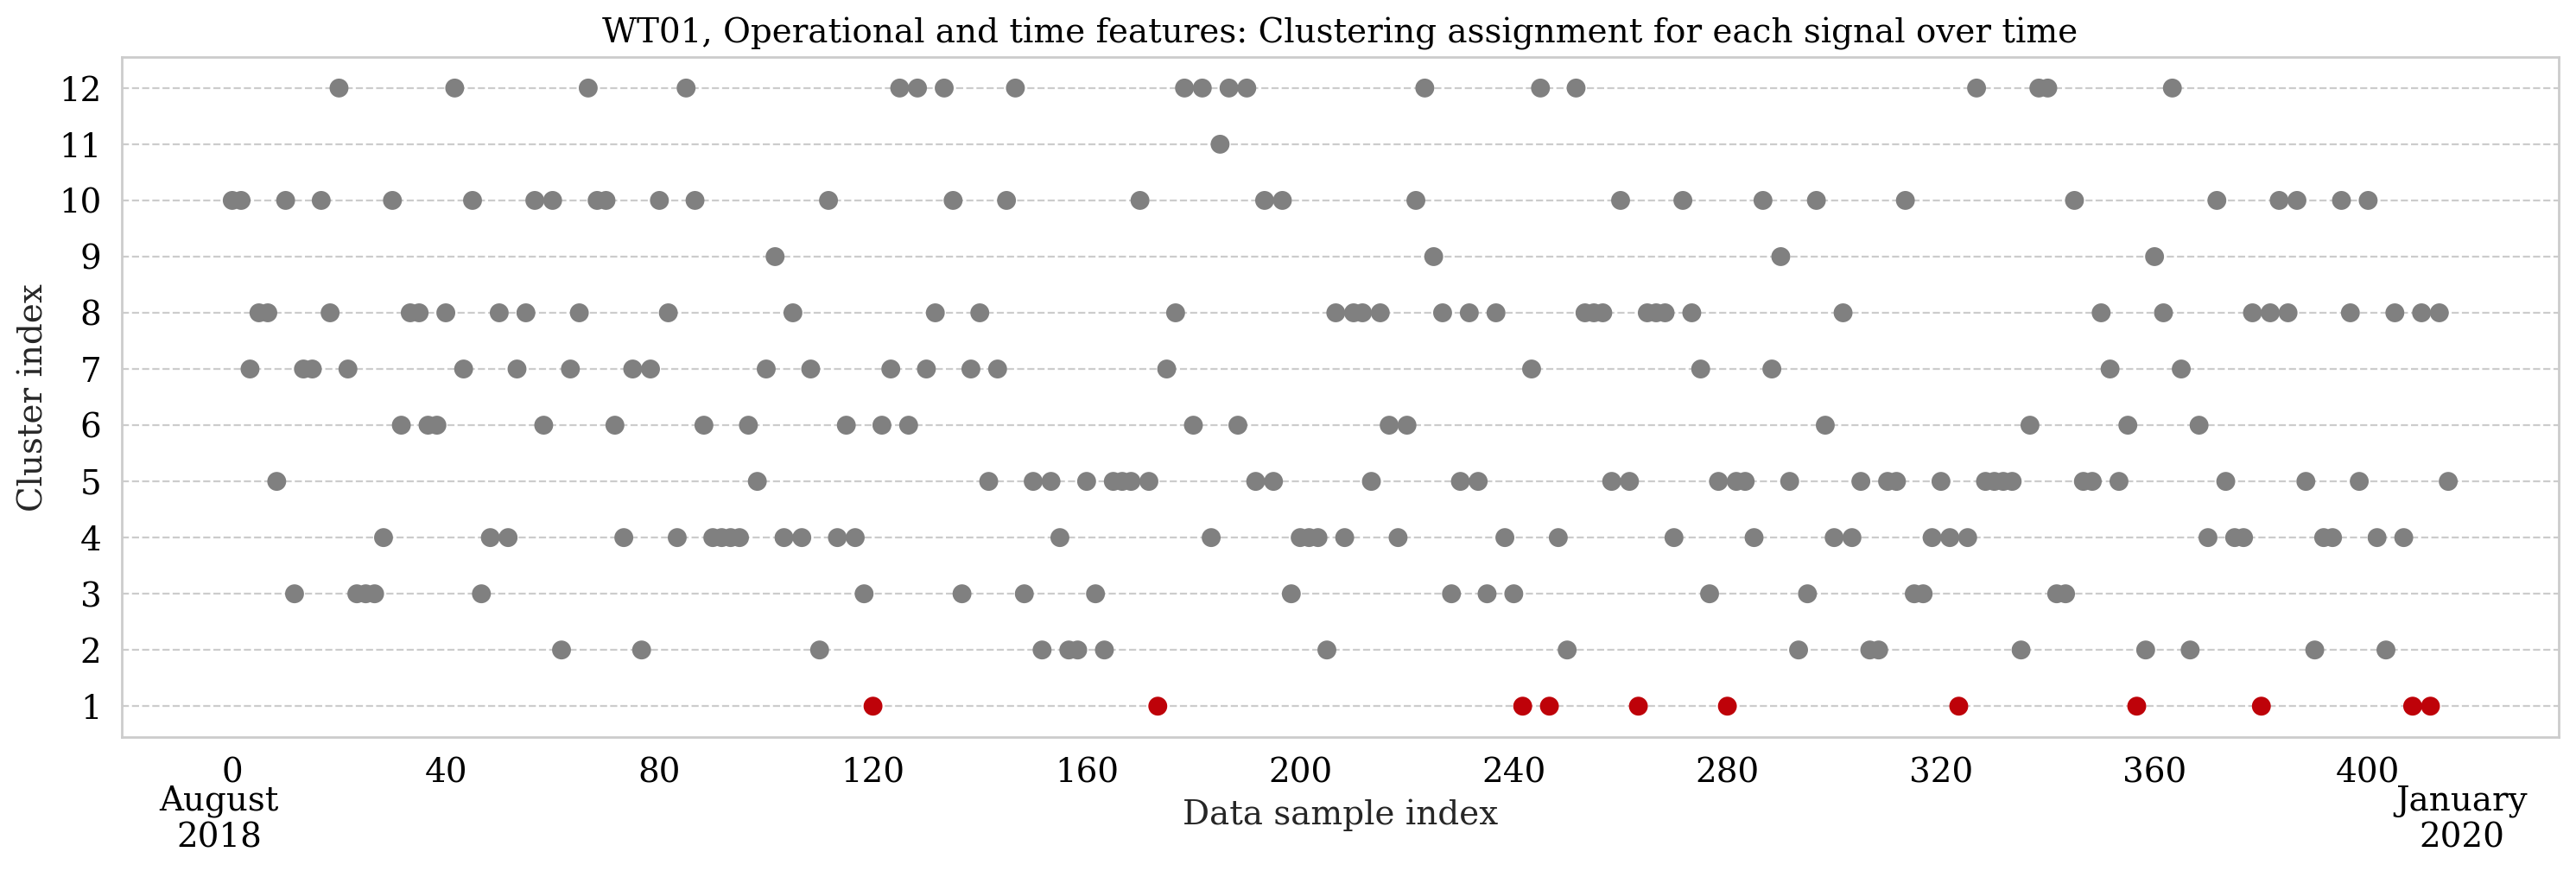

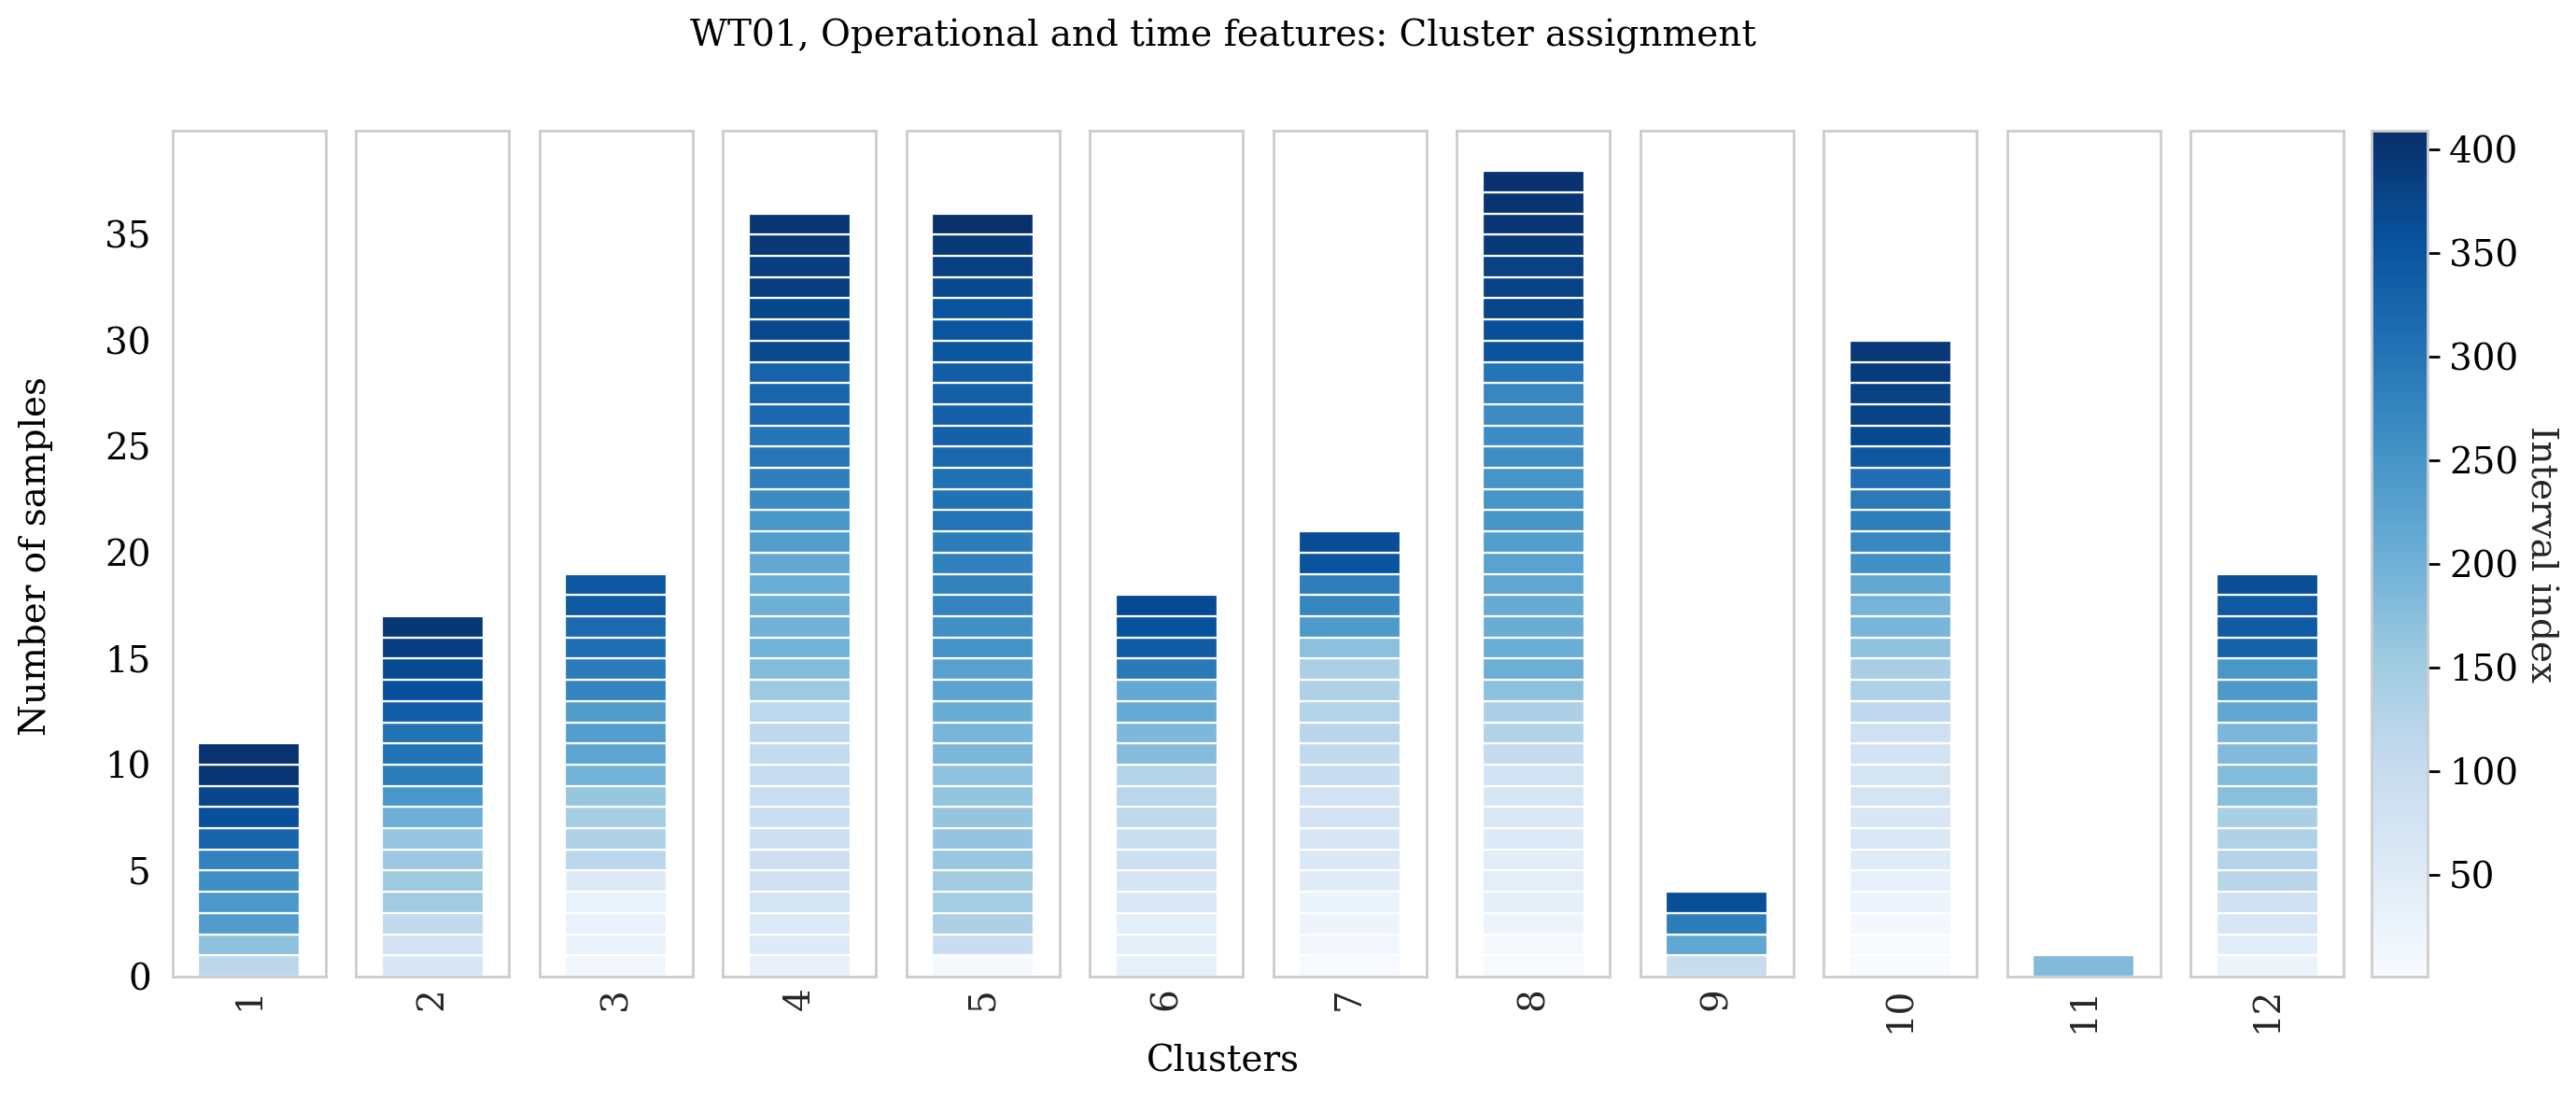

DIFFERENT HUES [ 1  2  3  4  5  6  7  8  9 10 11 12]


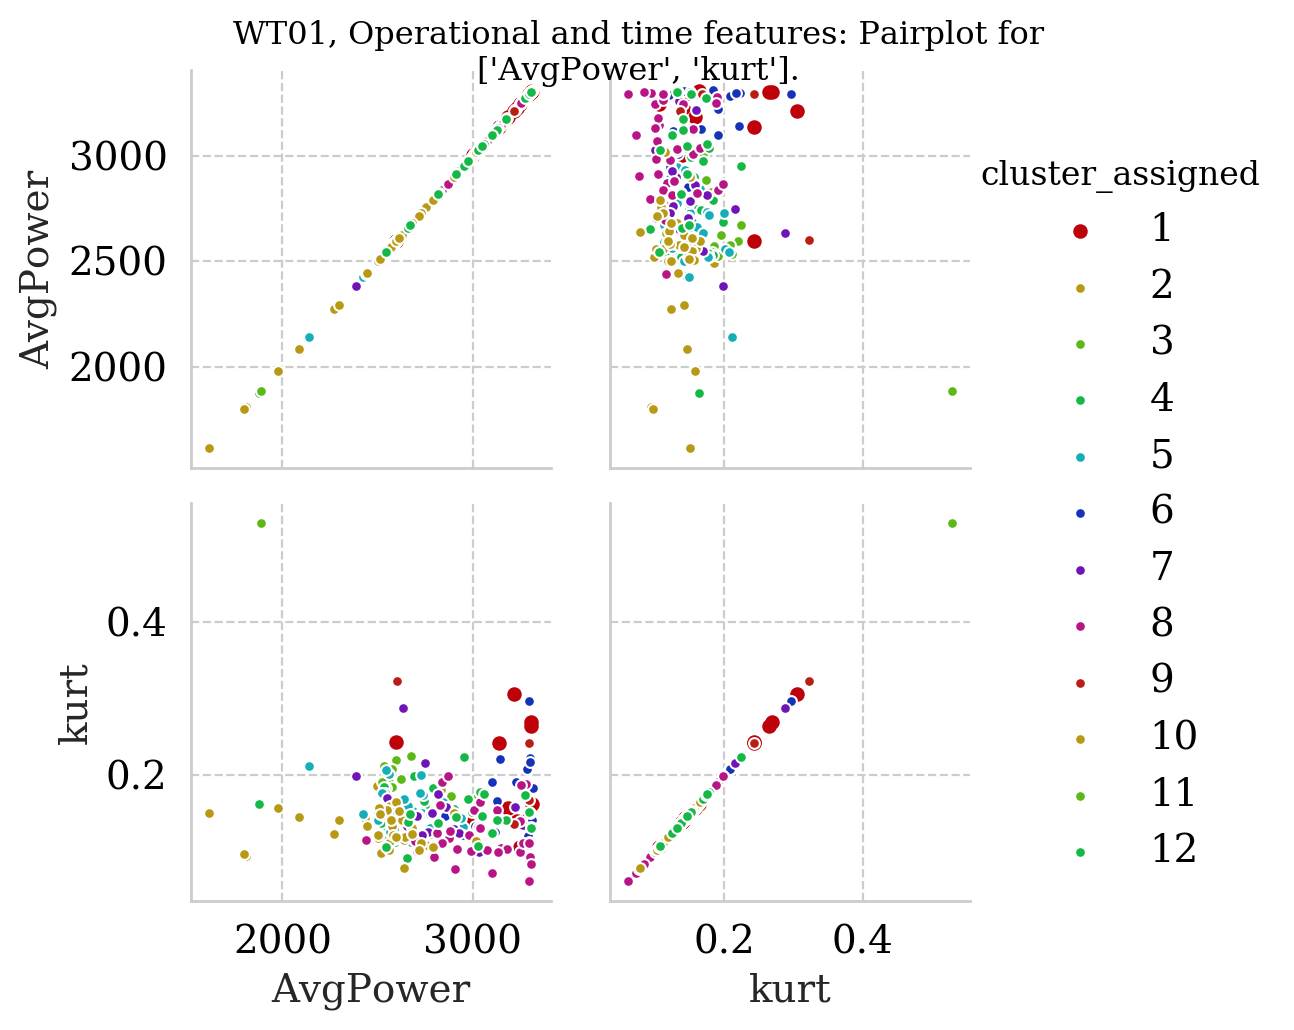

<span style="color: #2a9d8f; font-size: 20px">op_and_imf_kurtosis_features:</span>

THIS IS THE SELECTED CLUSTER: 10
Marker-styles not there.


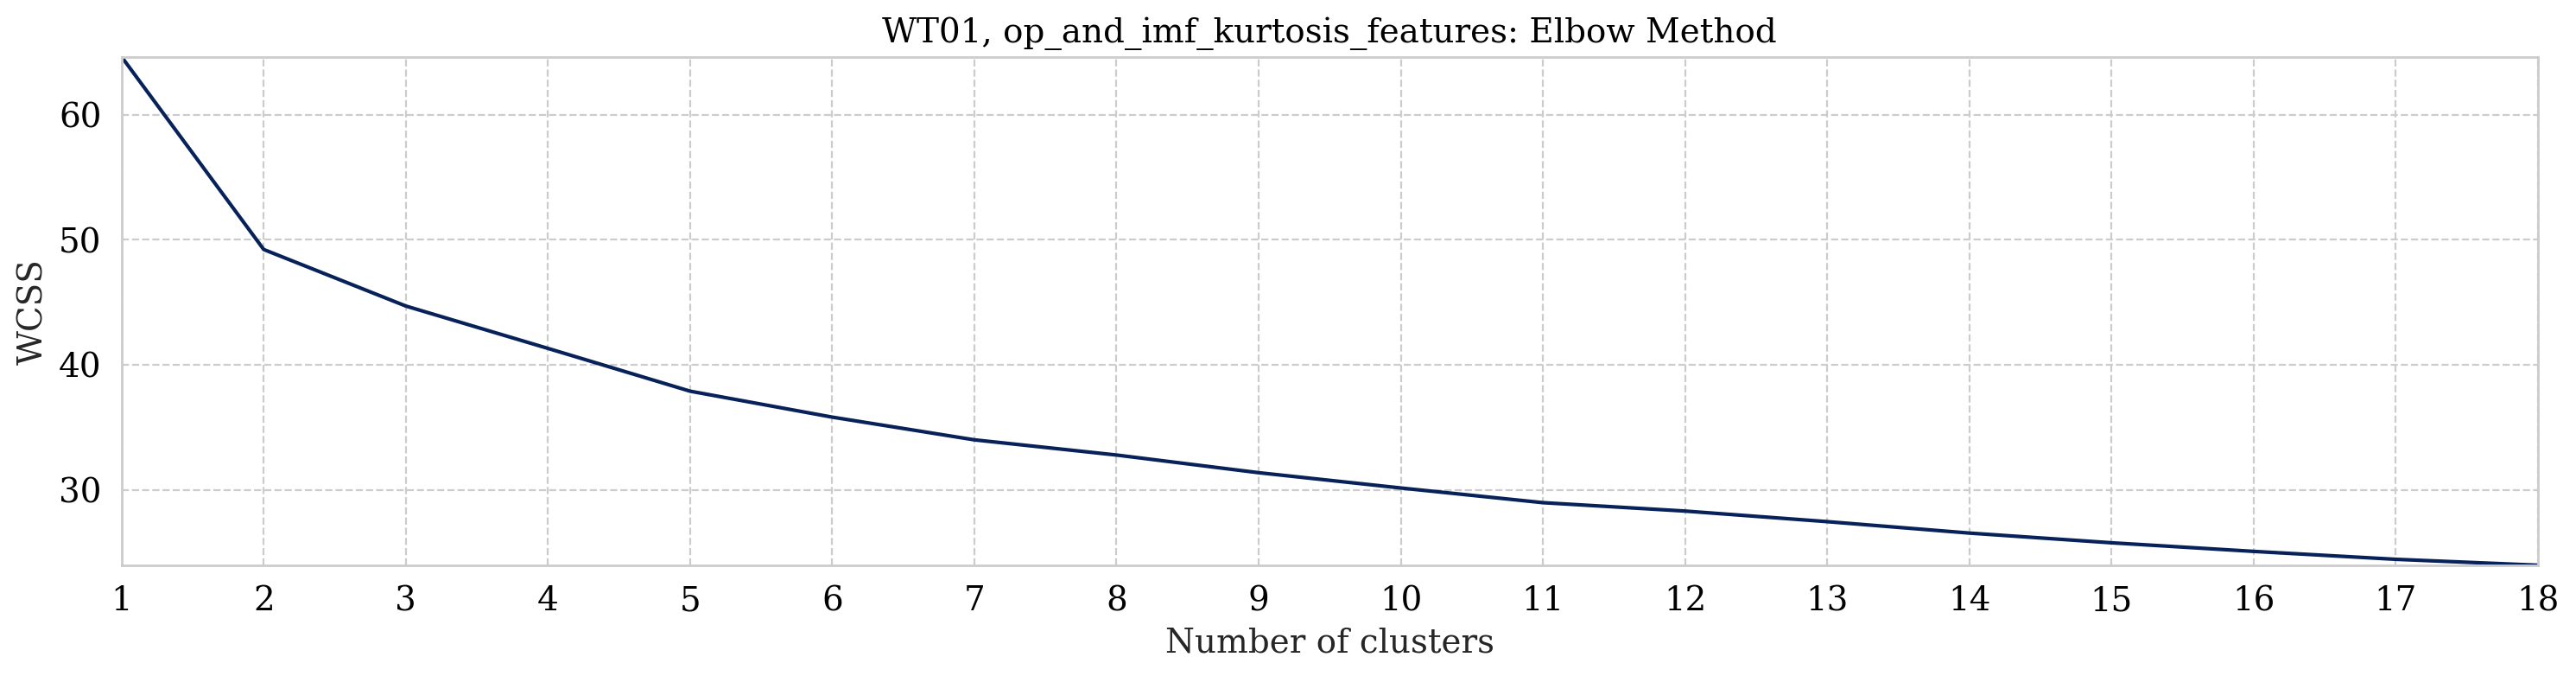

Did not replace


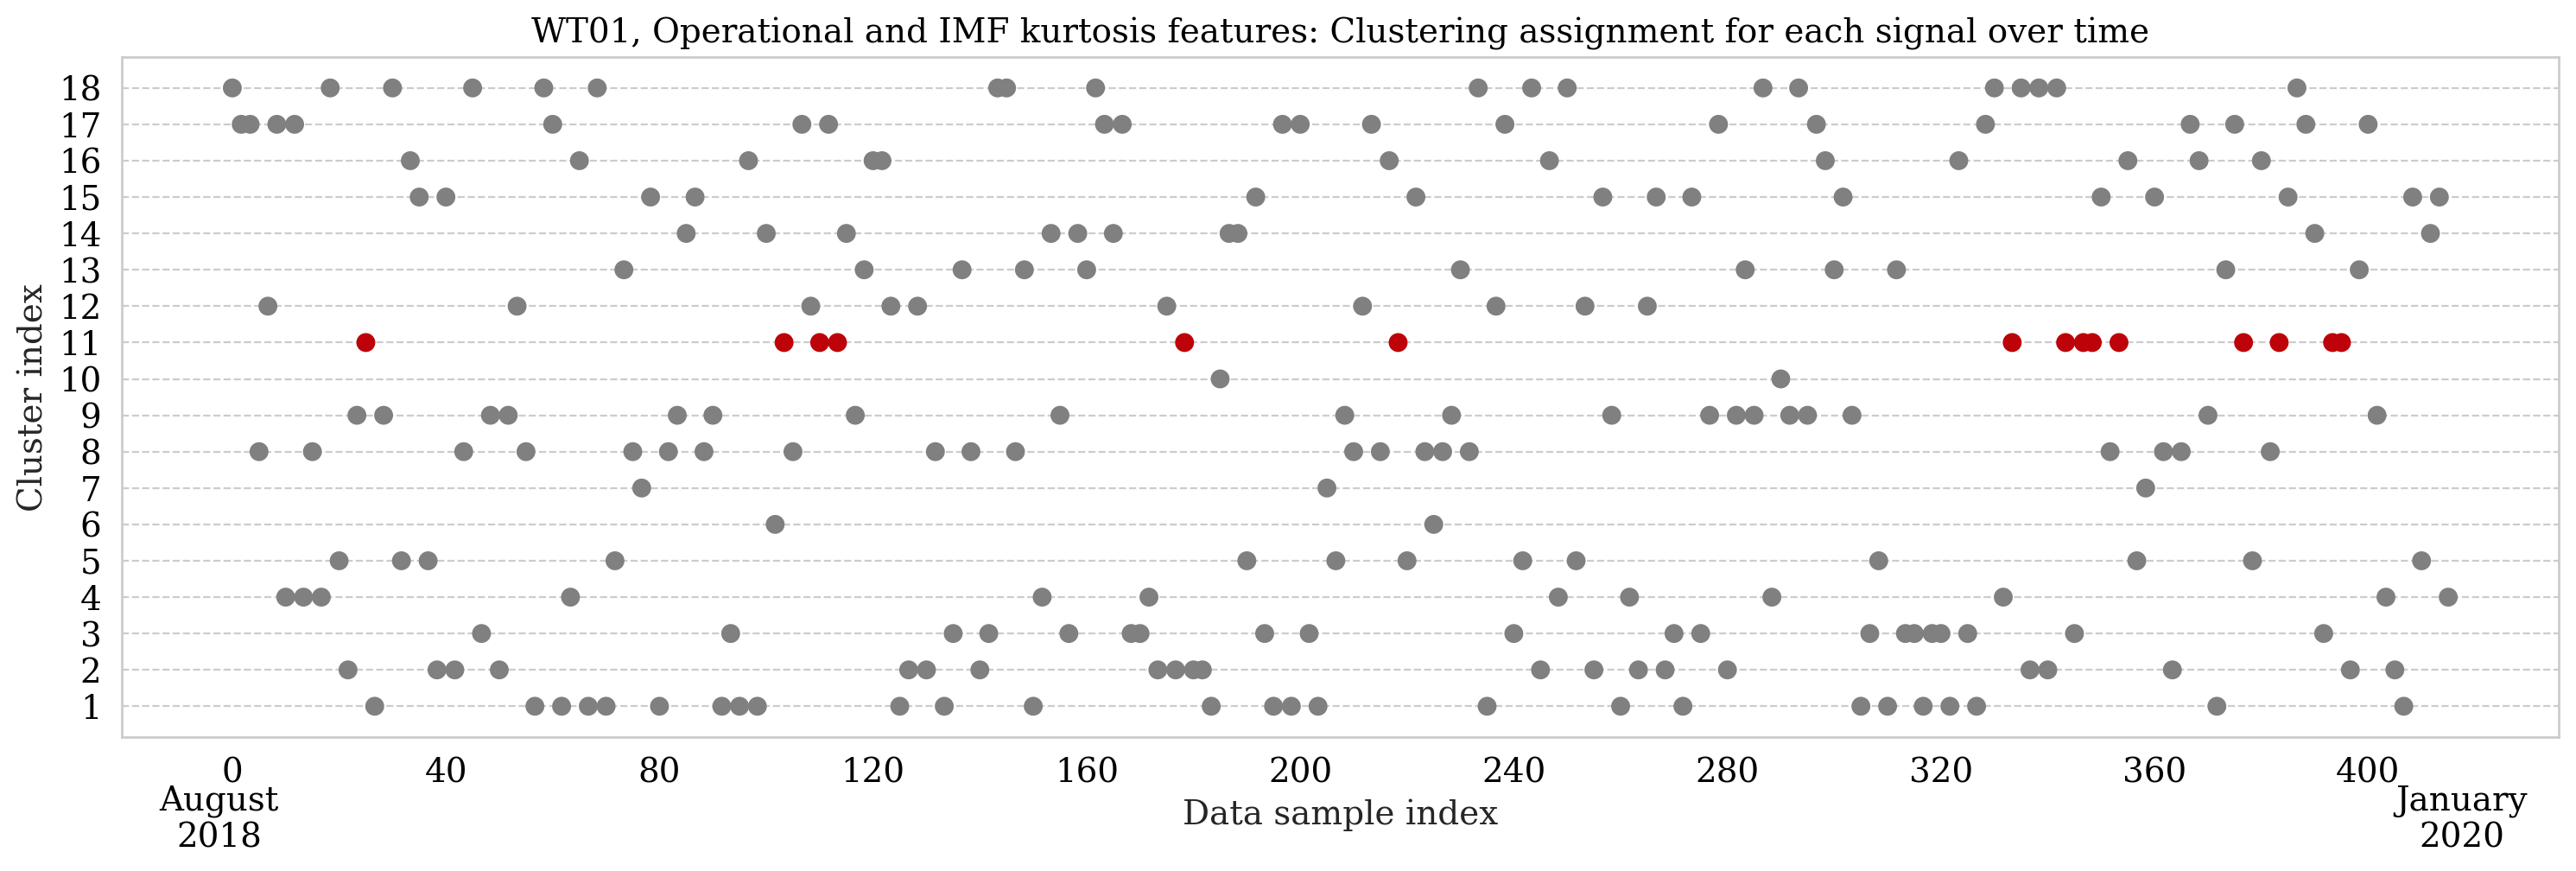

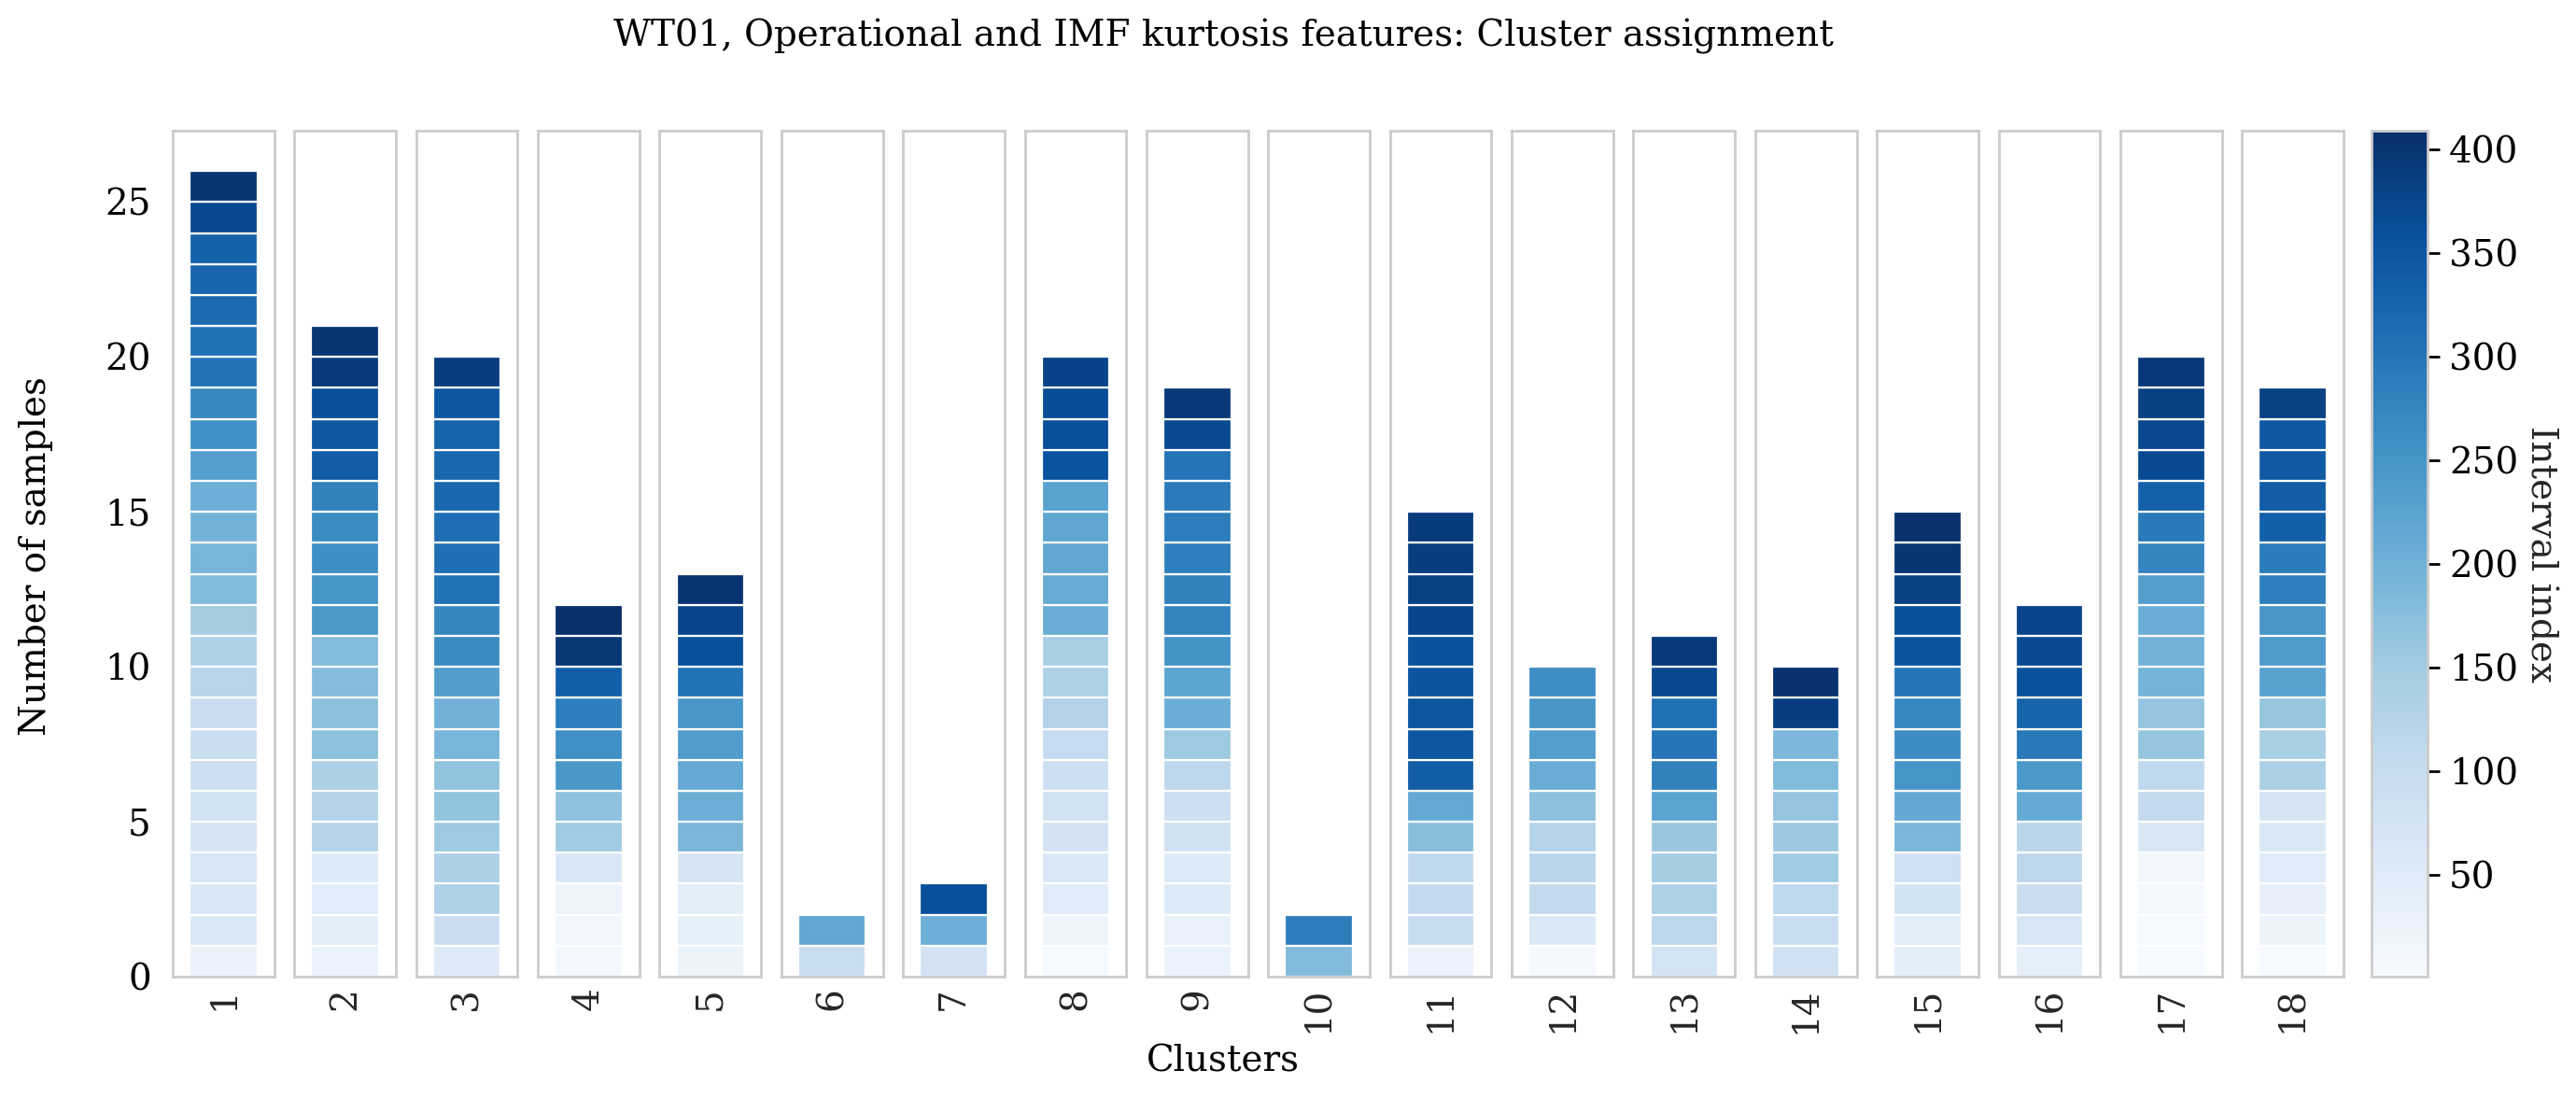

DIFFERENT HUES [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]


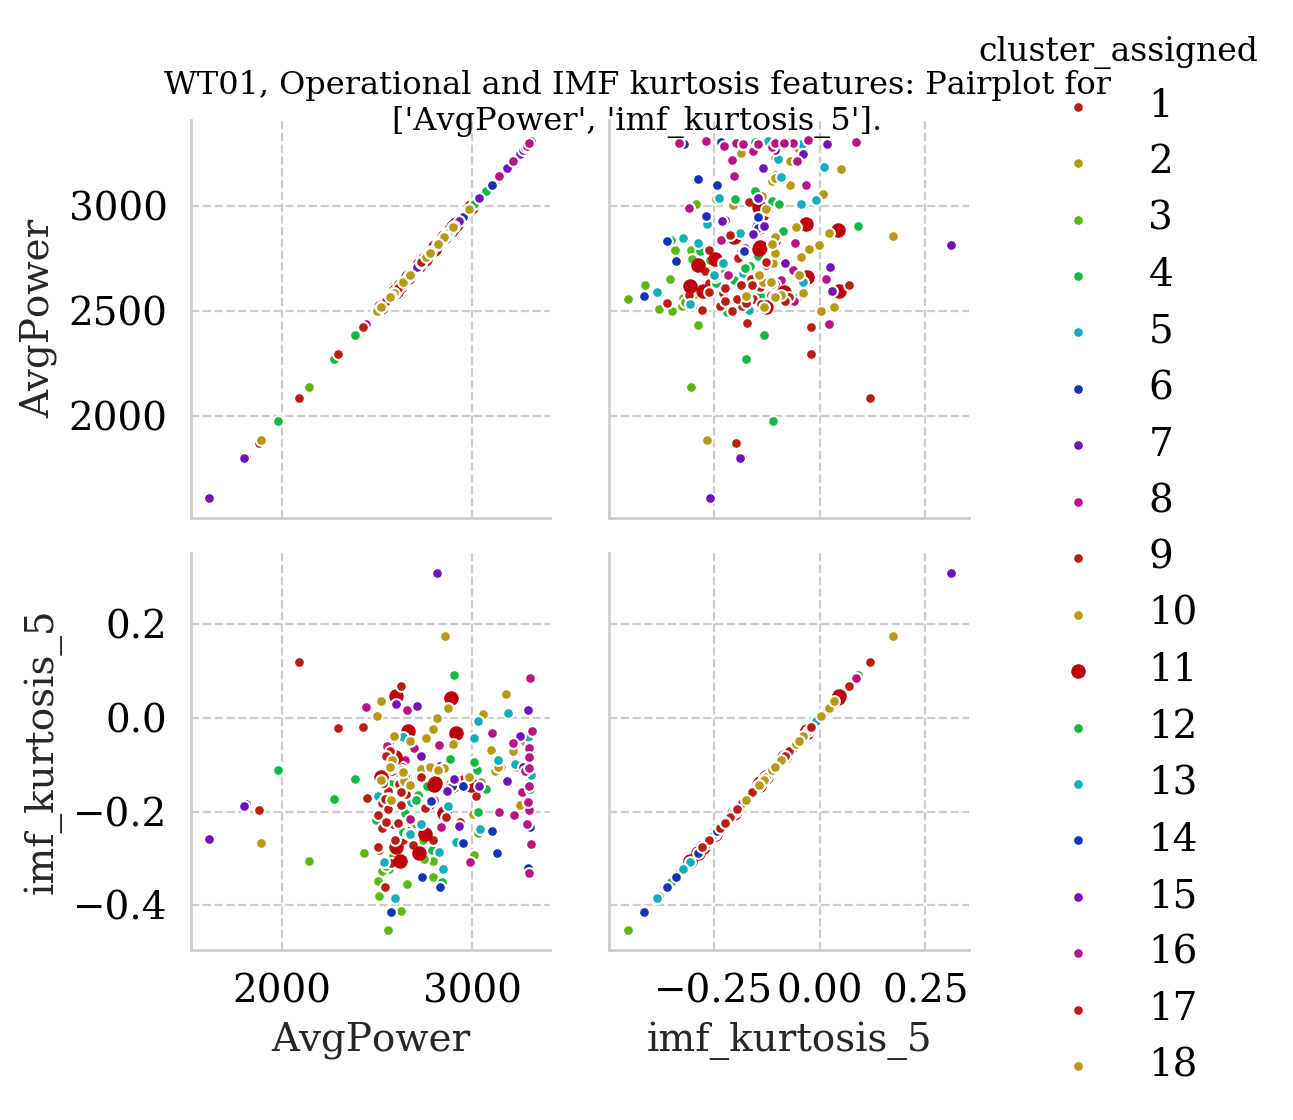

<span style="color: #2a9d8f; font-size: 20px">op_and_imf_features:</span>

THIS IS THE SELECTED CLUSTER: 0
Marker-styles not there.


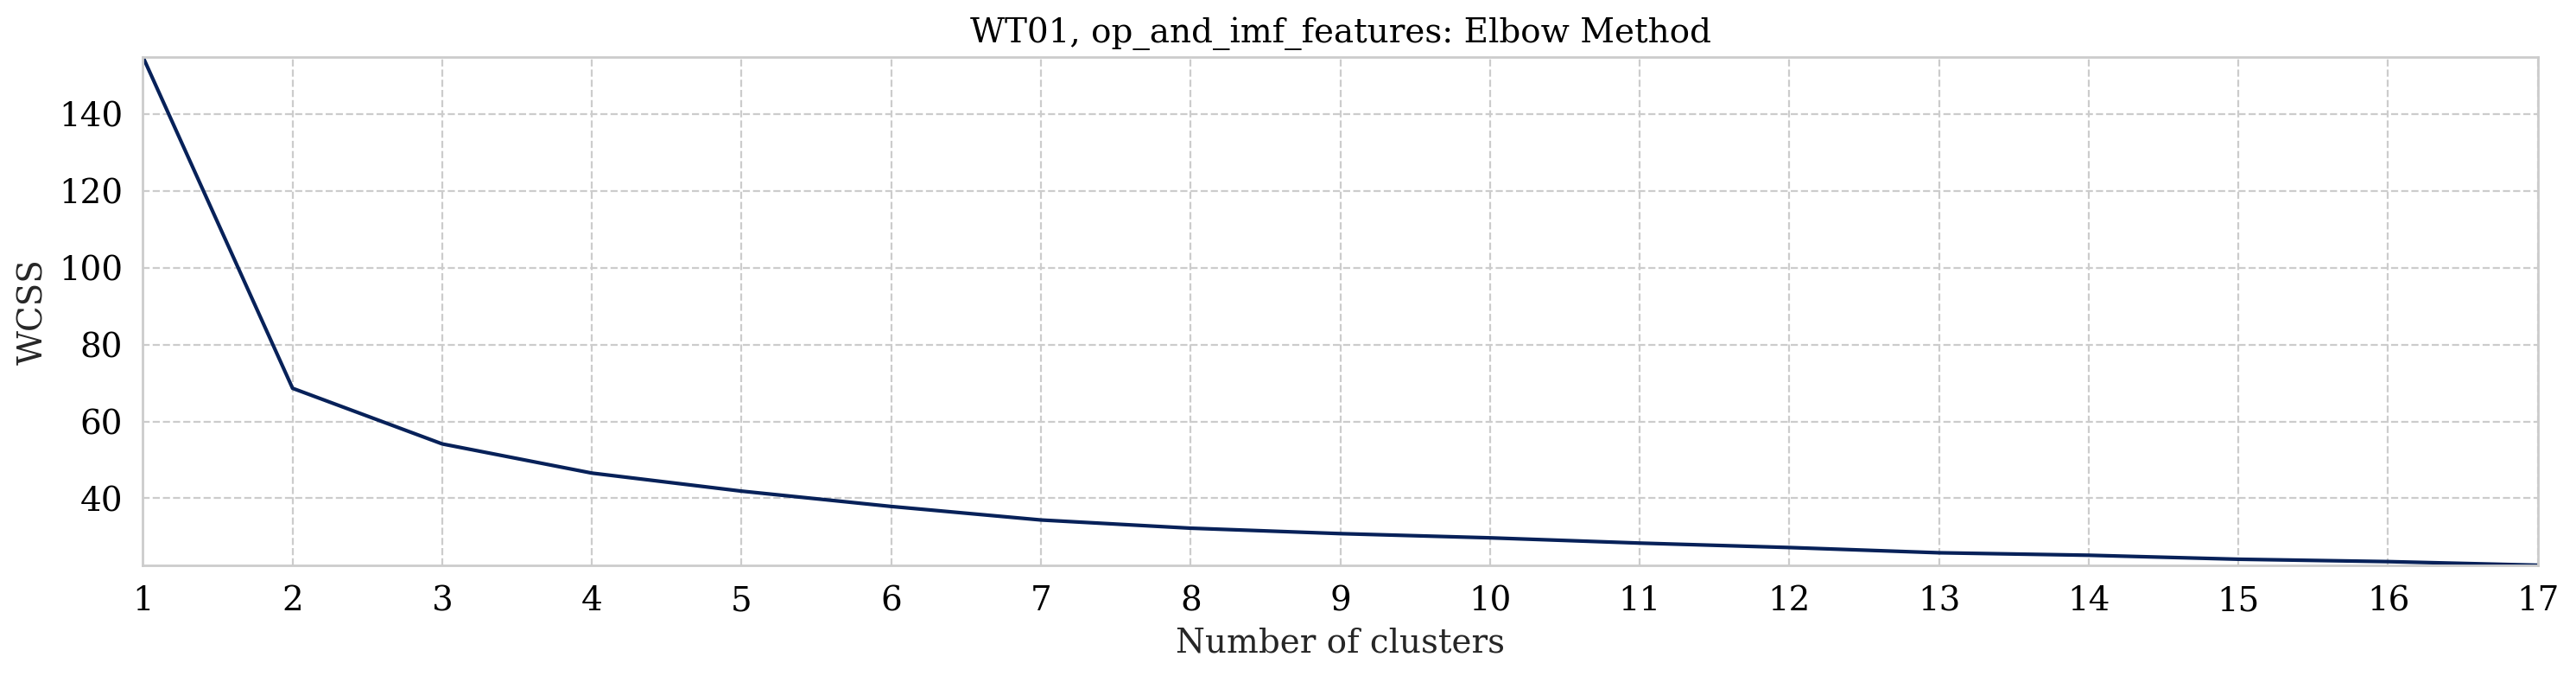

Did not replace


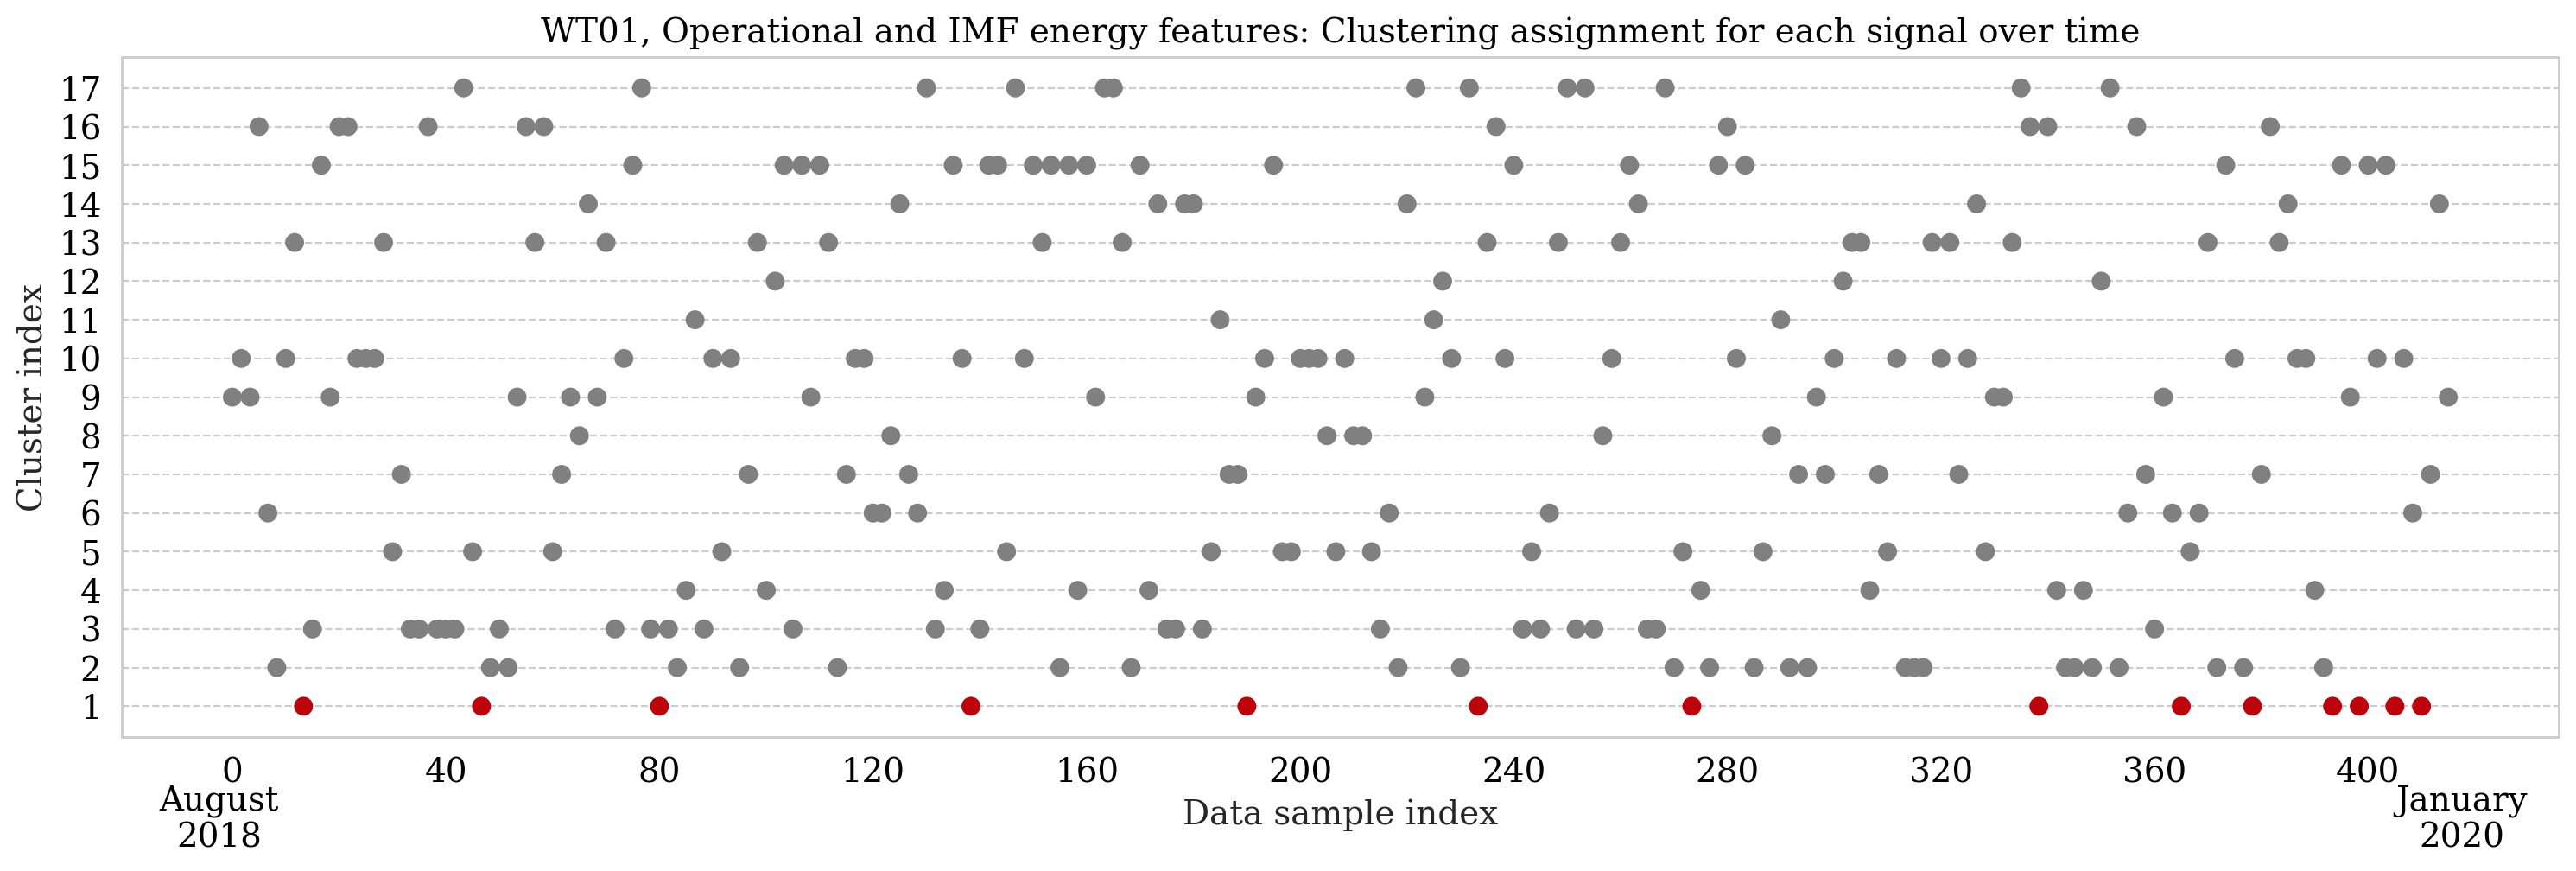

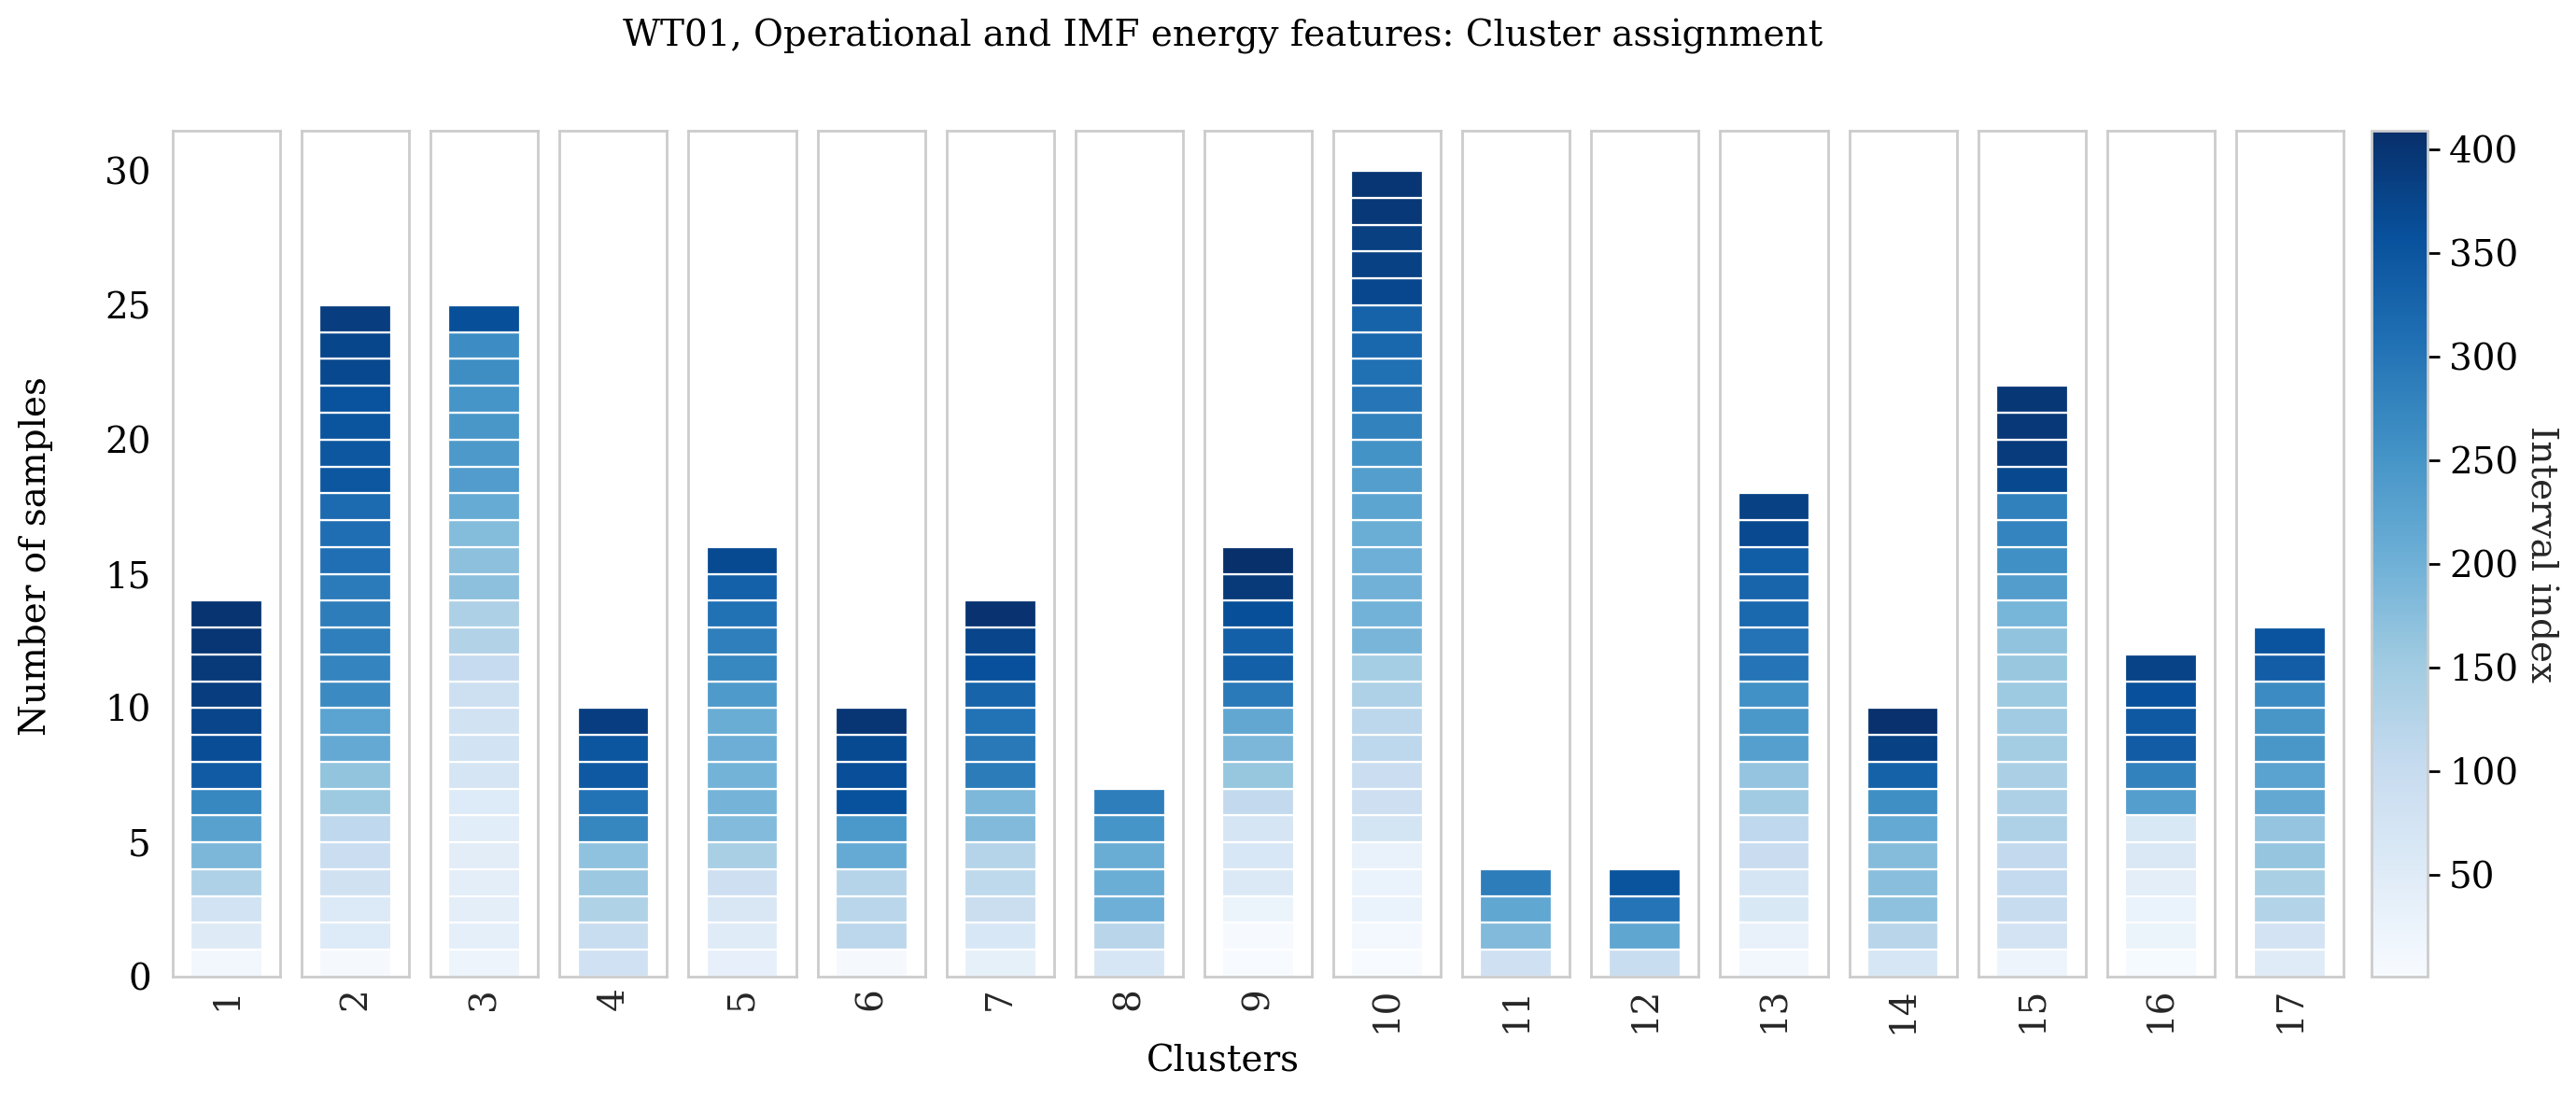

DIFFERENT HUES [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


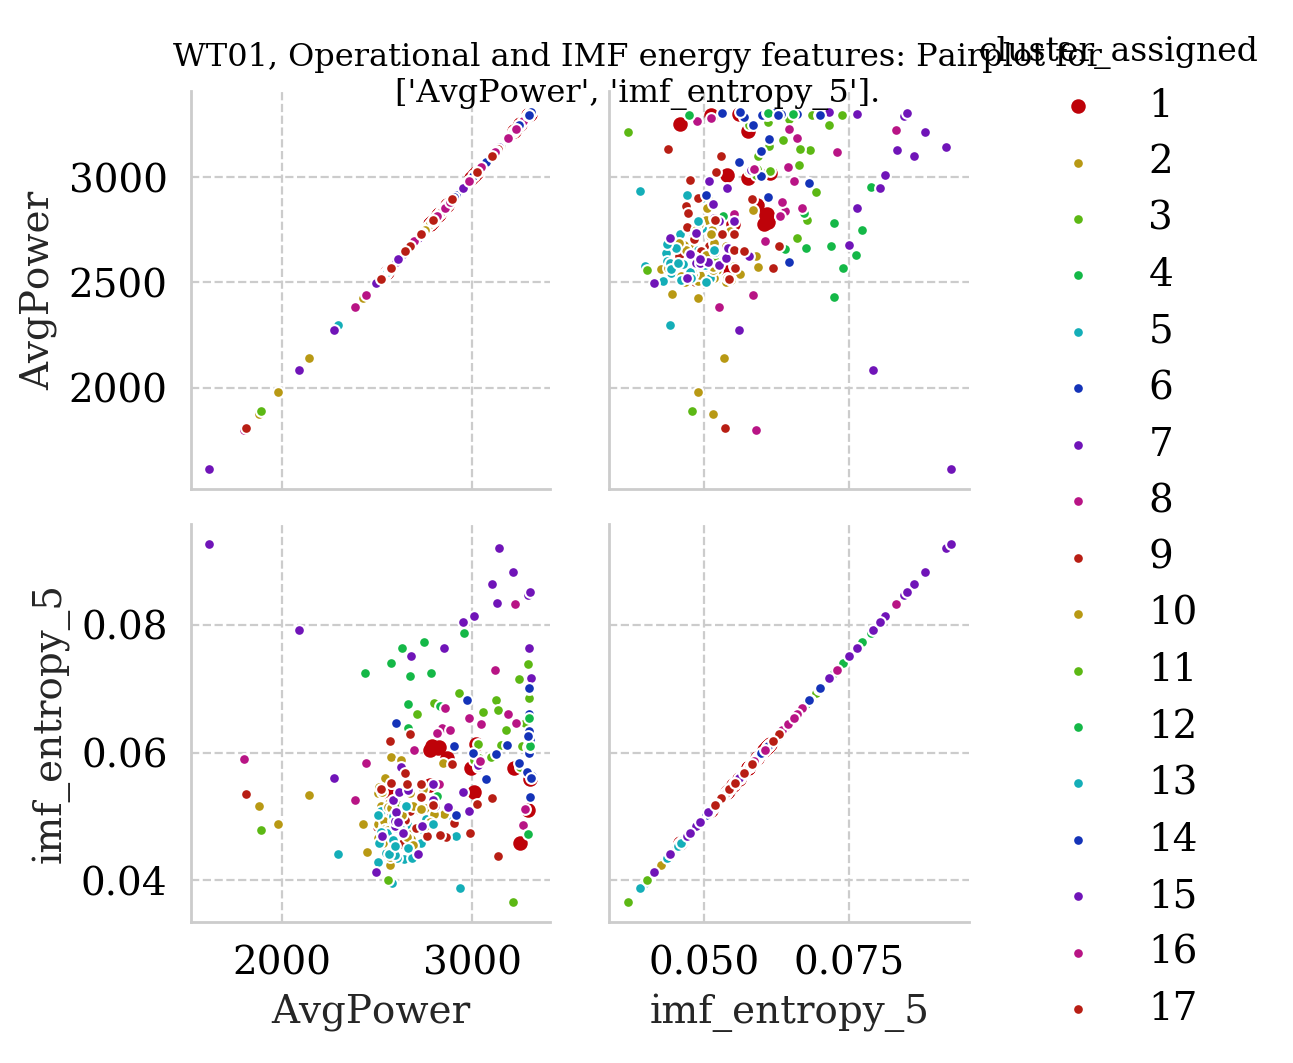

<span style="color: #2a9d8f; font-size: 20px">feature_mix:</span>

THIS IS THE SELECTED CLUSTER: 16
Marker-styles not there.


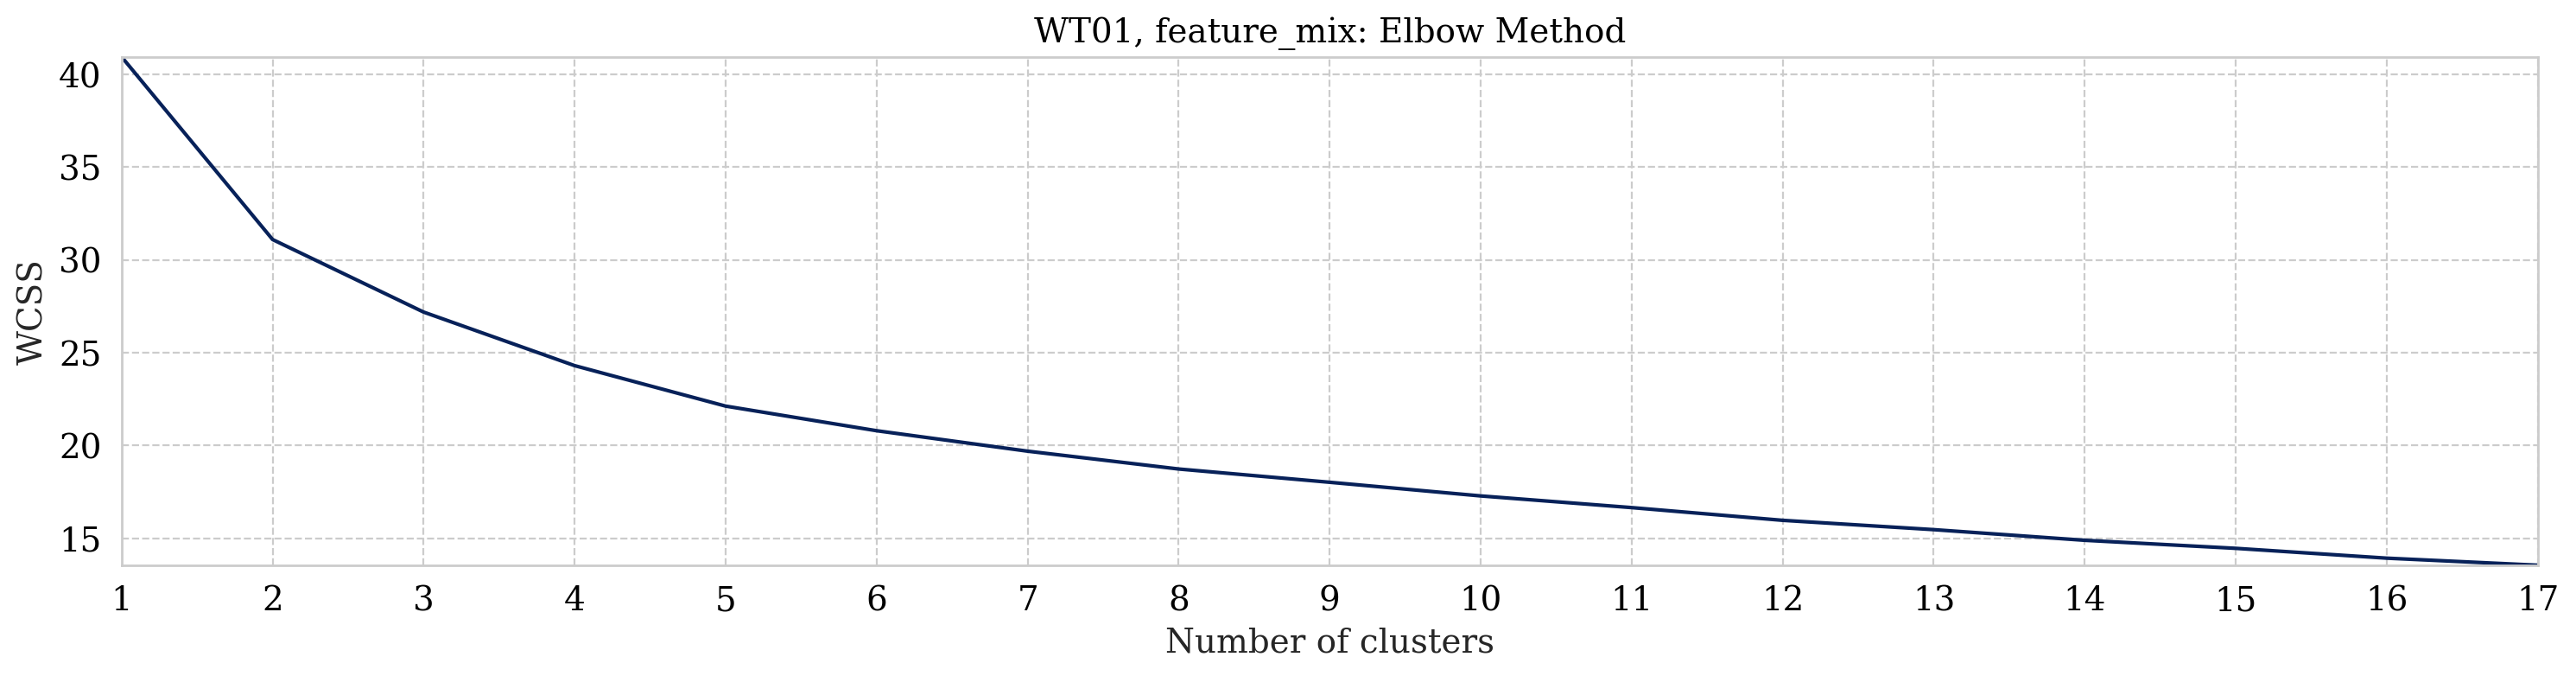

Did not replace


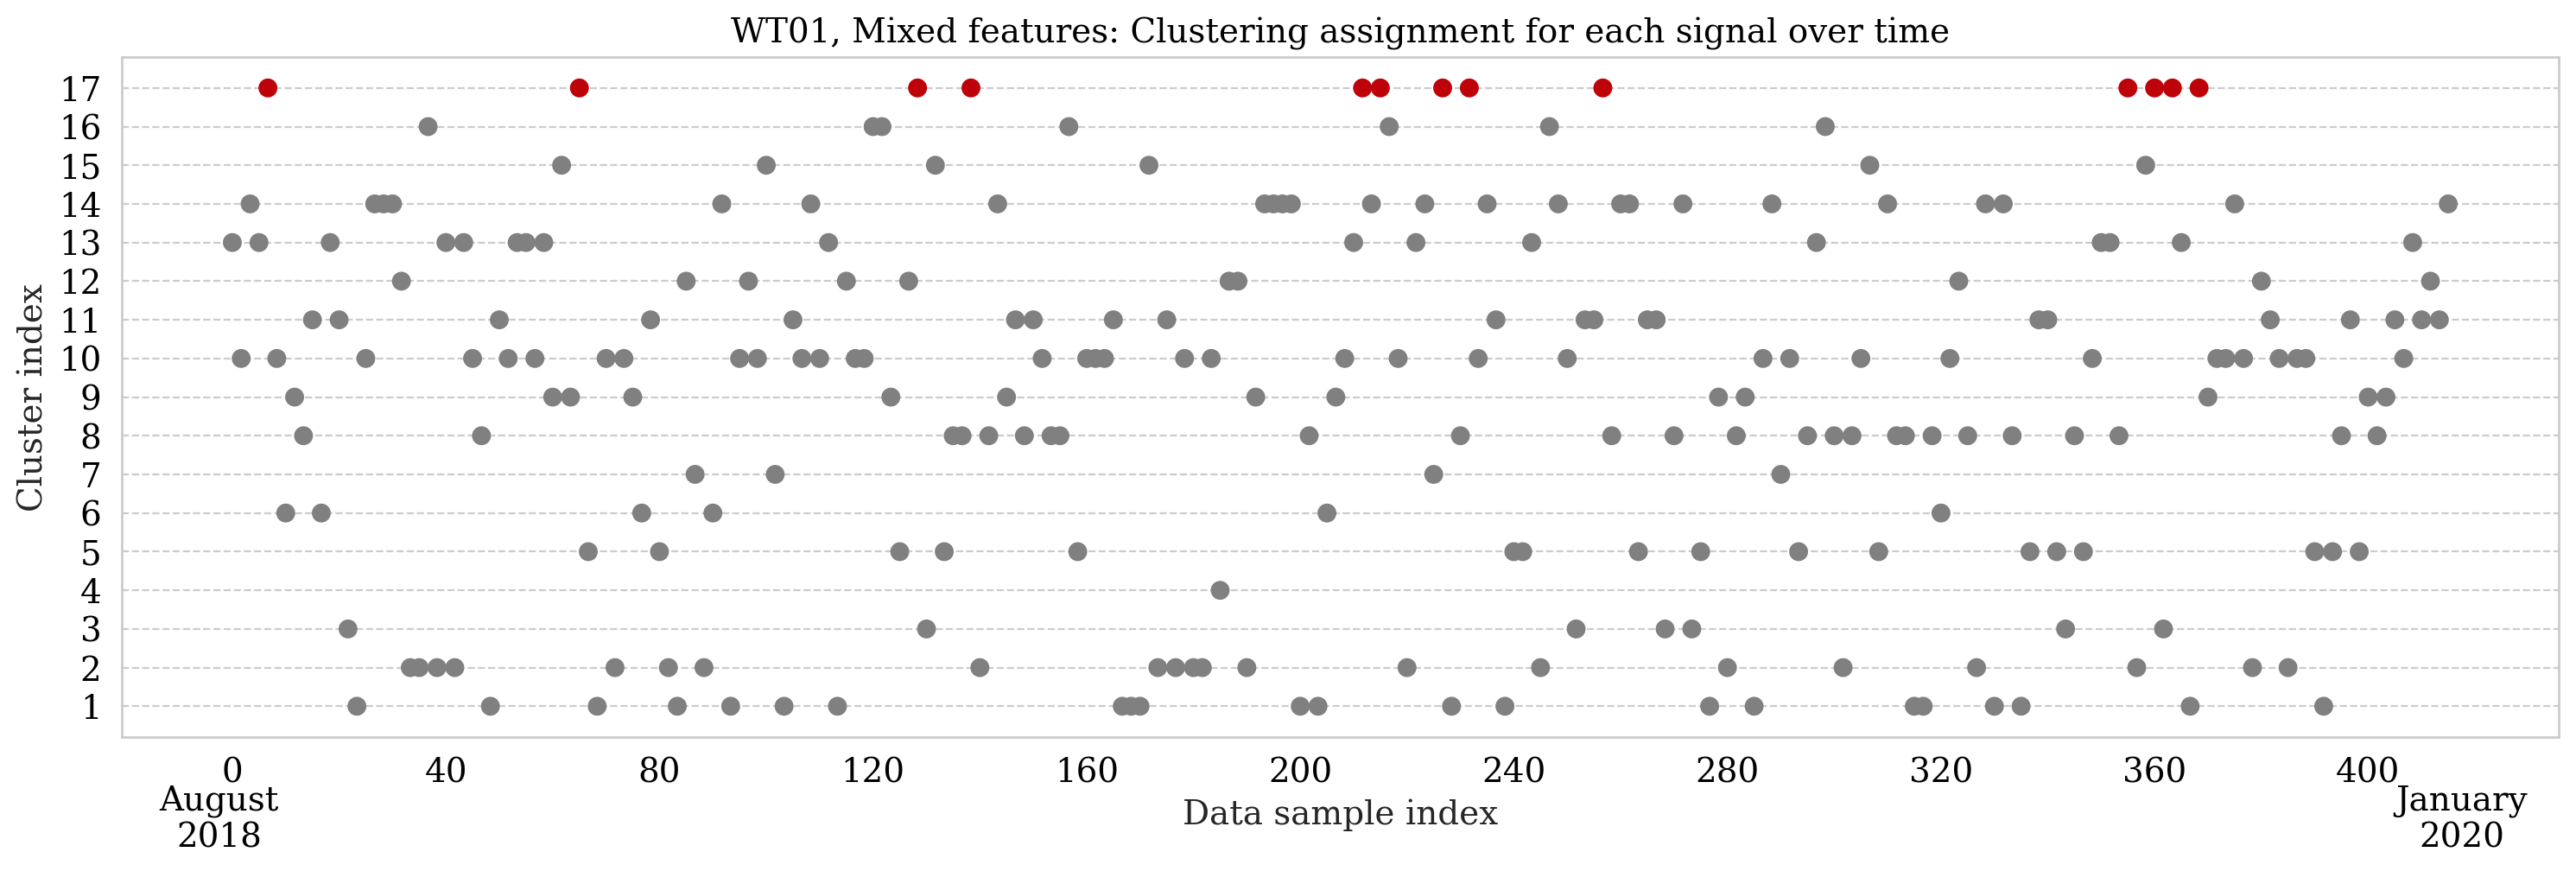

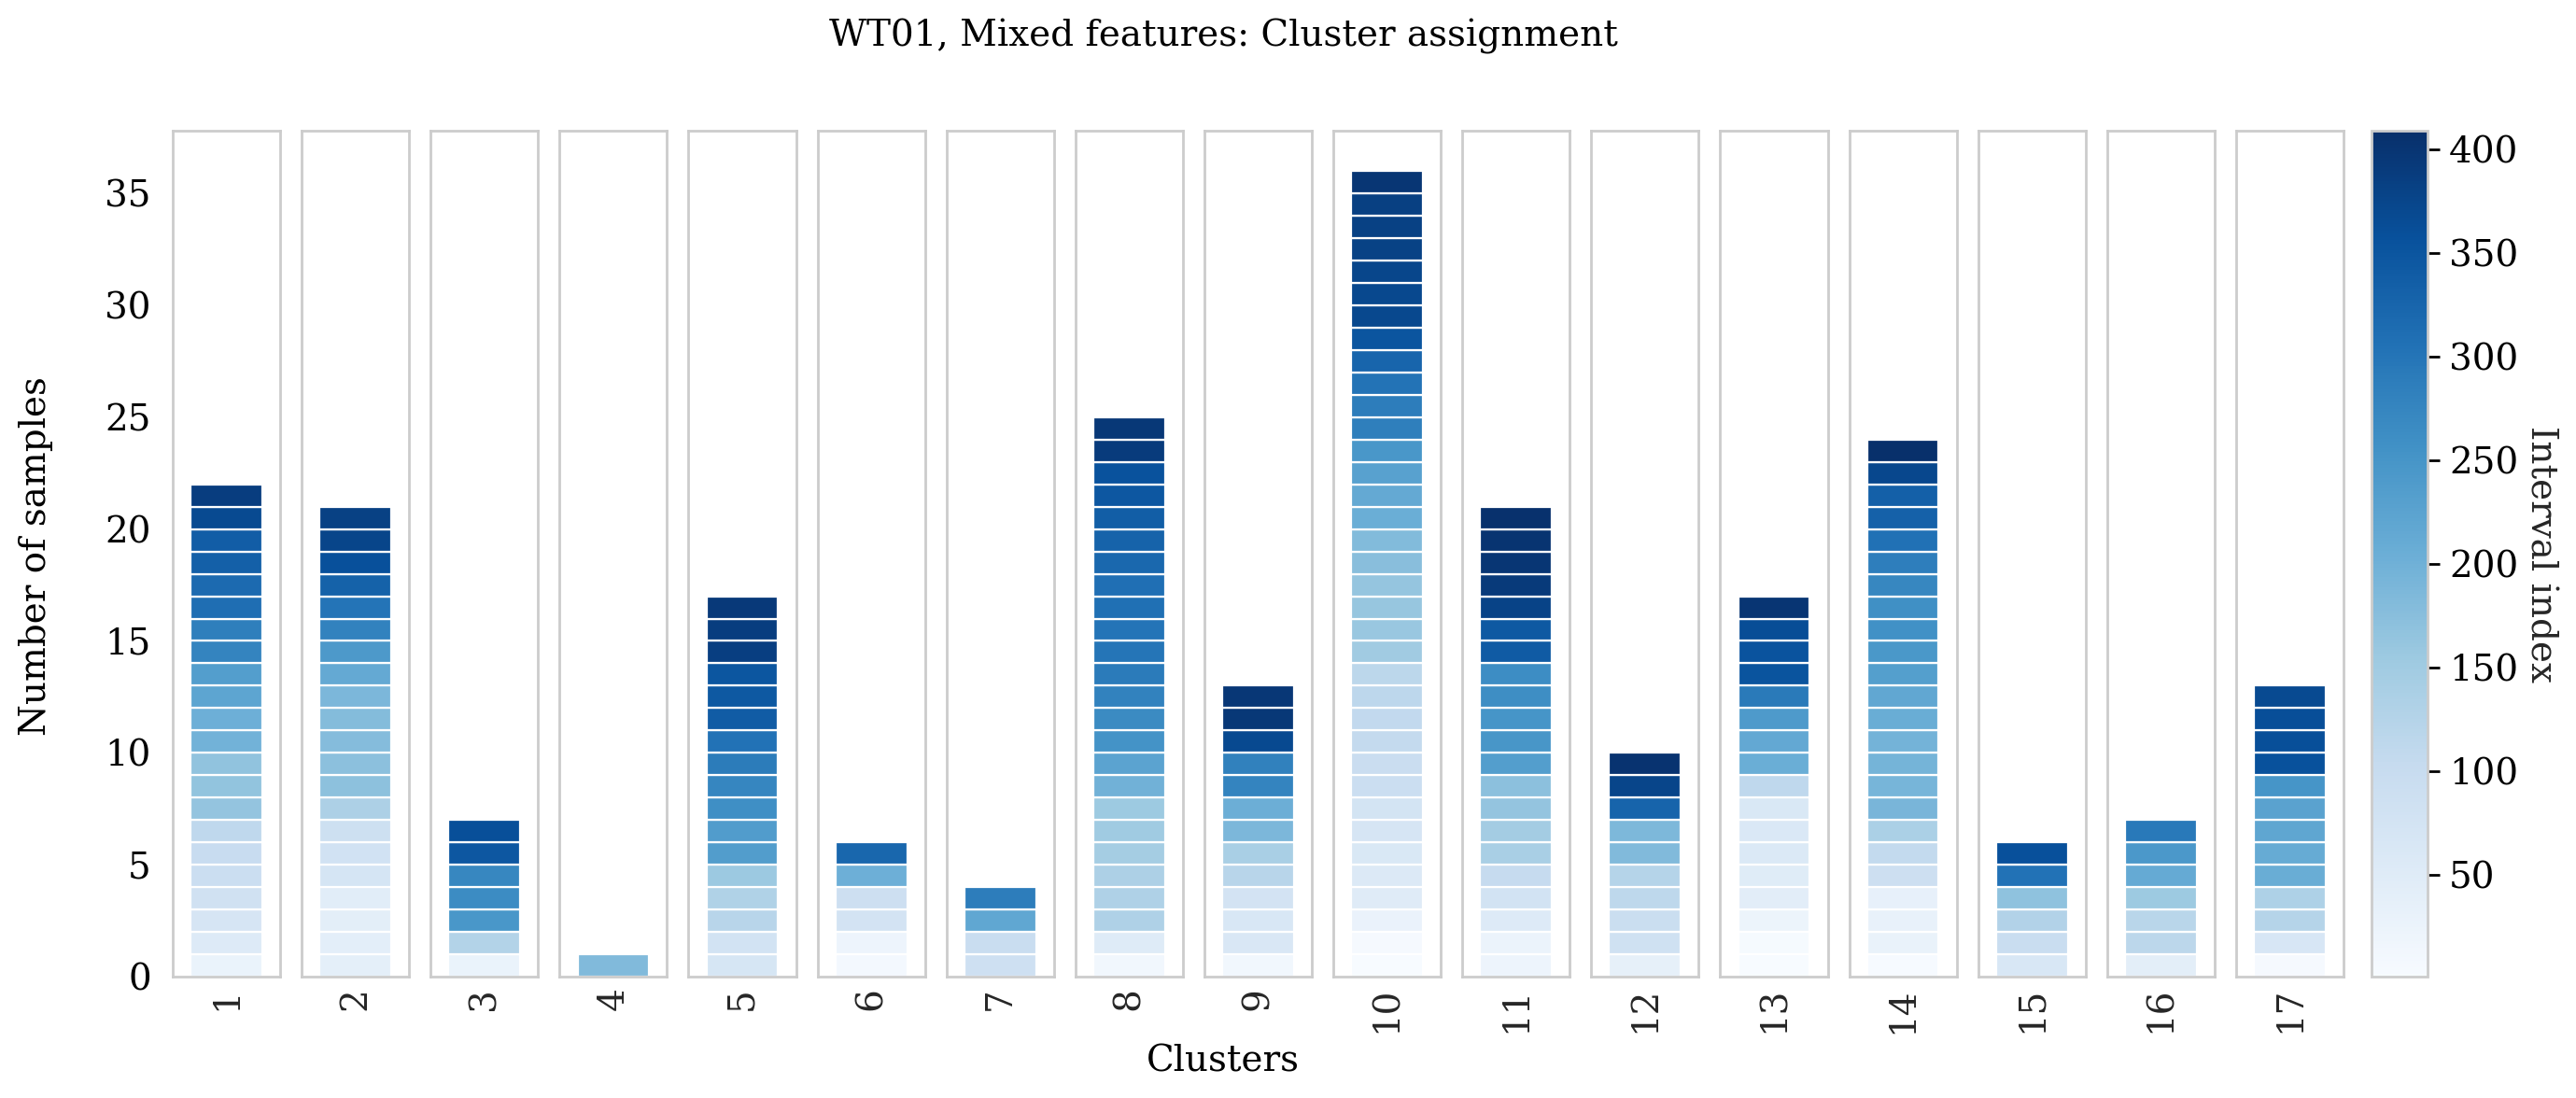

DIFFERENT HUES [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


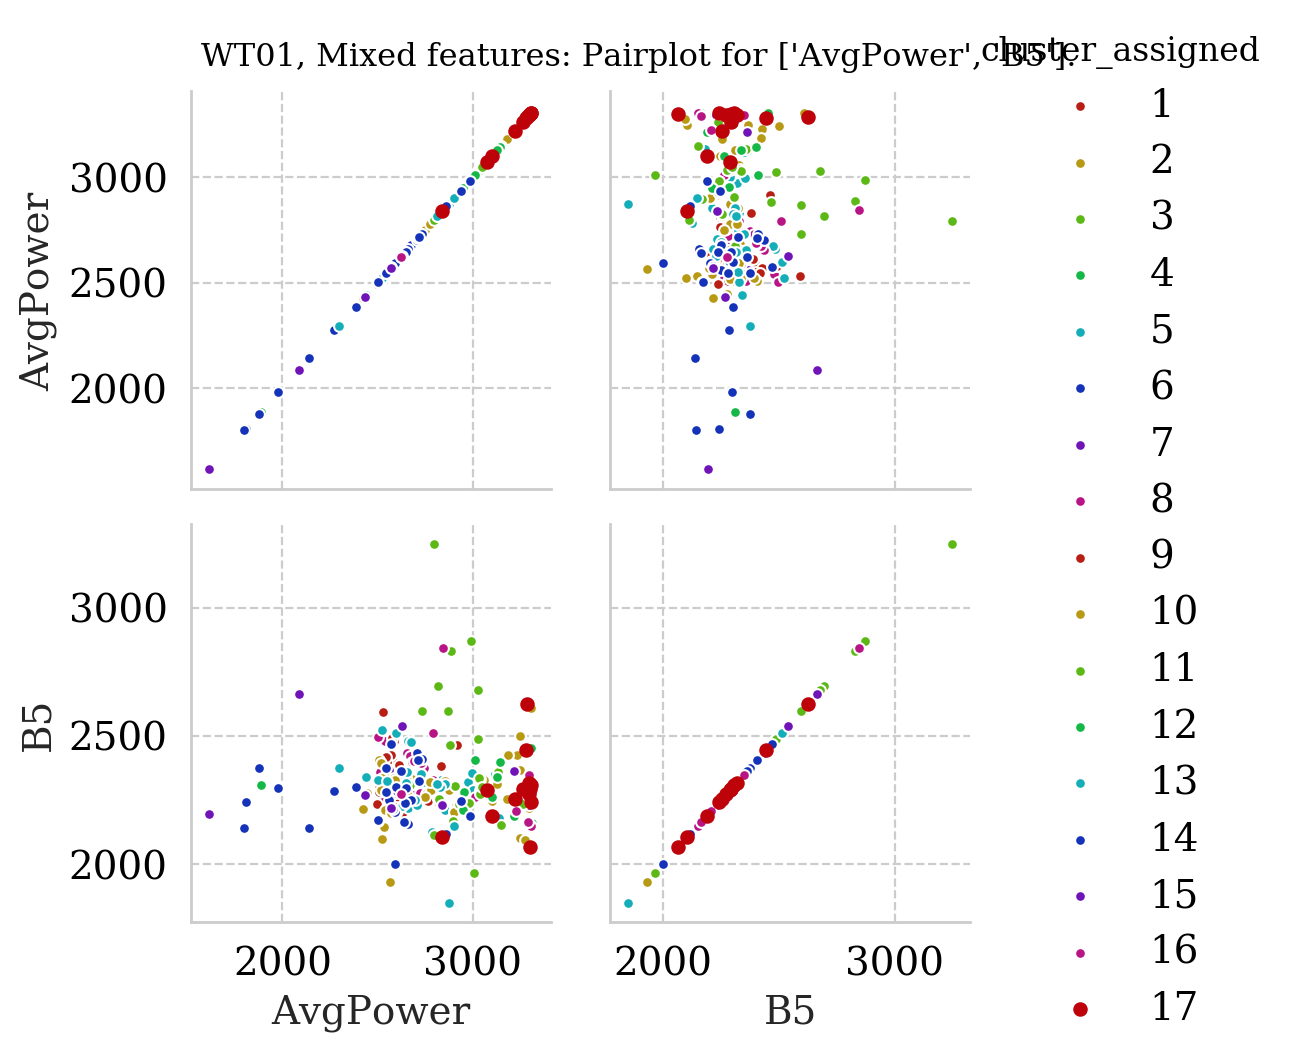

In [33]:
wt_num_string='1'

features_sets_titles= [
                'Operational and bi-spectrum features',
                'Operational and time features',
                'Operational and IMF kurtosis features',
                'Operational and IMF energy features',
                'Mixed features'
               ]

k_dictionary= {
    features_sets_names[0]: 17,
    features_sets_names[1]: 12,    
    features_sets_names[2]: 18,
    features_sets_names[3]: 17,
    features_sets_names[4]: 17,
}
fsets_for_printing=[
    ['AvgPower','B1'],
    ['AvgPower','kurt'],
    ['AvgPower','imf_kurtosis_5'],
    ['AvgPower','imf_entropy_5'],
    ['AvgPower','B5']]

selected_cluster_dict = {
    features_sets_names[0]: 9,
    features_sets_names[1]: 0,    
    features_sets_names[2]: 10,
    features_sets_names[3]: 0,
    features_sets_names[4]: 16,
}

print('wt_num_string:',wt_num_string)
for i,features in enumerate(features_sets):
    display(Markdown(f'<span style="color: #2a9d8f; font-size: 20px">{features_sets_names[i]}:</span>'))           
    
    assigned = run_kmeans(features_sets_titles[i],
                          wt_num_string,
                          features_sets_names[i],
                          features,
                          k_dictionary[features_sets_names[i]],
                          selected_cluster=selected_cluster_dict[features_sets_names[i]],
                          fset1=fsets_for_printing[i]
                         )

In [ ]:
print(wt_num_string)
assigned = run_kmeans('Complete data set',wt_num_string,'all_36_features',features,k_dictionary[features_sets_names[0]])
